# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [11]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None, class_threshold=.5):
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    data_x = data_x.sample(data_x.shape[0])
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y[train_x.index]
        valid_x = data_x.iloc[start:end]
        valid_y = data_y[valid_x.index]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
        
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - (fold_size * ratio_negatives_to_positives)), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((len(models), 6))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
            result_table[i] = results[1]
            
            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)
        i+=1
    display(pd.DataFrame(result_table, index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))

In [12]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [15]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


Dummy Random
╠■■■■■■■■■╣


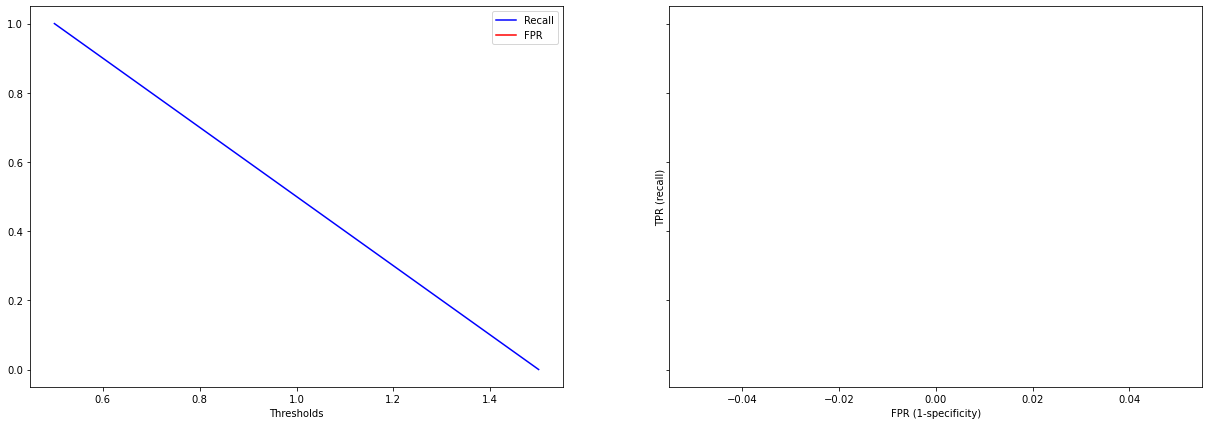

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


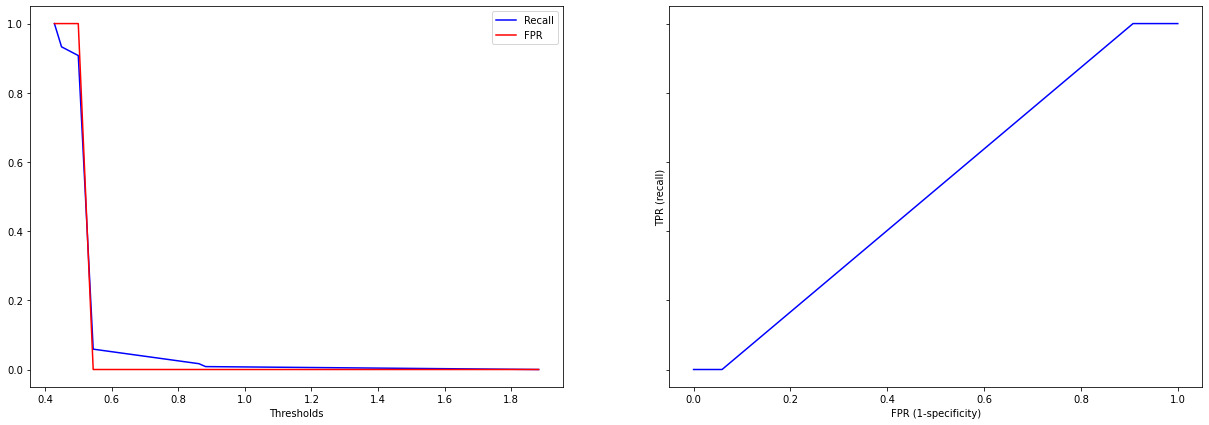

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.506273  0.081924   0.560225     0.930545  0.141012  0.518336
Validation  0.498765  0.077722   0.509585     0.920492  0.131447  0.504703


Random Forest (100 estimators)
╠■■■■■■■■■╣


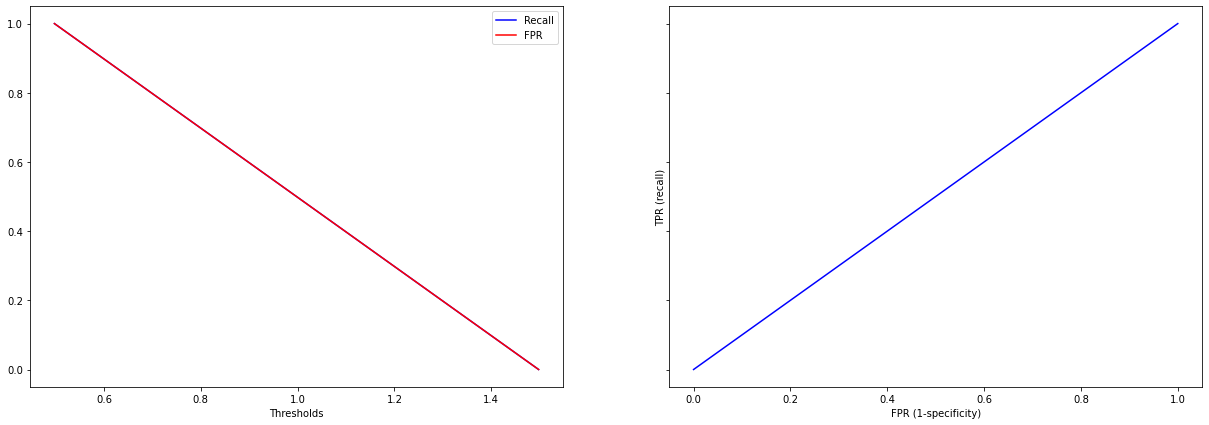

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.502227  0.572630   0.301180     0.431818  0.394624  0.503224
Validation  0.500406  0.571385   0.300422     0.429508  0.393632  0.500037


XGBoost Classifier
╠■■■■■■■■■╣


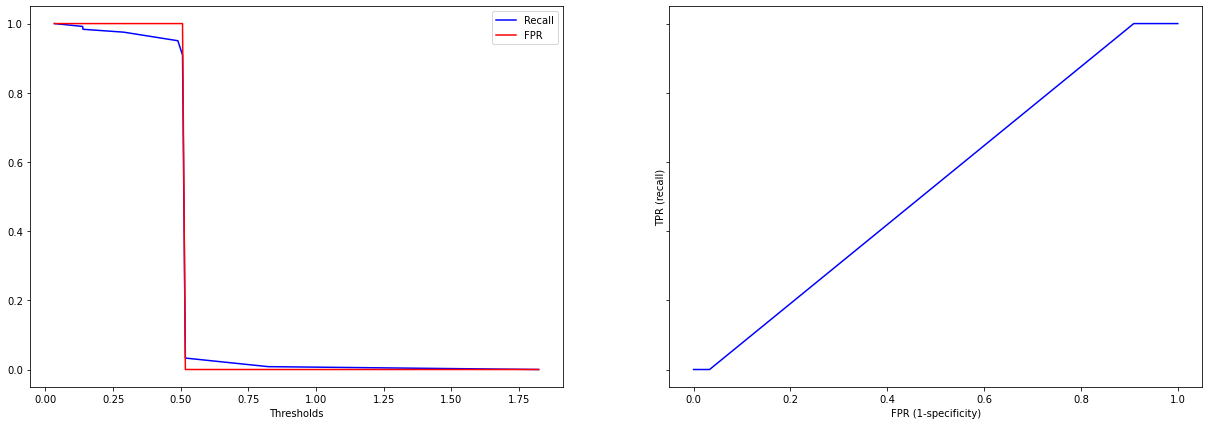

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.516274  0.804076   0.516121     0.228545  0.596947  0.524476
Validation  0.499180  0.783753   0.486581     0.213934  0.576661  0.505447


SVM
╠■■■■■■■■■╣


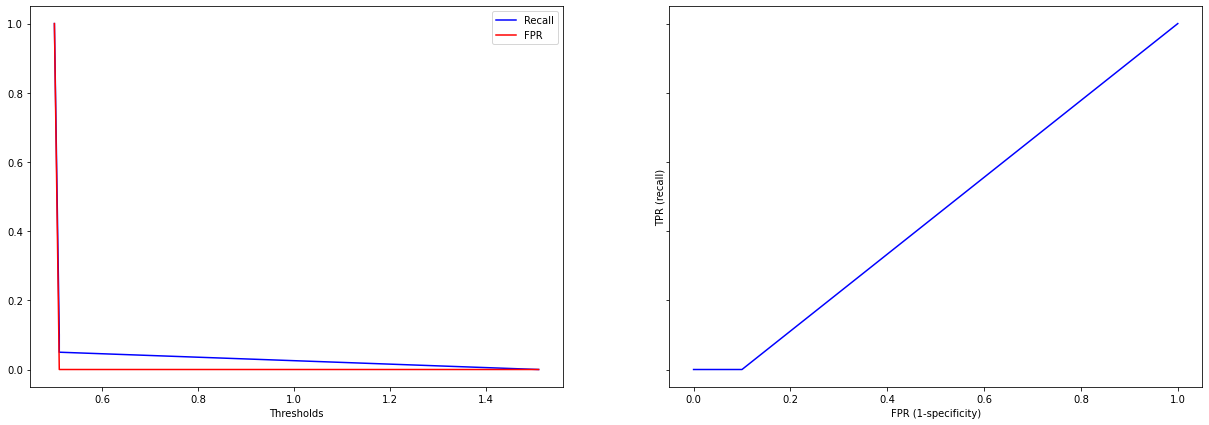

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.500727  0.597542   0.432165     0.404000  0.433891  0.496799
Validation  0.493039  0.583660   0.426724     0.401639  0.425297  0.483259


KNN
╠■■■■■■■■■╣


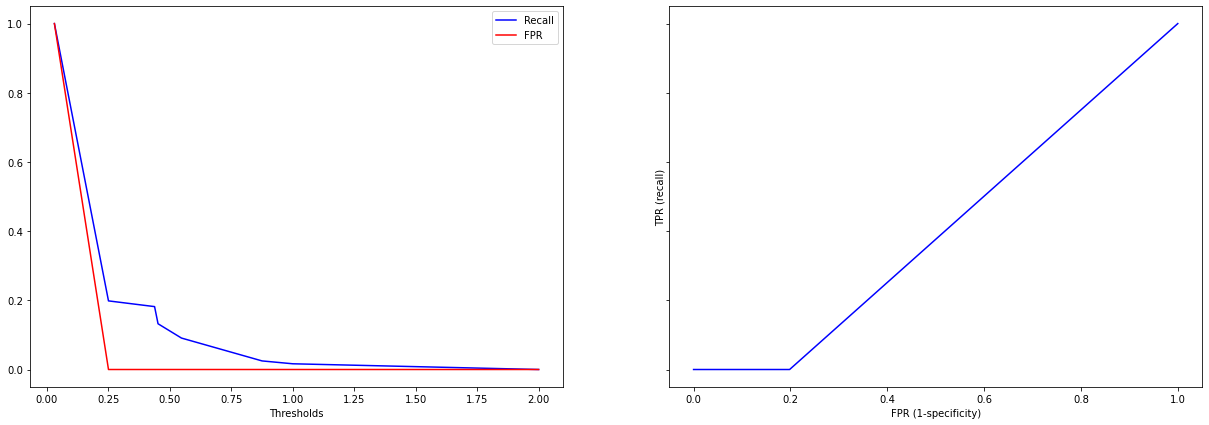

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.509273  0.033913   0.711851     0.984545  0.063951  0.503742
Validation  0.504090  0.026176   0.552143     0.982787  0.049216  0.498974


Logistic Regression
╠■■■■■■■■■╣


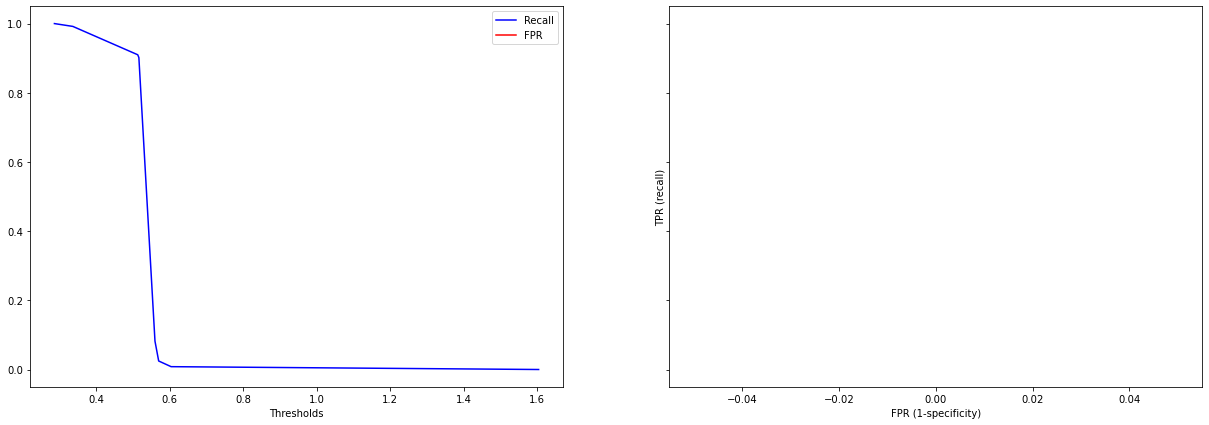

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.513365  0.798338   0.516537     0.228455  0.593987  0.519135
Validation  0.506536  0.781354   0.488394     0.231148  0.581035  0.507656

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.498765  0.077722   0.509585     0.920492   
Random Forest (100 estimators)  0.500406  0.571385   0.300422     0.429508   
XGBoost Classifier              0.499180  0.783753   0.486581     0.213934   
SVM                             0.493039  0.583660   0.426724     0.401639   
KNN                             0.504090  0.026176   0.552143     0.982787   
Logistic Regression             0.506536  0.781354   0.488394     0.231148   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.131447  0.504703  
Random Forest (100 estimators)  0.393632  0.500037  
XGBoost Classifier              0.576661  0.505447  
SVM                             0.425297  0.483259  
KNN                             0.049216  0.498974  
Logistic Regression             0.581035  0.507656

In [48]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


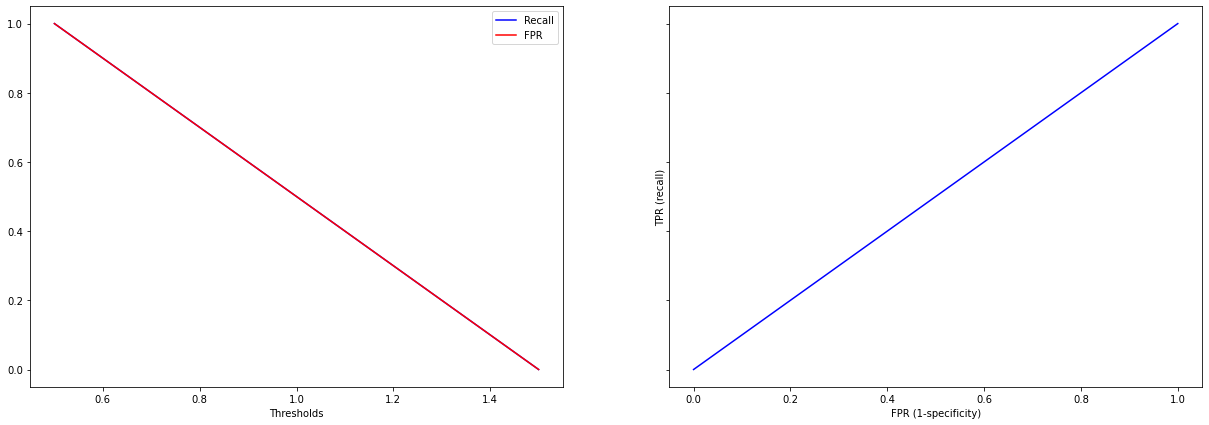

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


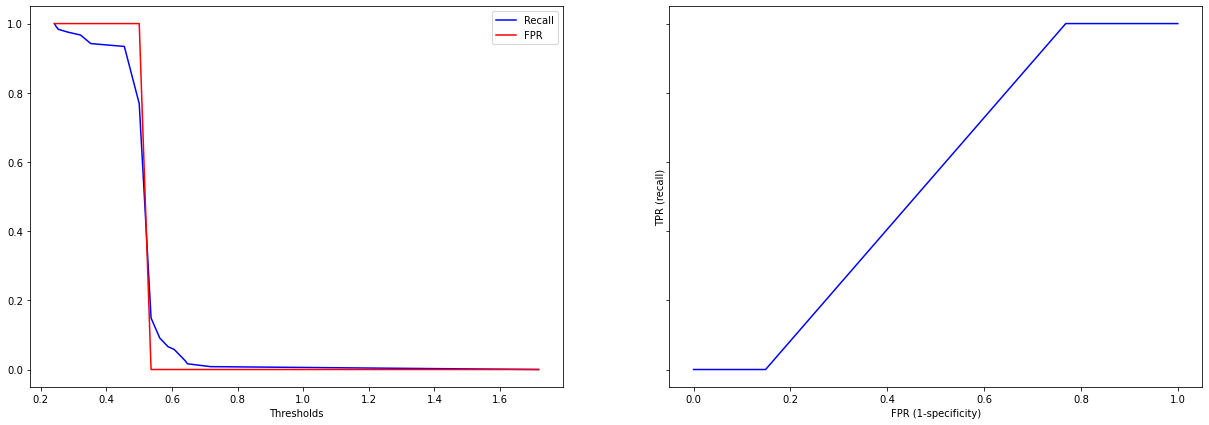

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.526911  0.201490   0.578627     0.852273  0.298223  0.557125
Validation  0.521248  0.196222   0.547776     0.846721  0.284341  0.551614


Random Forest (100 estimators)
╠■■■■■■■■■╣


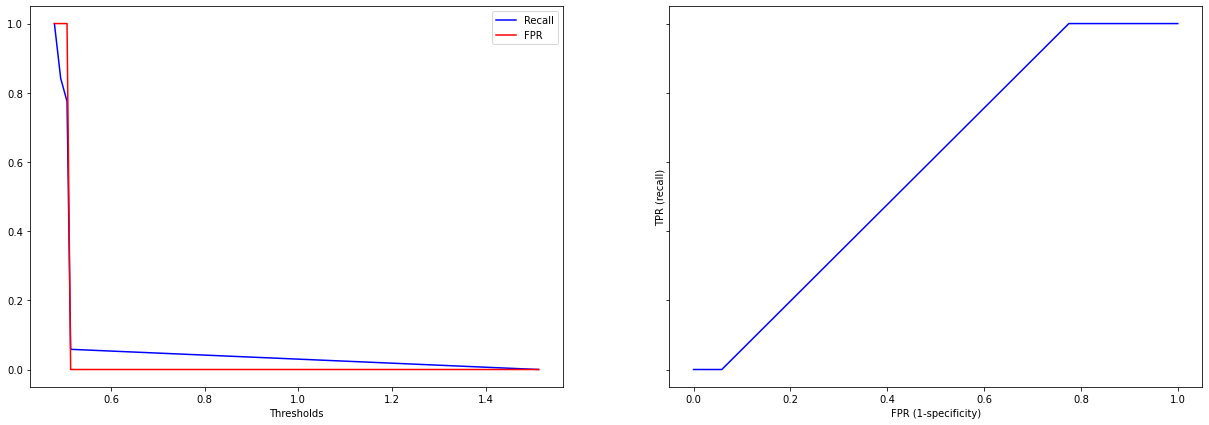

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.533411  0.525335   0.563249     0.541545  0.470605  0.553717
Validation  0.516790  0.502832   0.508005     0.530328  0.437294  0.541830


XGBoost Classifier
╠■■■■■■■■■╣


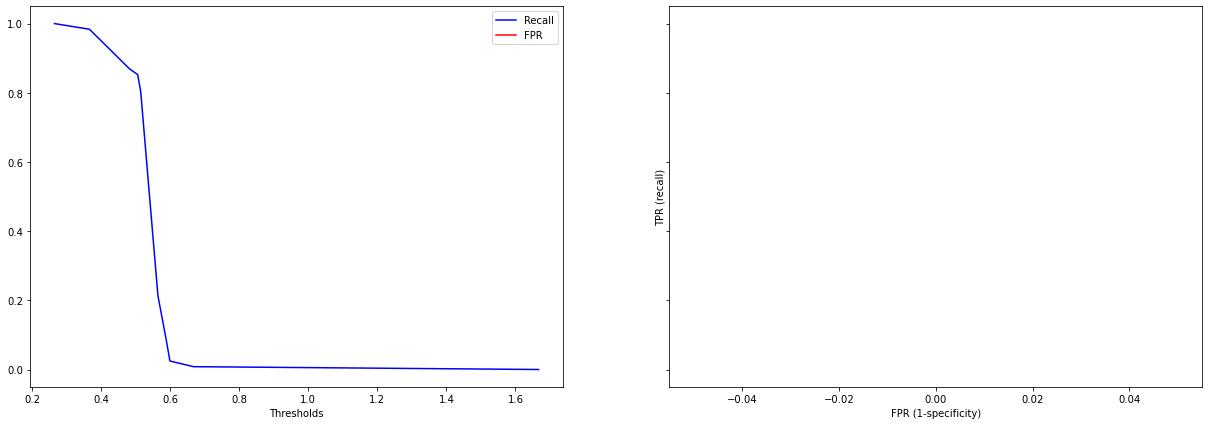

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.549095  0.868523   0.529996     0.229727  0.658184  0.572172
Validation  0.532765  0.854312   0.519892     0.210656  0.646022  0.543227


SVM
╠■■■■■■■■■╣


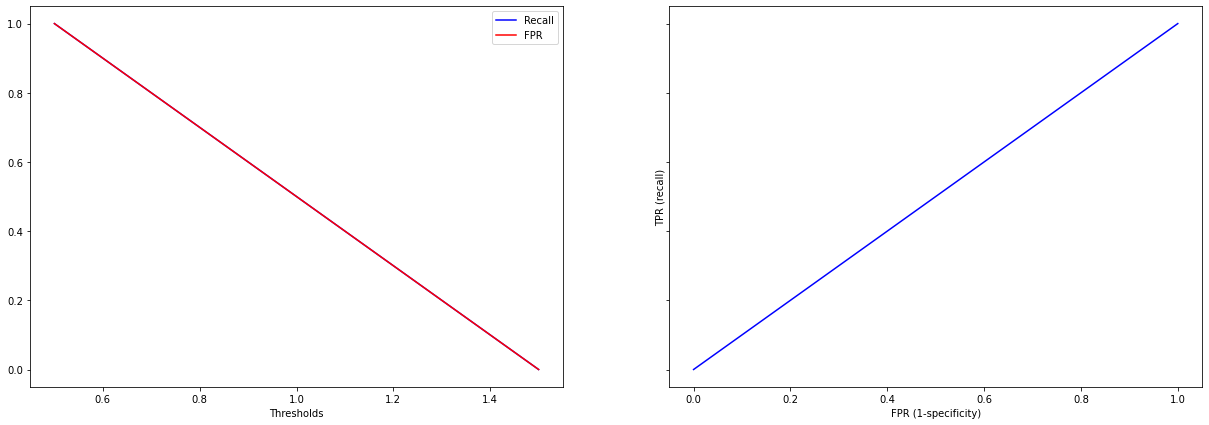

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.531458  0.302786   0.591143     0.760182  0.341765  0.555346
Validation  0.501663  0.261895   0.530712     0.740984  0.294363  0.525486


KNN
╠■■■■■■■■■╣


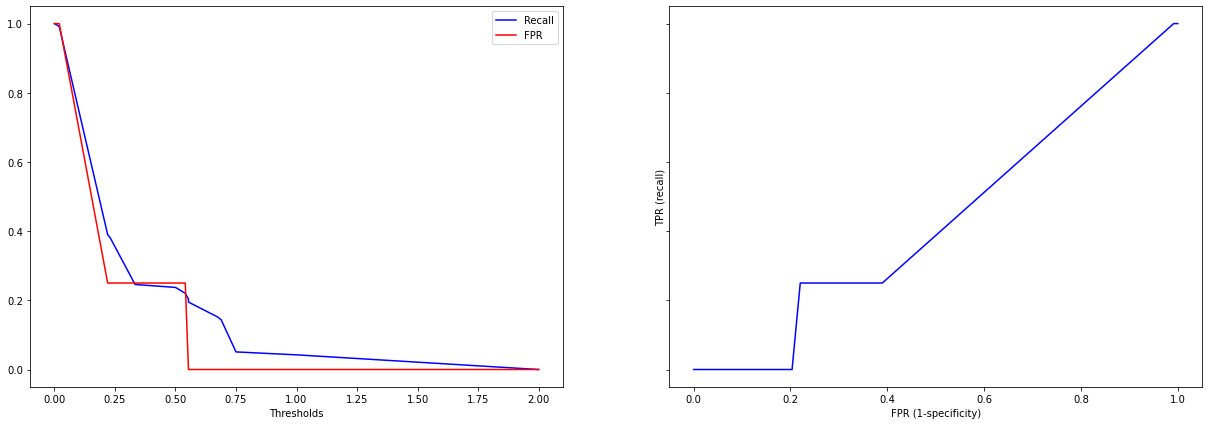

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.517229  0.069647   0.707626     0.964727  0.123103  0.550842
Validation  0.506547  0.059723   0.537791     0.954098  0.105253  0.542448


Logistic Regression
╠■■■■■■■■■╣


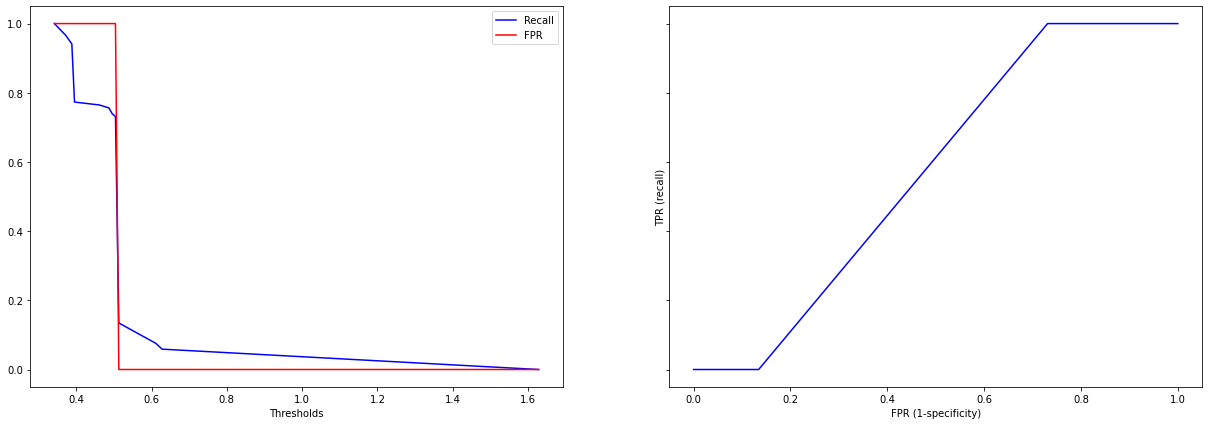

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.541913  0.651057   0.550610     0.432818  0.545756  0.563186
Validation  0.528660  0.614314   0.538621     0.442623  0.512500  0.561795

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.521248  0.196222   0.547776     0.846721   
Random Forest (100 estimators)  0.516790  0.502832   0.508005     0.530328   
XGBoost Classifier              0.532765  0.854312   0.519892     0.210656   
SVM                             0.501663  0.261895   0.530712     0.740984   
KNN                             0.506547  0.059723   0.537791     0.954098   
Logistic Regression             0.528660  0.614314   0.538621     0.442623   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.284341  0.551614  
Random Forest (100 estimators)  0.437294  0.541830  
XGBoost Classifier              0.646022  0.543227  
SVM                             0.294363  0.525486  
KNN                             0.105253  0.542448  
Logistic Regression             0.512500  0.561795

In [15]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the most important feature from epidemiological factors. <i>Note:</i> Most of the models have really high specificity, which might not be a good thing since the recall is really low and both precision and accuracy are just around .5 (this experiments use undersampling to have balanced classes). This suggests that most of the models are predicting everything is negative.

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [13]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [14]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
5135   195.0  135.0    4
6106   215.0  115.0    4
9058   200.0  120.0    3
11792  190.0  130.0    3
14314  205.0  125.0    4
19137  215.0  117.0    4
20168  190.0  130.0    4
20379  220.0  140.0    4
20582  200.0  118.0    4
28579  180.0  130.0    3
31555  185.0  130.0    3
31880  180.0  135.0    2
33497  210.0  120.0    4
36197  190.0  135.0    3
36239  185.0  135.0    3
45860  220.0  115.0    3
48067  190.0  130.0    4
50607  220.0  108.0    4
75219  195.0  130.0    2
76797  195.0  130.0    1
77724  190.0  135.0    2
91625  210.0  125.0    3
93508  200.0  118.0    4

As expected, all pressure variables (including pam) are correlated between each other

In [15]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


In [16]:
vitals.describe()

temperature         pulse            rr          sats           pam
count  46961.000000  47666.000000  40972.000000  46959.000000  45990.000000
mean      36.795284     76.895103     14.708826     98.239869     93.238276
std        0.287278     13.211416      1.957359      1.401417     10.886470
min       34.650000     35.000000      8.000000     81.000000     50.333333
25%       36.650000     68.000000     13.000000     97.000000     86.000000
50%       36.800000     76.000000     15.000000     98.000000     92.666667
75%       36.950000     85.000000     16.000000     99.000000     99.666667
max       39.600000    150.000000     32.000000    100.000000    166.666667

<AxesSubplot:>

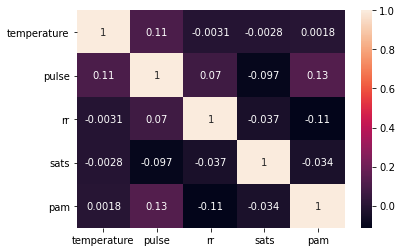

In [17]:
sns.heatmap(vitals.corr(), annot=True)

In [18]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


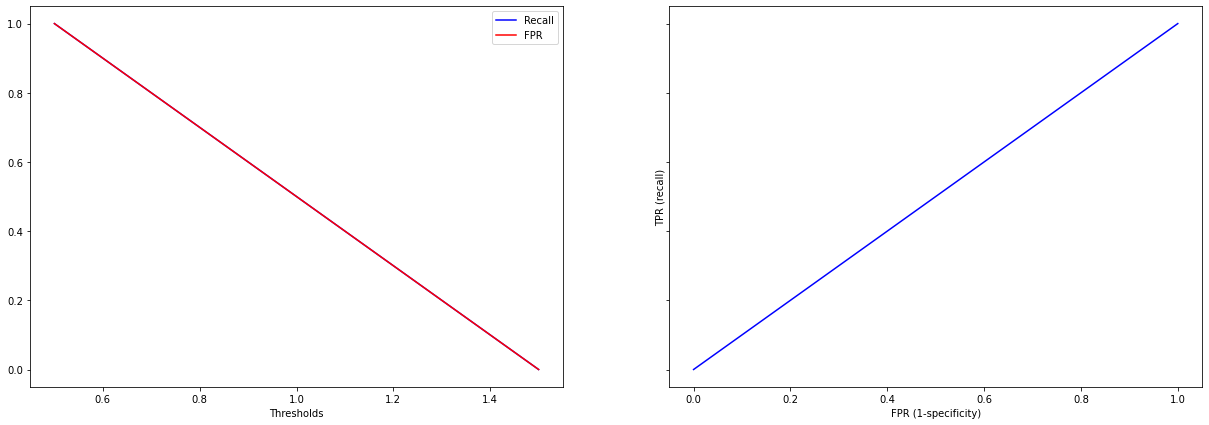

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


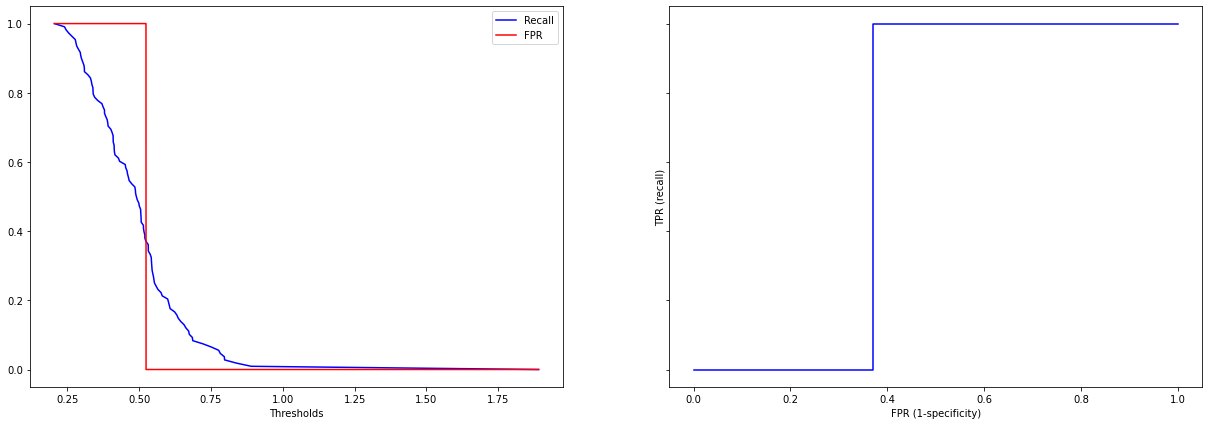

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.564853  0.532505   0.569074     0.597172  0.550156  0.595325
Validation  0.567414  0.526864   0.574878     0.608257  0.548976  0.596721


Random Forest (100 estimators)
╠■■■■■■■■■╣


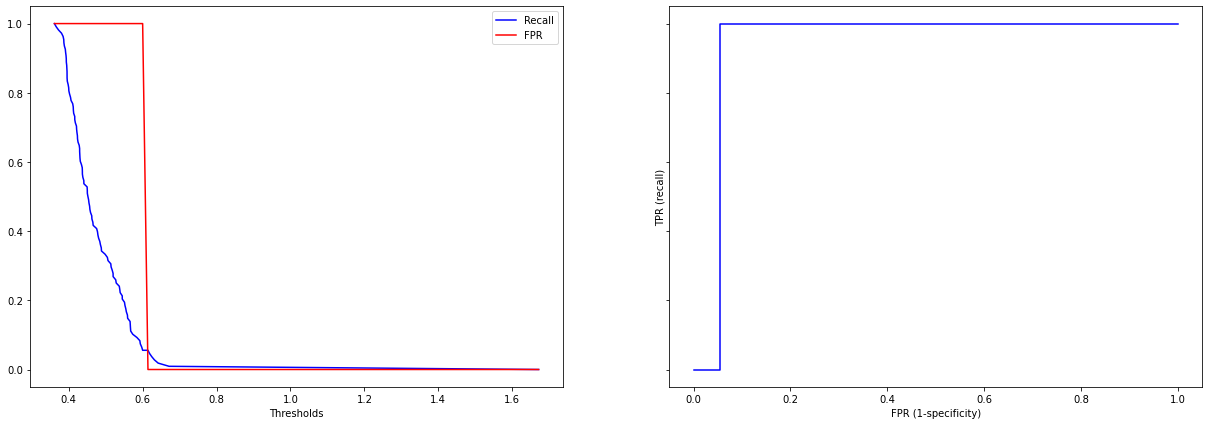

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.612400  0.561014   0.626114     0.663737  0.591046  0.663602
Validation  0.582016  0.521501   0.595549     0.643119  0.552007  0.624803


XGBoost Classifier
╠■■■■■■■■■╣


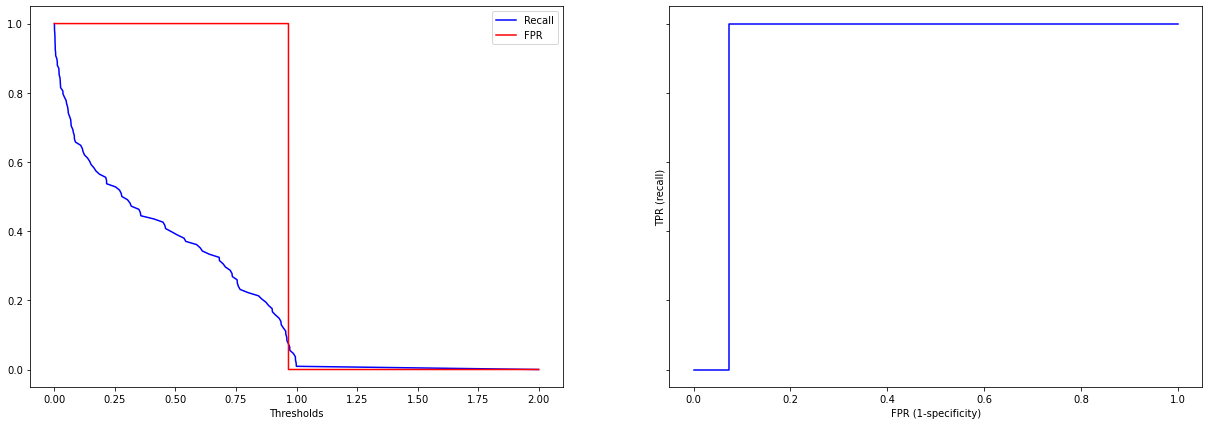

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997878  0.997371   0.998382     0.998384  0.997876  0.999981
Validation  0.534022  0.522269   0.536212     0.545872  0.527840  0.559690


SVM
╠■■■■■■■■■╣


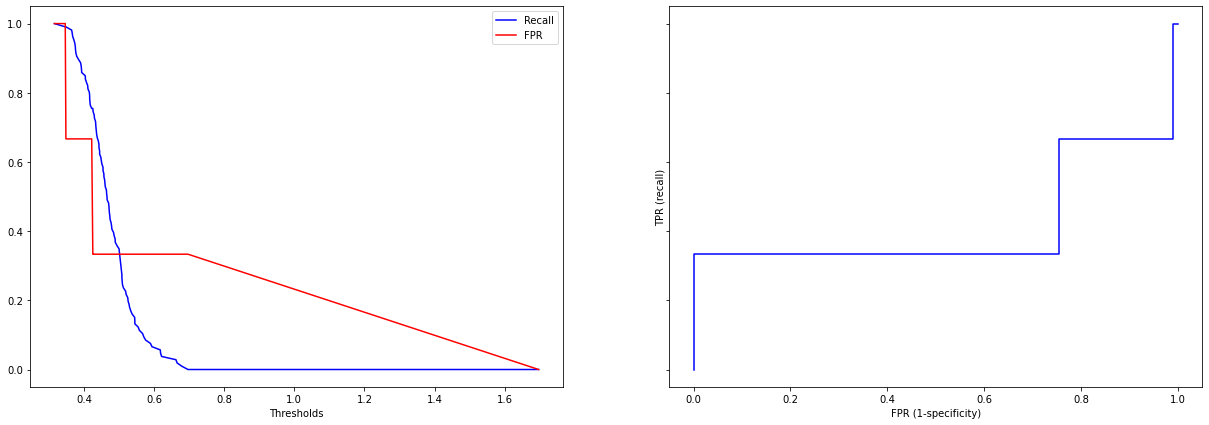

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589410  0.535135   0.600058     0.643636  0.565702  0.634907
Validation  0.582481  0.524204   0.590681     0.641284  0.553030  0.628426


KNN
╠■■■■■■■■■╣


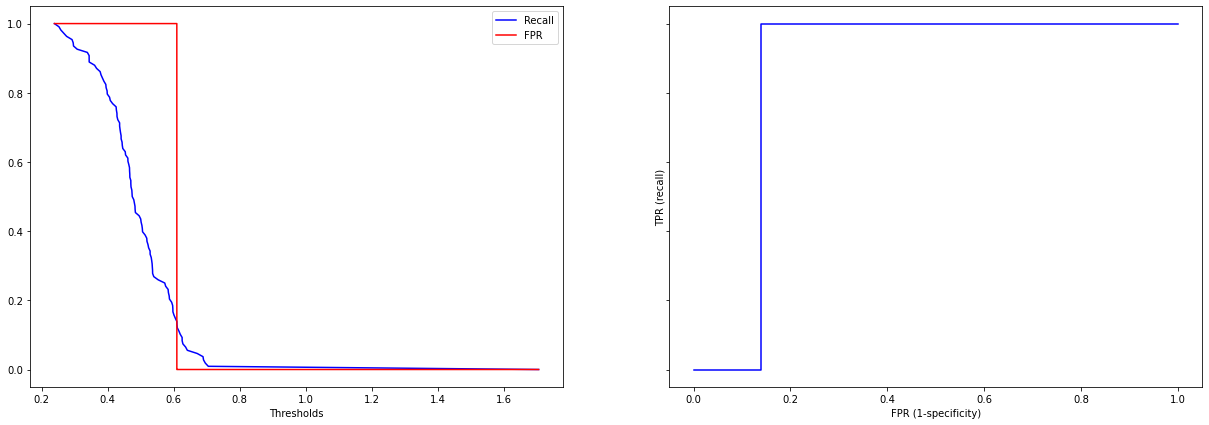

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998282  0.996663   0.999899     0.999899  0.998278  0.999993
Validation  0.531299  0.561501   0.530006     0.500917  0.544298  0.552937


Logistic Regression
╠■■■■■■■■■╣


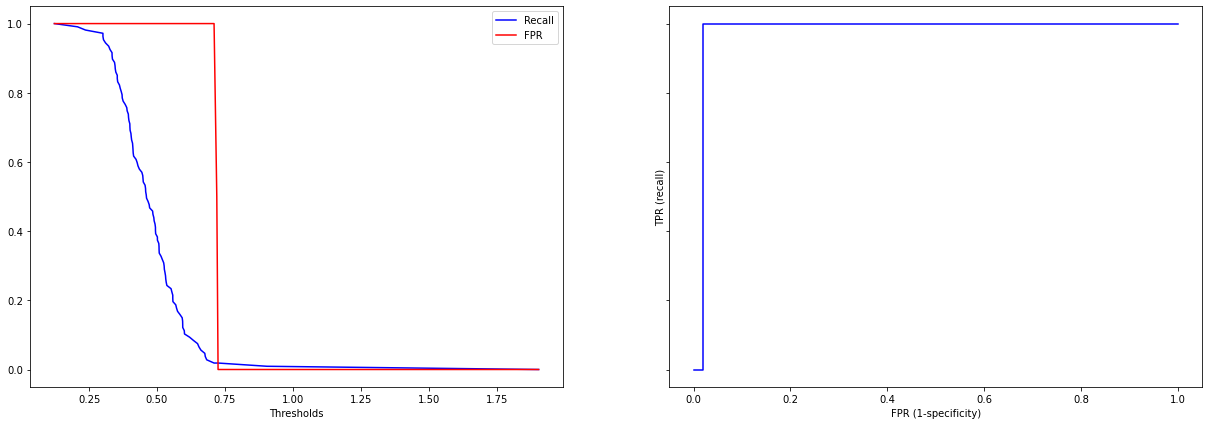

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.587995  0.558387   0.593402     0.617576  0.575333  0.628968
Validation  0.582466  0.544128   0.587796     0.621101  0.563225  0.626598

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.567414  0.526864   0.574878     0.608257   
Random Forest (100 estimators)  0.582016  0.521501   0.595549     0.643119   
XGBoost Classifier              0.534022  0.522269   0.536212     0.545872   
SVM                             0.582481  0.524204   0.590681     0.641284   
KNN                             0.531299  0.561501   0.530006     0.500917   
Logistic Regression             0.582466  0.544128   0.587796     0.621101   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.548976  0.596721  
Random Forest (100 estimators)  0.552007  0.624803  
XGBoost Classifier              0.527840  0.559690  
SVM                             0.553030  0.628426  
KNN                             0.544298  0.552937  
Logistic Regression             0.563225  0.626598

In [22]:
#All vitals without normalization or standardization
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

<b>Rr</b>, <b>pulse</b> and <b>temperature</b> seem to be the most dominant features in the experiments. <b>Random Forest</b> seems to be the best performing model here.

Dummy Random
╠■■■■■■■■■╣


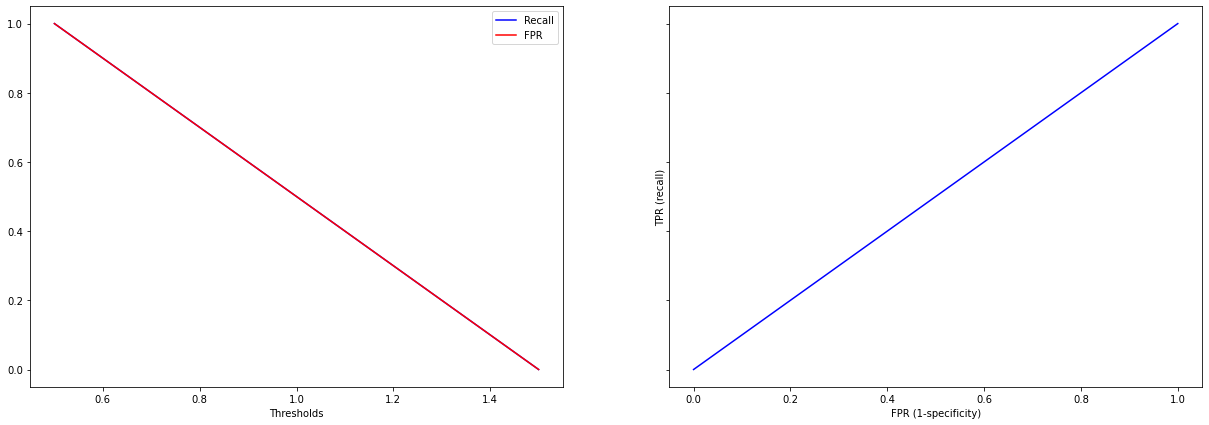

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


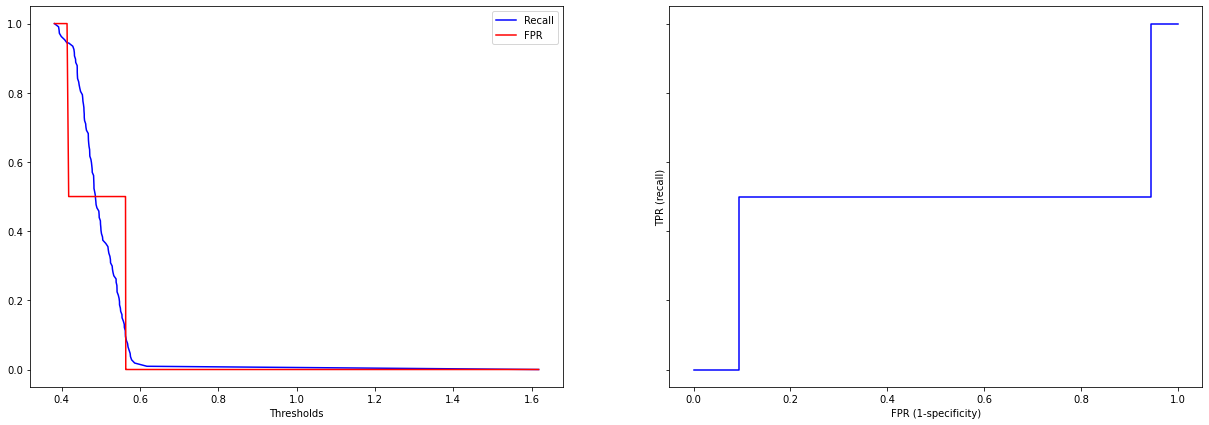

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.612552  0.576889   0.621221     0.648182  0.597909  0.662362
Validation  0.587037  0.549616   0.593786     0.624771  0.568595  0.635014


XGBoost Classifier
╠■■■■■■■■■╣


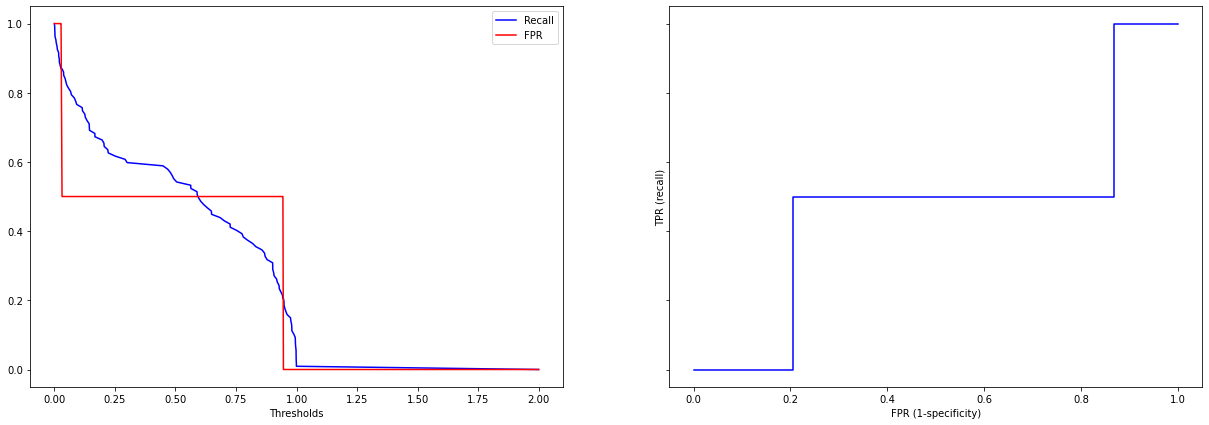

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997676  0.997472   0.997879     0.997879  0.997674  0.999981
Validation  0.549583  0.547773   0.552520     0.551376  0.549149  0.576336


SVM
╠■■■■■■■■■╣


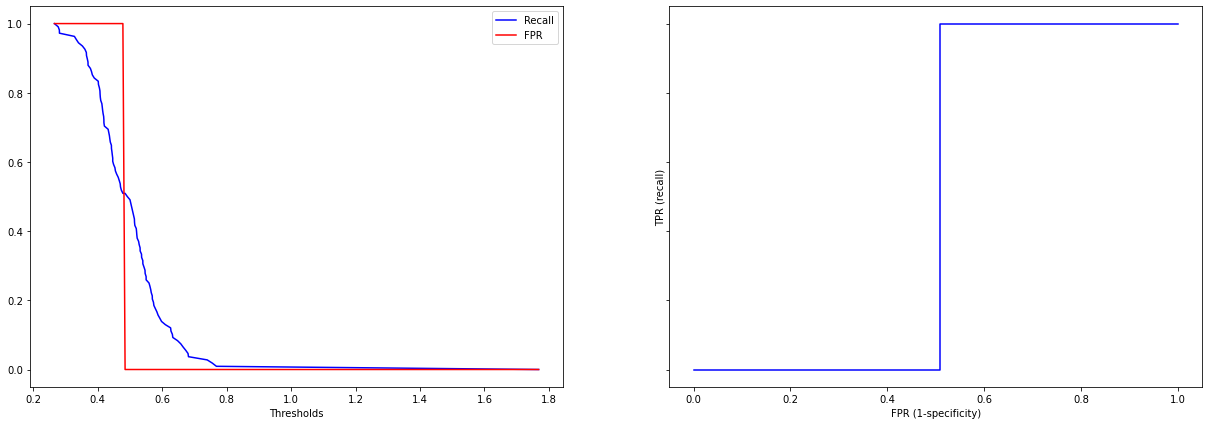

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591936  0.541604   0.601933     0.642222  0.570159  0.641583
Validation  0.579735  0.535104   0.585364     0.624771  0.557124  0.624060


KNN
╠■■■■■■■■■╣


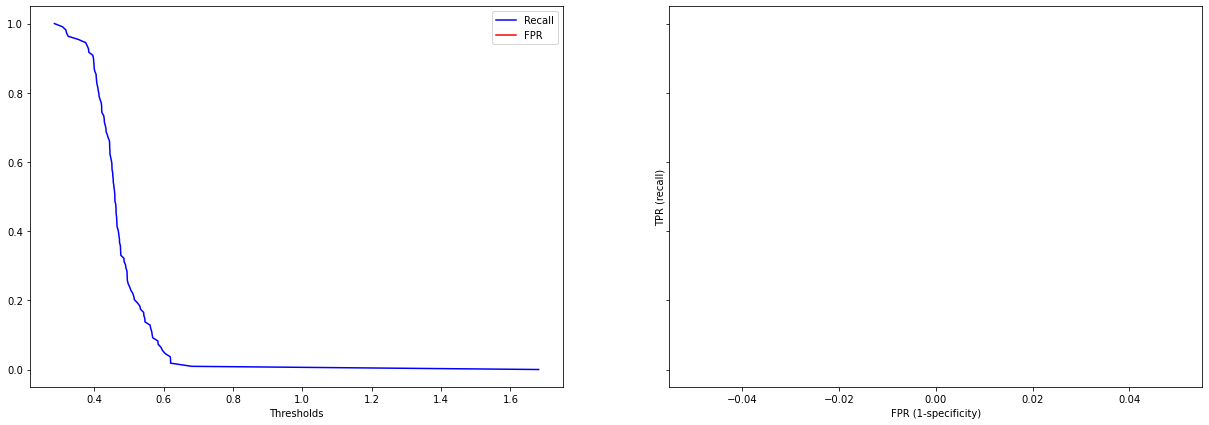

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998282  0.996563   1.000000     1.000000  0.998278  0.999992
Validation  0.584741  0.503236   0.598345     0.666972  0.544541  0.621335


Logistic Regression
╠■■■■■■■■■╣


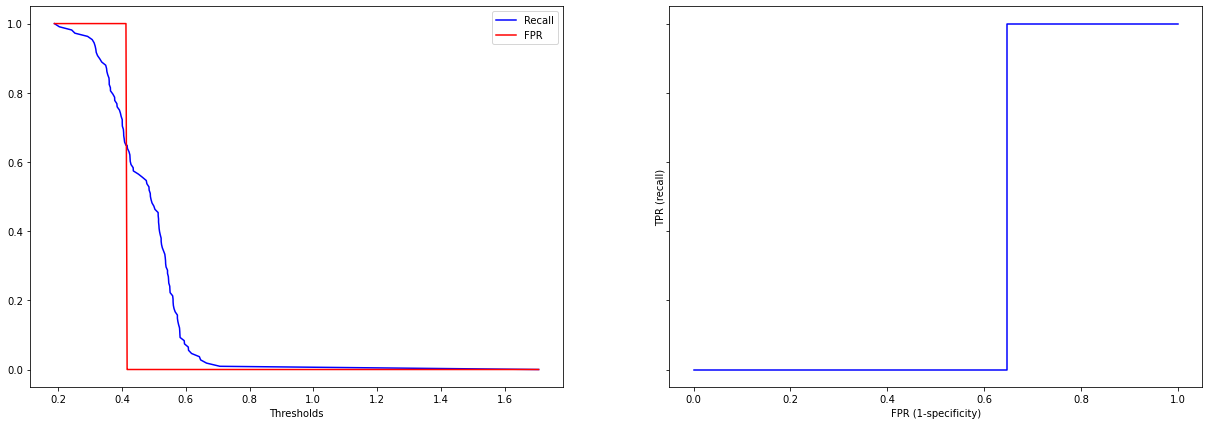

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.592037  0.560308   0.598135     0.623737  0.578588  0.637561
Validation  0.596182  0.560601   0.602030     0.632110  0.577730  0.640787

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.587037  0.549616   0.593786     0.624771   
XGBoost Classifier              0.549583  0.547773   0.552520     0.551376   
SVM                             0.579735  0.535104   0.585364     0.624771   
KNN                             0.584741  0.503236   0.598345     0.666972   
Logistic Regression             0.596182  0.560601   0.602030     0.632110   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.568595  0.635014  
XGBoost Classifier              0.549149  0.576336  
SVM                             0.557124  0.624060  
KNN                             0.544541  0.621335  
Logistic Regression             0.577730  0.640787

In [23]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

<b>Pulse</b>, <b>temperature</b> and <b>rr</b> seem to be again the dominant features with standardized values. It improved the performance of <b>SVM</b>, <b>KNN</b> and <b>Logistic Regression<b>

Dummy Random
╠■■■■■■■■■╣


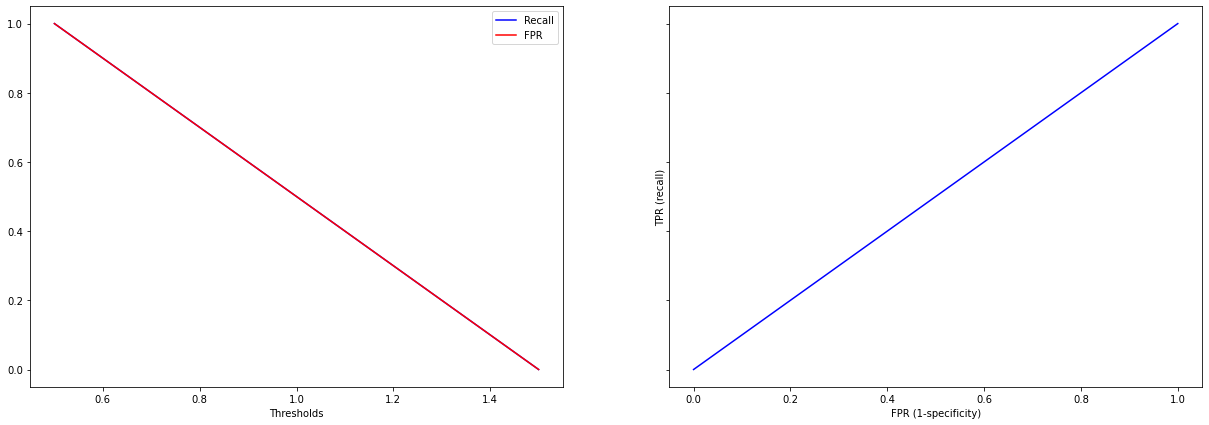

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


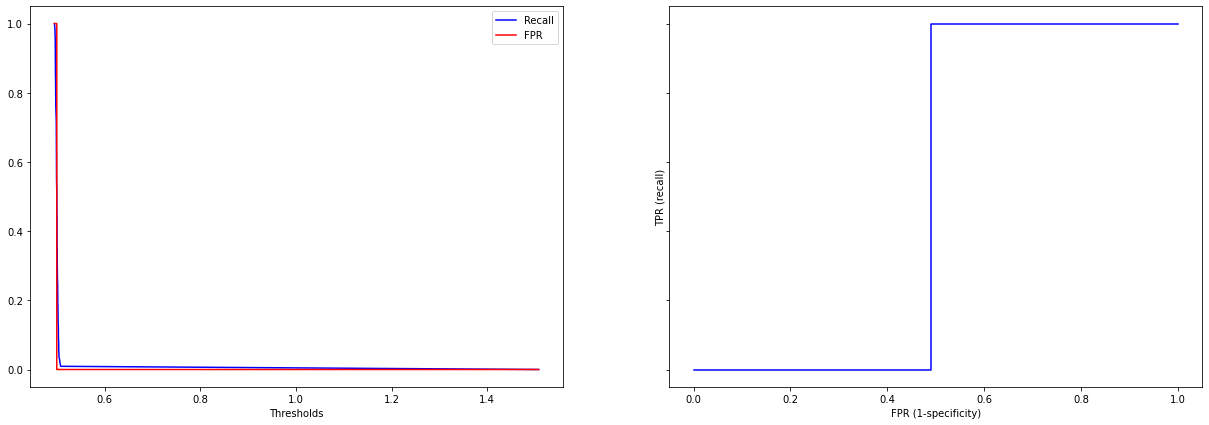

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.576222  0.540290   0.581901     0.612121  0.560309  0.608560
Validation  0.577906  0.530509   0.586031     0.625688  0.554878  0.619328


Random Forest (100 estimators)
╠■■■■■■■■■╣


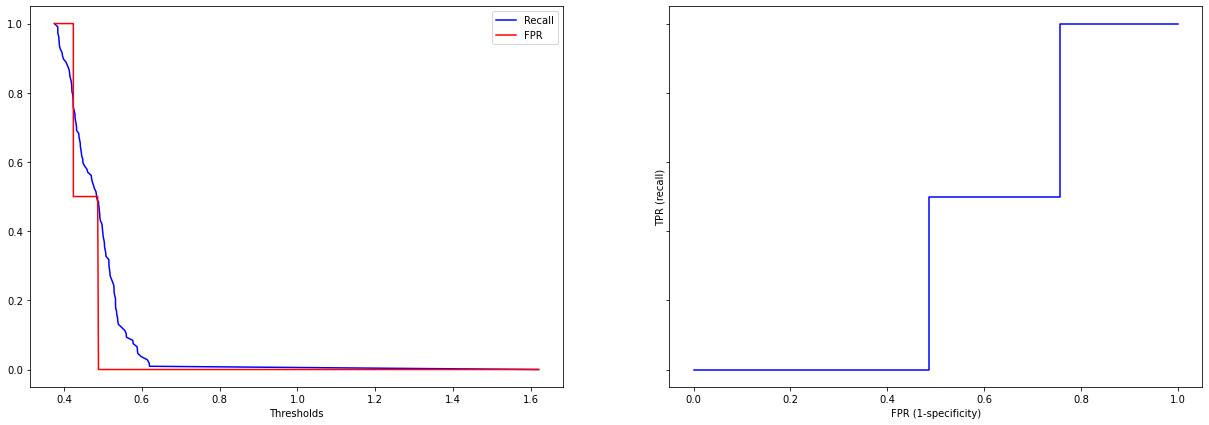

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.615078  0.576790   0.625208     0.653333  0.599302  0.664194
Validation  0.586123  0.547807   0.593326     0.624771  0.566093  0.633257


XGBoost Classifier
╠■■■■■■■■■╣


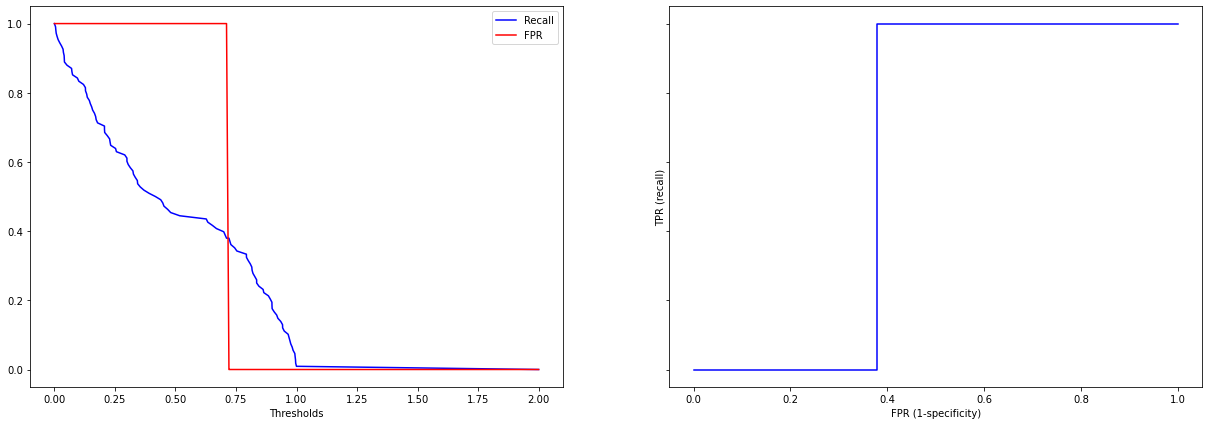

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997928  0.997169   0.998685     0.998687  0.997926  0.999988
Validation  0.540905  0.555980   0.542492     0.525688  0.547254  0.560493


SVM
╠■■■■■■■■■╣


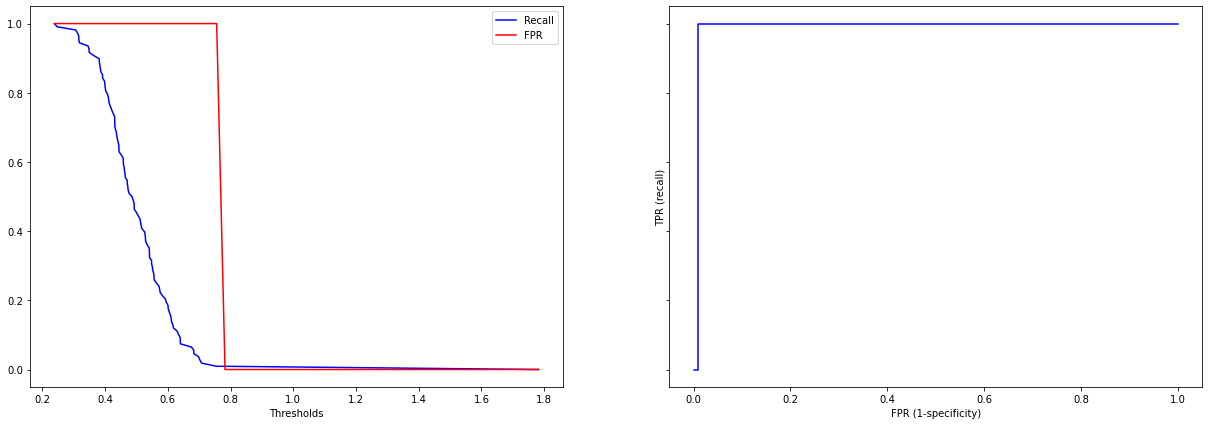

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.595473  0.540189   0.607133     0.650707  0.571677  0.641964
Validation  0.593438  0.539650   0.603309     0.647706  0.567115  0.632597


KNN
╠■■■■■■■■■╣


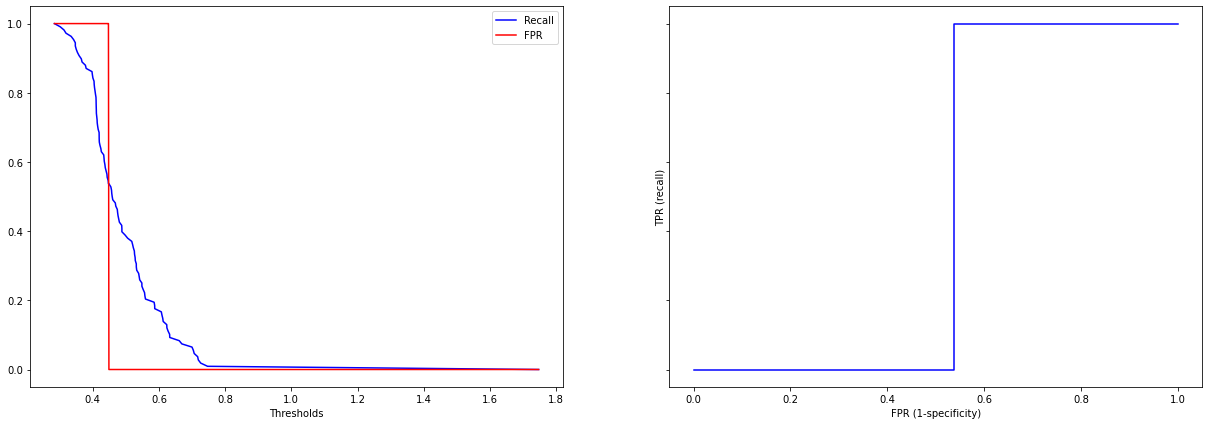

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998282  0.996664   0.999899     0.999899  0.998278  0.999993
Validation  0.572400  0.510450   0.583226     0.634862  0.540424  0.611860


Logistic Regression
╠■■■■■■■■■╣


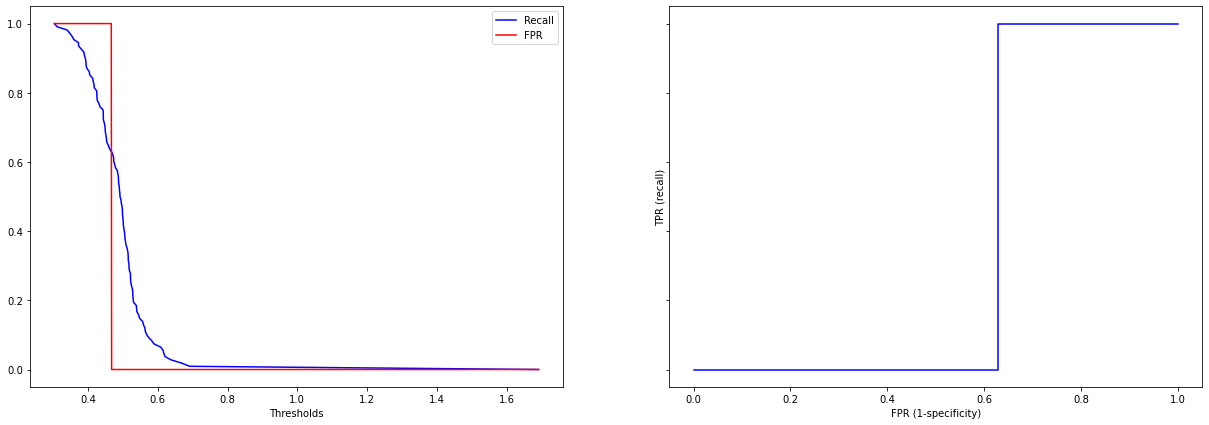

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.58941  0.551310   0.596569     0.627475  0.573036  0.634770
Validation   0.57928  0.550575   0.582904     0.608257  0.563945  0.628347

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.577906  0.530509   0.586031     0.625688   
Random Forest (100 estimators)  0.586123  0.547807   0.593326     0.624771   
XGBoost Classifier              0.540905  0.555980   0.542492     0.525688   
SVM                             0.593438  0.539650   0.603309     0.647706   
KNN                             0.572400  0.510450   0.583226     0.634862   
Logistic Regression             0.579280  0.550575   0.582904     0.608257   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.554878  0.619328  
Random Forest (100 estimators)  0.566093  0.633257  
XGBoost Classifier              0.547254  0.560493  
SVM                             0.567115  0.632597  
KNN                             0.540424  0.611860  
Logistic Regression             0.563945  0.628347

In [24]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

<b>Temperature</b>, <b>pulse</b> and <b>rr</b> are still the best features. <b>SVM</b> and <b>Logistic regression</b> improve significantly with standardized features.

Dummy Random
╠■■■■■■■■■╣


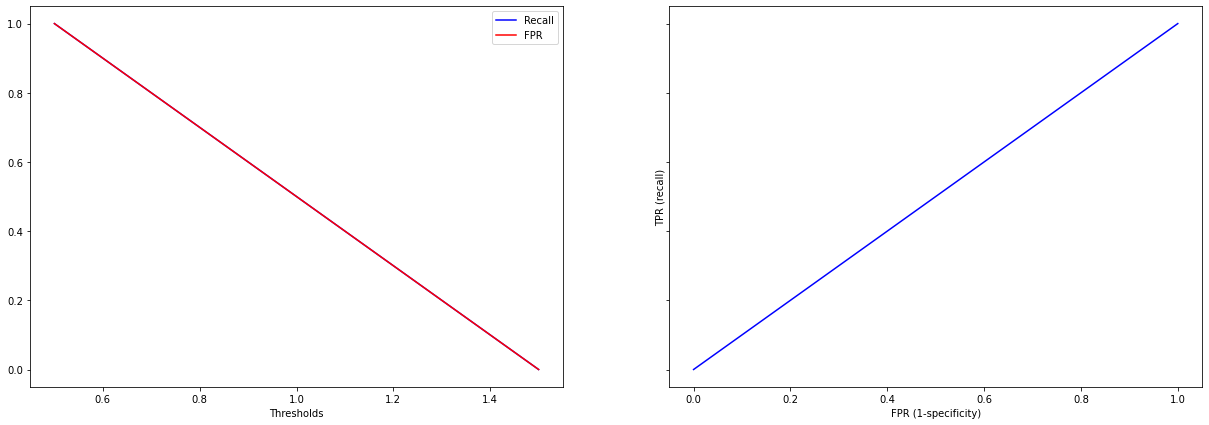

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


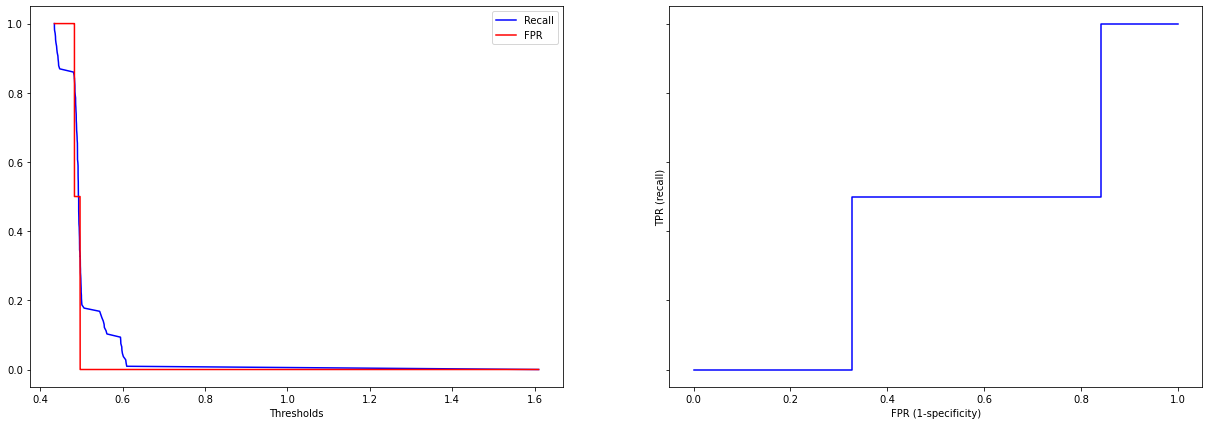

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.557021  0.486297   0.573079     0.627677  0.513617  0.583271
Validation  0.543611  0.460392   0.554026     0.627523  0.491992  0.563518


Random Forest (100 estimators)
╠■■■■■■■■■╣


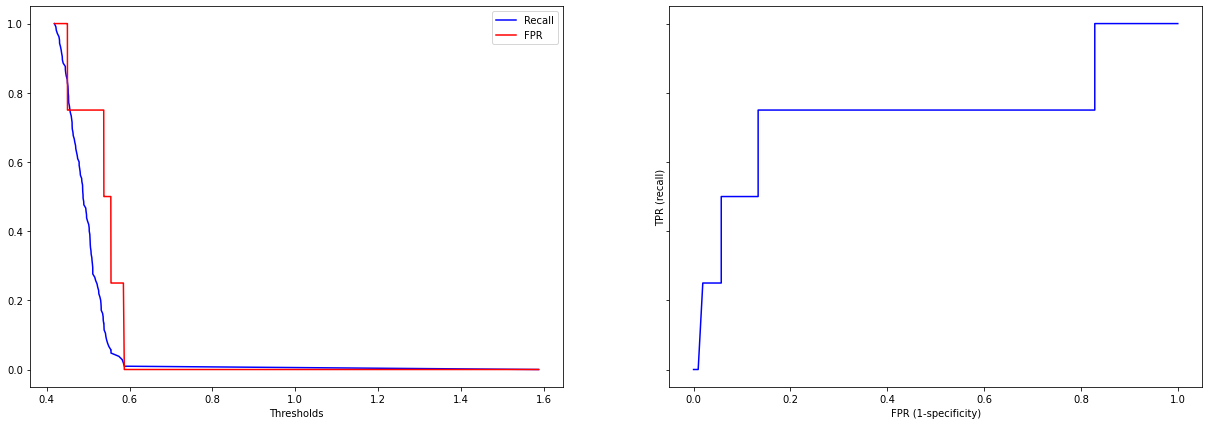

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.620282  0.582957   0.630263     0.657576  0.605175  0.673212
Validation  0.583842  0.540500   0.590825     0.627523  0.562662  0.622359


XGBoost Classifier
╠■■■■■■■■■╣


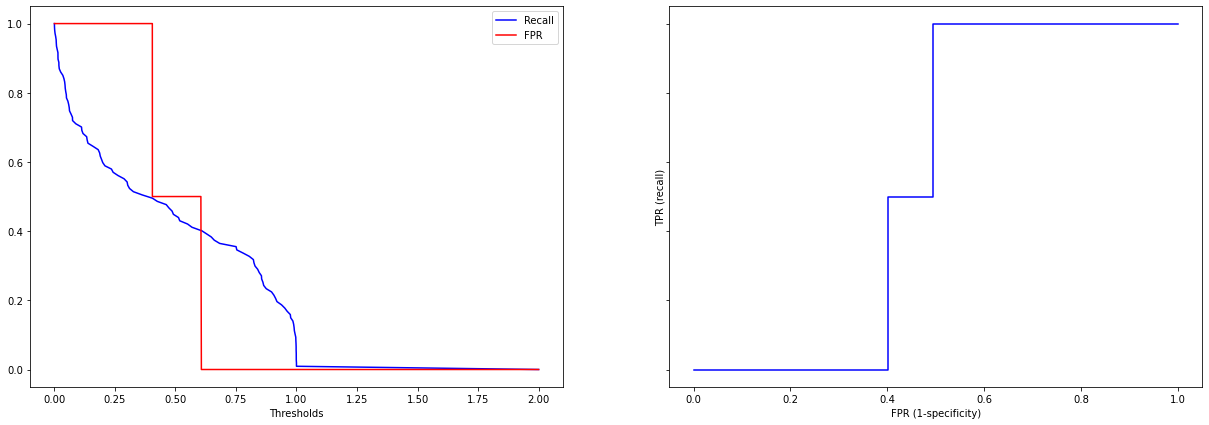

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999596  0.999494   0.999697     0.999697  0.999595  0.999999
Validation  0.549106  0.559600   0.548362     0.538532  0.553269  0.570690


SVM
╠■■■■■■■■■╣


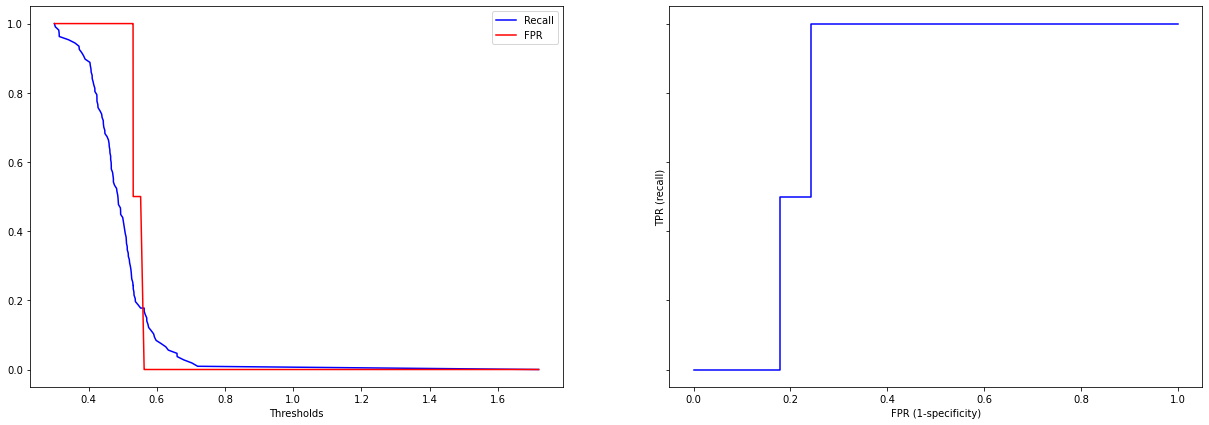

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.597798  0.545952   0.608933     0.649596  0.575575  0.646586
Validation  0.579289  0.540517   0.585280     0.618349  0.560512  0.627632


KNN
╠■■■■■■■■■╣


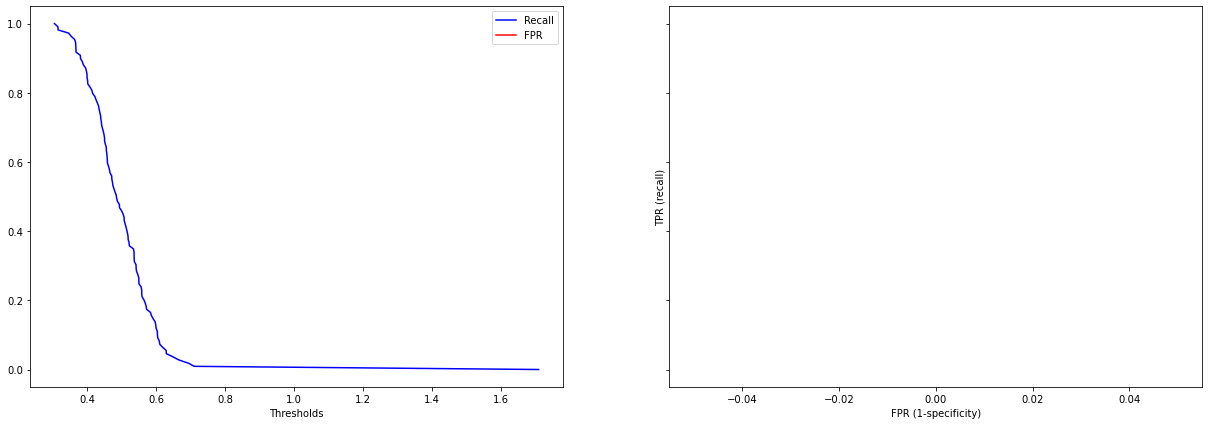

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999646  0.999292   1.000000     1.000000  0.999646  0.999999
Validation  0.570125  0.537731   0.577146     0.602752  0.555746  0.601621


Logistic Regression
╠■■■■■■■■■╣


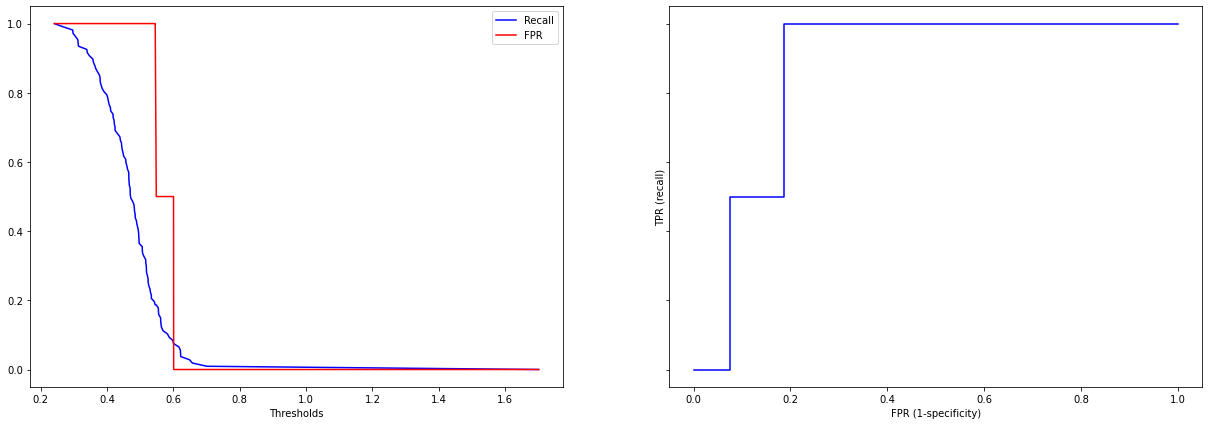

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.601738  0.570519   0.608385     0.632929  0.588782  0.646916
Validation  0.596611  0.555997   0.604559     0.637615  0.577175  0.645309

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.543611  0.460392   0.554026     0.627523   
Random Forest (100 estimators)  0.583842  0.540500   0.590825     0.627523   
XGBoost Classifier              0.549106  0.559600   0.548362     0.538532   
SVM                             0.579289  0.540517   0.585280     0.618349   
KNN                             0.570125  0.537731   0.577146     0.602752   
Logistic Regression             0.596611  0.555997   0.604559     0.637615   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.491992  0.563518  
Random Forest (100 estimators)  0.562662  0.622359  
XGBoost Classifier              0.553269  0.570690  
SVM                             0.560512  0.627632  
KNN                             0.555746  0.601621  
Logistic Regression             0.577175  0.645309

In [25]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

For almost all models, the vitals had more importance than all of the epidemiological factors, of which <b>high_risk_exposure_occupation</b> seems to be the most influential again. For tree-based models (<b>Random forest</b> and <b>XGBoost</b>) however, <b>age</b> played a significant role. Since all of the important vitals follow a normal distribution, <b>standardization</b> will be used for them.

### Assesed Symptoms

In [17]:
a_symptoms.dropna(how="all", inplace=True)
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


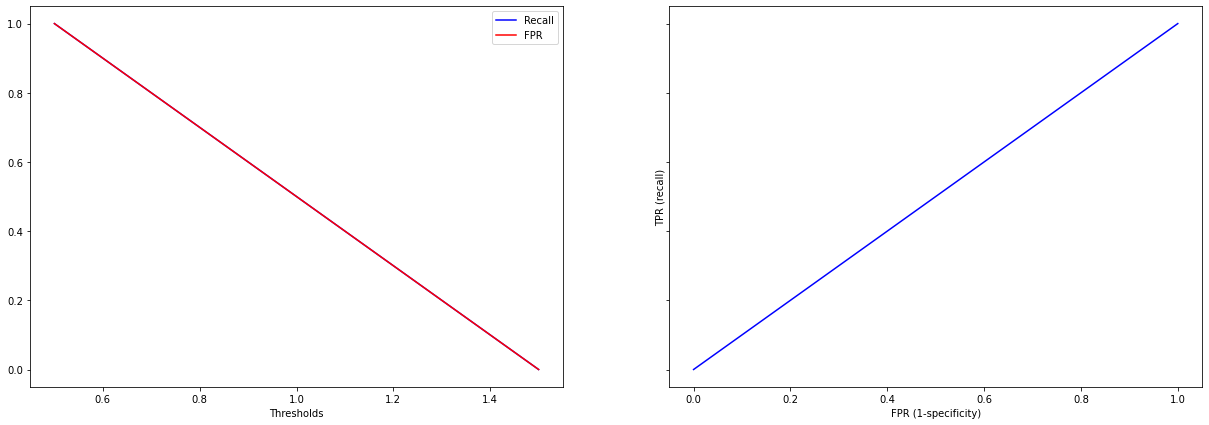

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


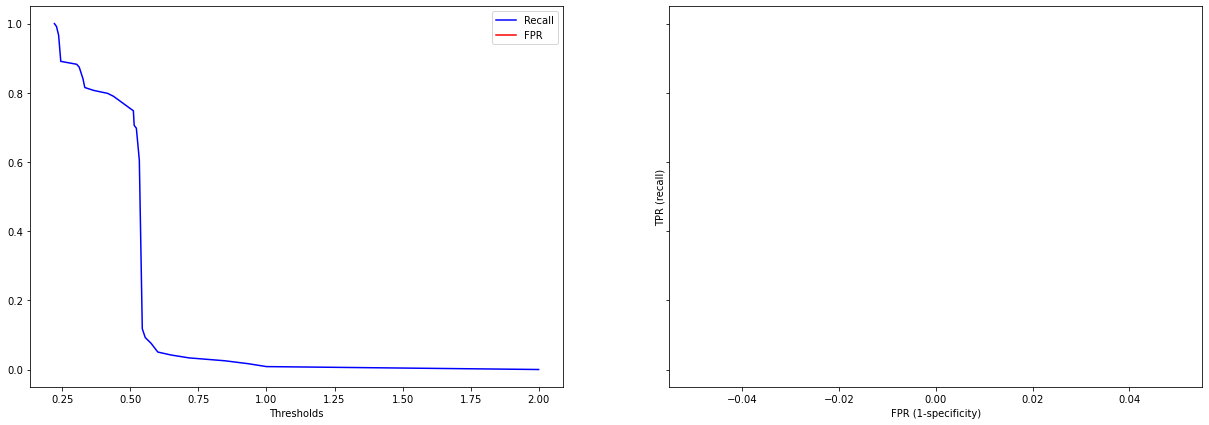

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.544024  0.848001   0.527352     0.240130  0.650288  0.549376
Validation  0.535408  0.843102   0.521764     0.226891  0.644318  0.539985


Random Forest (100 estimators)
╠■■■■■■■■■╣


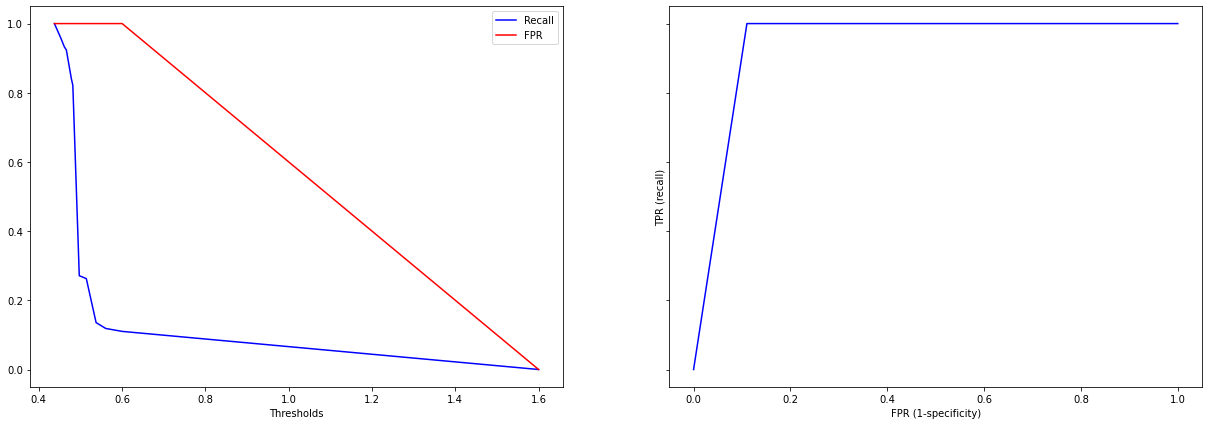

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.587839  0.392569   0.644072     0.783054  0.487728  0.611203
Validation  0.582063  0.387276   0.632284     0.777311  0.478681  0.600498


XGBoost Classifier
╠■■■■■■■■■╣


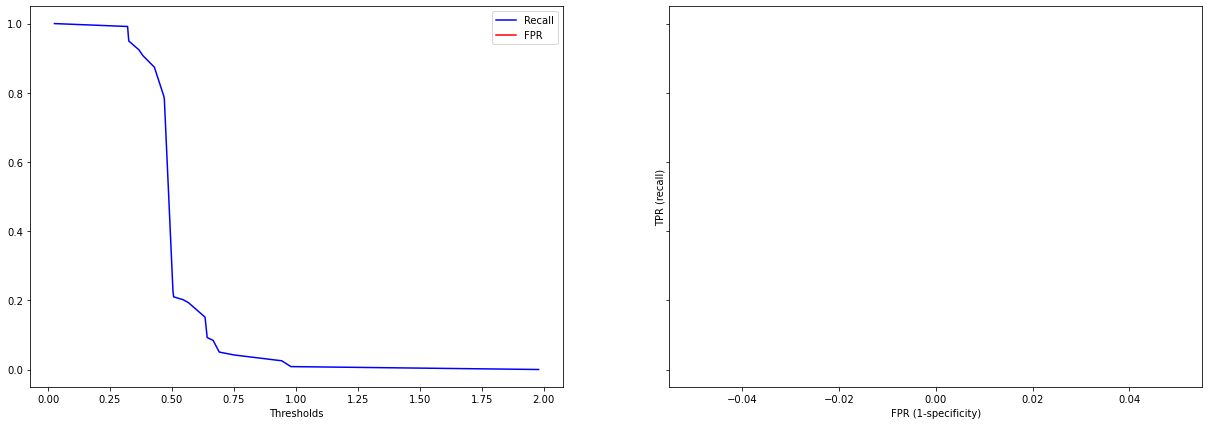

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.605811  0.407843   0.675341     0.803724  0.508435  0.641344
Validation  0.586250  0.388992   0.640469     0.784034  0.483271  0.595167


SVM
╠■■■■■■■■■╣


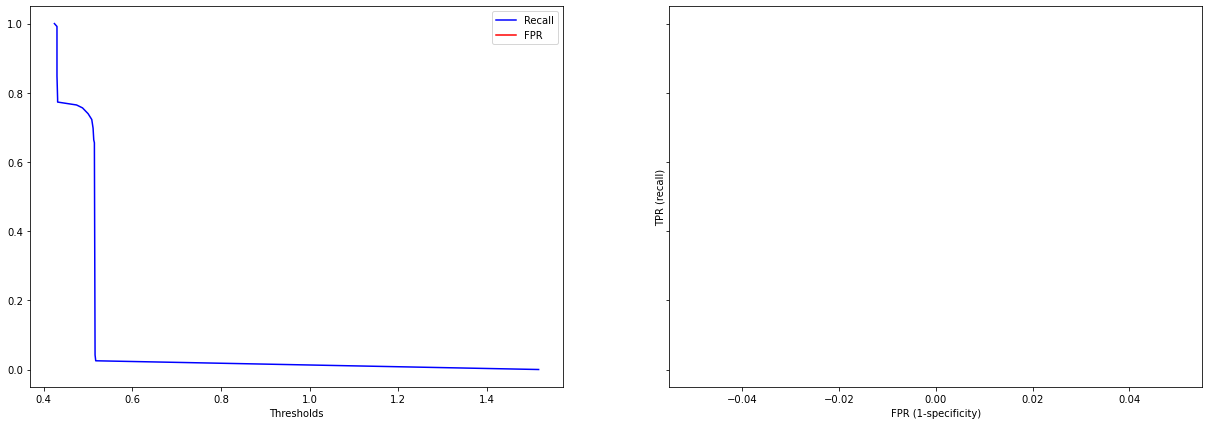

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.530892  0.787601   0.513866     0.274209  0.605260  0.534650
Validation  0.521650  0.761583   0.477195     0.281513  0.583438  0.537633


KNN
╠■■■■■■■■■╣


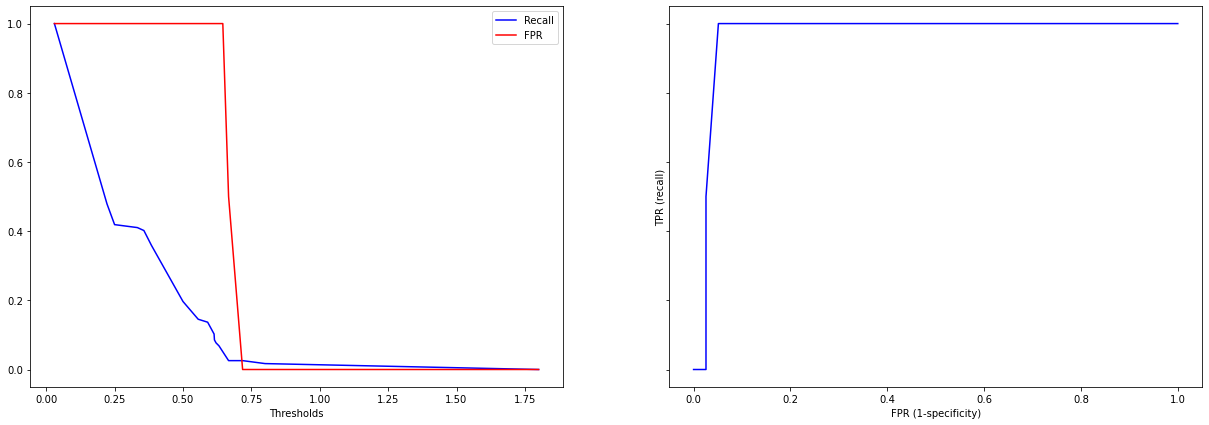

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.604787  0.400298   0.677338     0.809218  0.503065  0.596179
Validation  0.582045  0.383137   0.636954     0.781513  0.477048  0.565733


Logistic Regression
╠■■■■■■■■■╣


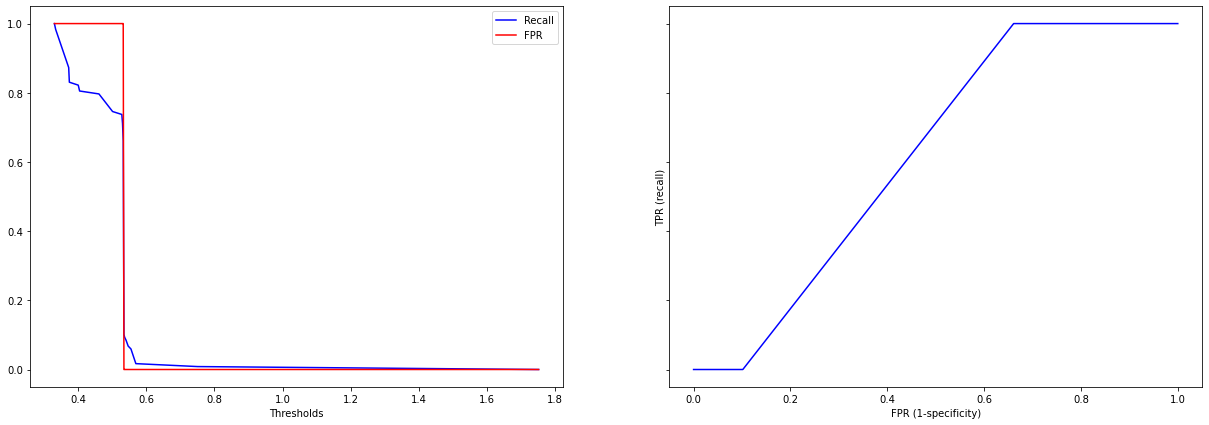

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.542348  0.832634   0.526739     0.252142  0.645226  0.544843
Validation  0.535880  0.830602   0.523014     0.240336  0.641647  0.525187

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.535408  0.843102   0.521764     0.226891   
Random Forest (100 estimators)  0.582063  0.387276   0.632284     0.777311   
XGBoost Classifier              0.586250  0.388992   0.640469     0.784034   
SVM                             0.521650  0.761583   0.477195     0.281513   
KNN                             0.582045  0.383137   0.636954     0.781513   
Logistic Regression             0.535880  0.830602   0.523014     0.240336   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.644318  0.539985  
Random Forest (100 estimators)  0.478681  0.600498  
XGBoost Classifier              0.483271  0.595167  
SVM                             0.583438  0.537633  
KNN                             0.477048  0.565733  
Logistic Regression             0.641647  0.525187

In [27]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

The most important features here seem to be <b>wheezes</b>, <b>ctab</b> and <b>labored respiration</b>

Dummy Random
╠■■■■■■■■■╣


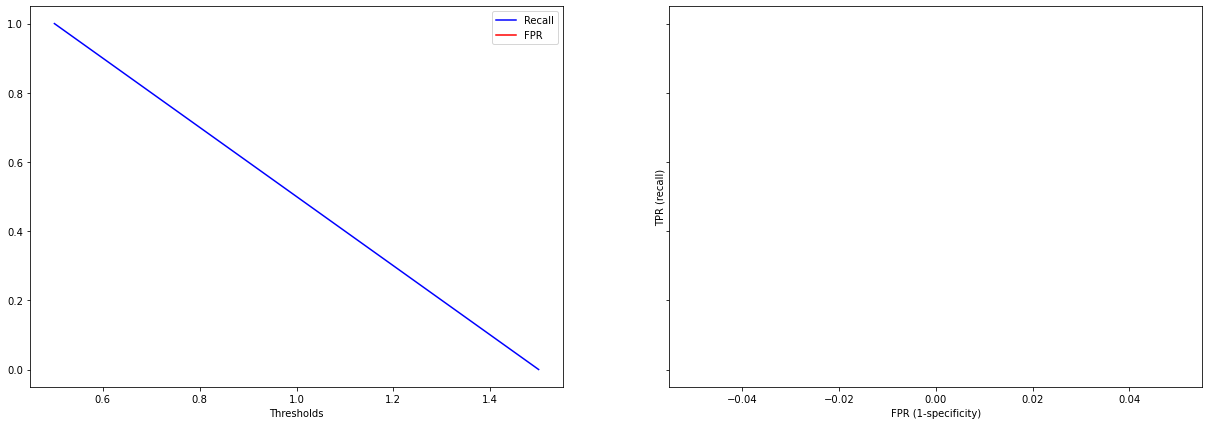

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


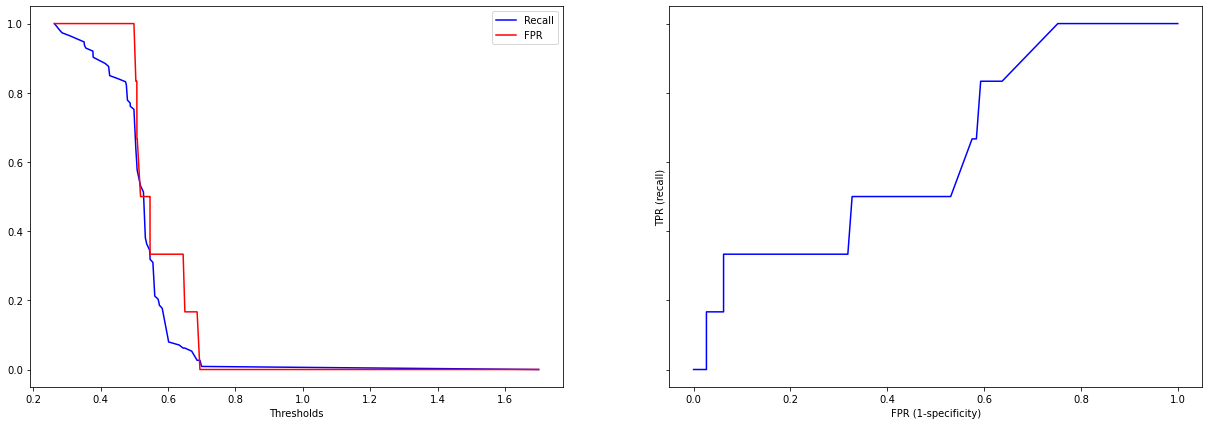

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.551333  0.728969   0.537338     0.373743  0.616048  0.569878
Validation  0.537525  0.718221   0.527865     0.356303  0.606860  0.554344


Random Forest (100 estimators)
╠■■■■■■■■■╣


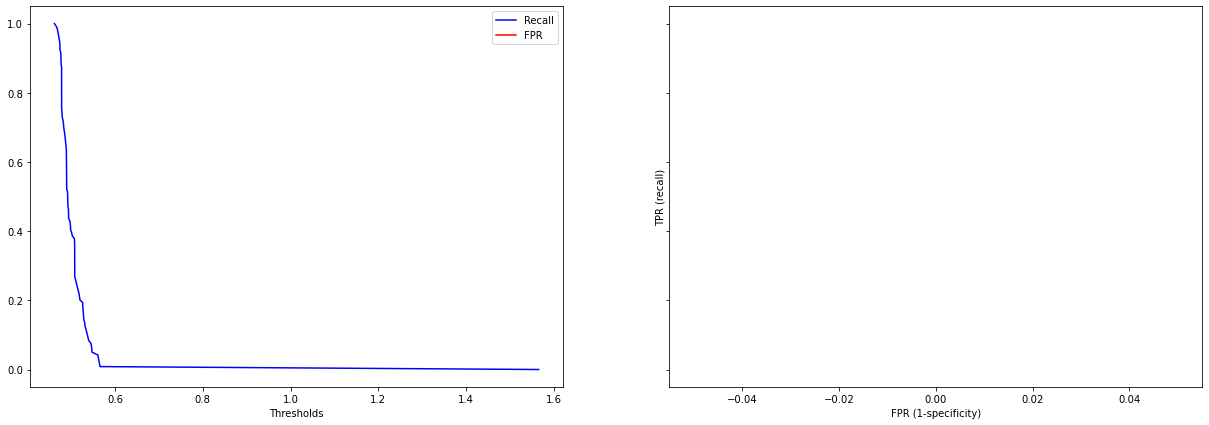

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591423  0.548581   0.602828     0.634264  0.570977  0.632535
Validation  0.583295  0.533032   0.595465     0.633613  0.560155  0.620574


XGBoost Classifier
╠■■■■■■■■■╣


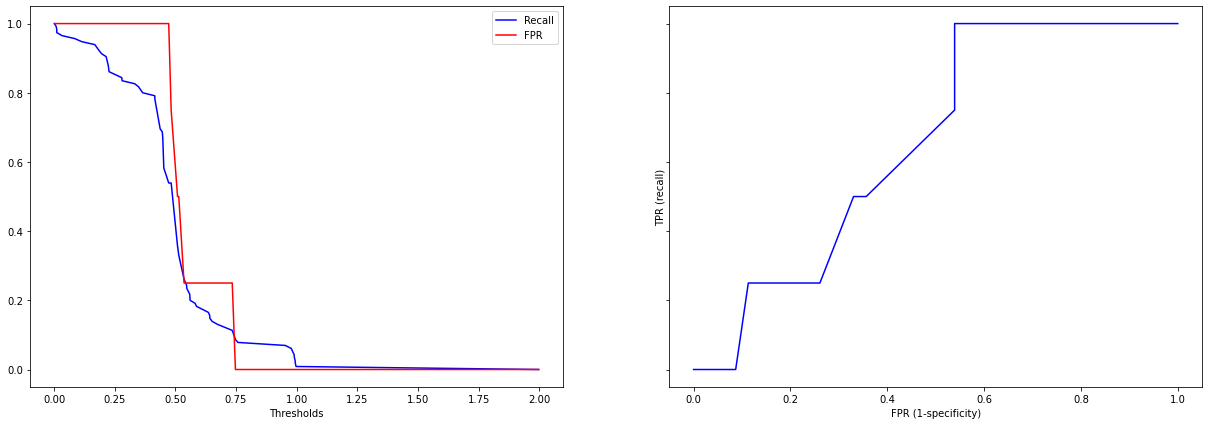

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.645435  0.601840   0.667994     0.689013  0.625347  0.723594
Validation  0.565240  0.511261   0.576716     0.619328  0.534665  0.596660


SVM
╠■■■■■■■■■╣


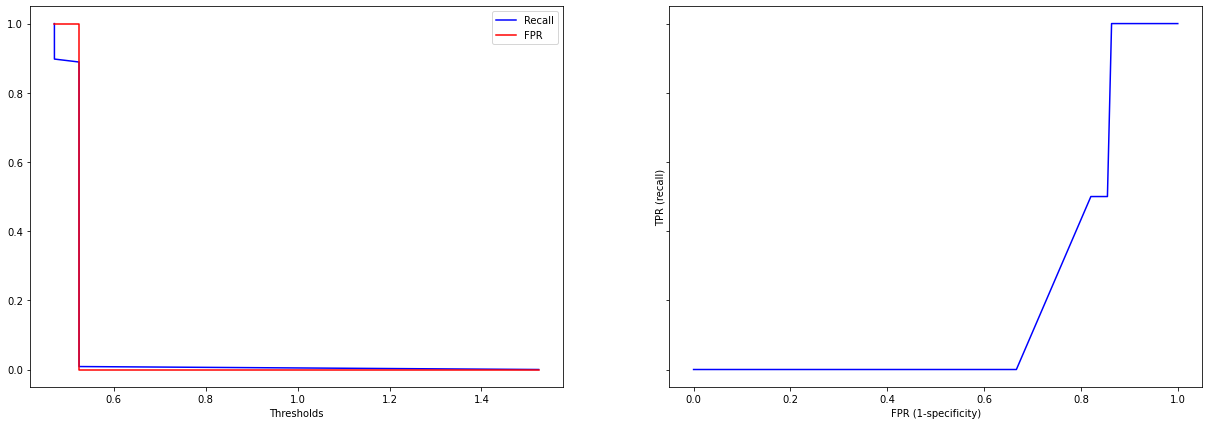

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.552033  0.672926   0.551567     0.431192  0.582220  0.574001
Validation  0.527907  0.636926   0.525255     0.418487  0.557171  0.542592


KNN
╠■■■■■■■■■╣


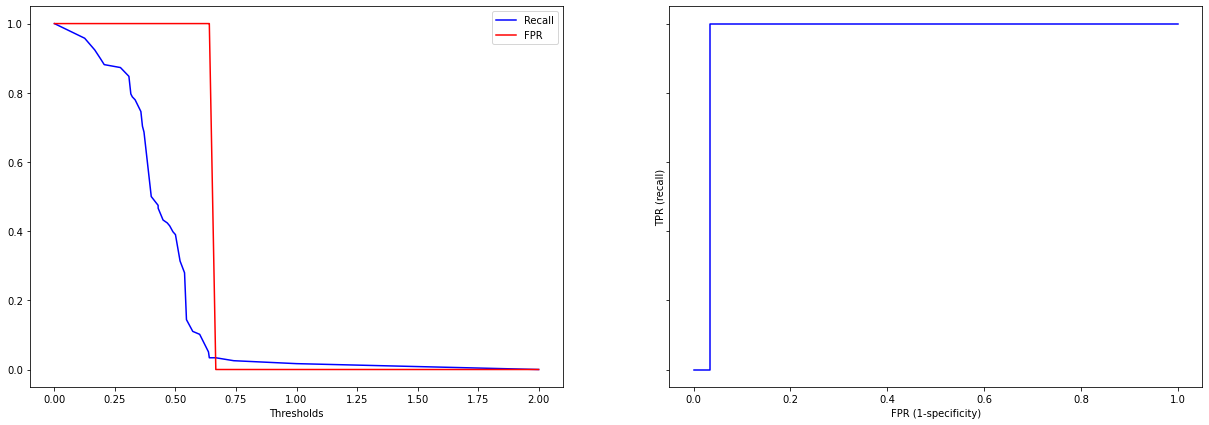

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.644644  0.443139   0.742548     0.846089  0.554828  0.681923
Validation  0.578260  0.366275   0.637432     0.790756  0.464601  0.578462


Logistic Regression
╠■■■■■■■■■╣


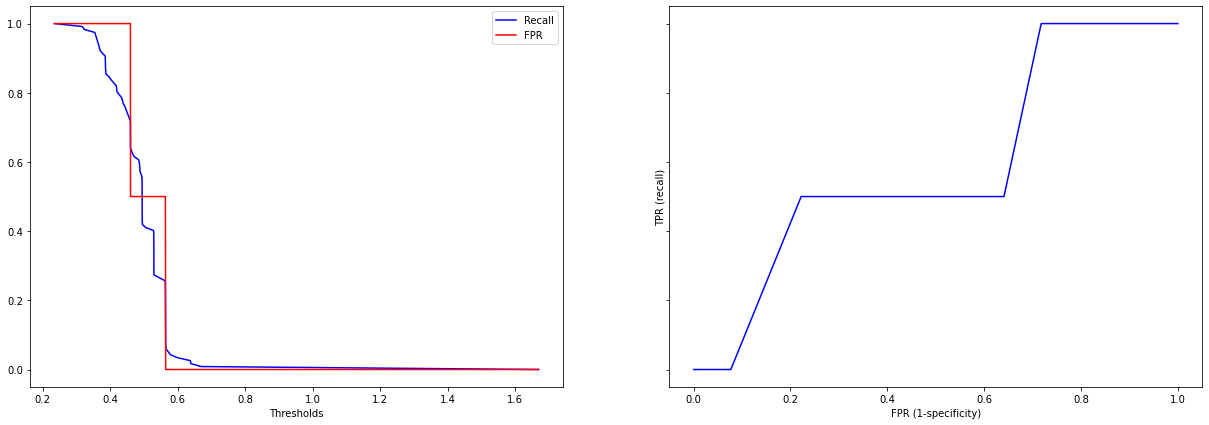

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.564045  0.724506   0.548685     0.403631  0.623695  0.585546
Validation  0.560216  0.718284   0.546595     0.401681  0.619207  0.573820

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.537525  0.718221   0.527865     0.356303   
Random Forest (100 estimators)  0.583295  0.533032   0.595465     0.633613   
XGBoost Classifier              0.565240  0.511261   0.576716     0.619328   
SVM                             0.527907  0.636926   0.525255     0.418487   
KNN                             0.578260  0.366275   0.637432     0.790756   
Logistic Regression             0.560216  0.718284   0.546595     0.401681   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.606860  0.554344  
Random Forest (100 estimators)  0.560155  0.620574  
XGBoost Classifier              0.534665  0.596660  
SVM                             0.557171  0.542592  
KNN                             0.464601  0.578462  
Logistic Regression             0.619207  0.573820

In [28]:
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

Adding the epidemiological factors doesn't seem to make much difference in performance metrics. However, <b>days_since_symptom_onset</b> appears to become more important after adding the factors.

### Reported symptoms

In [19]:
r_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough           51684 non-null  object 
 1   cough_severity  51684 non-null  float64
 2   fever           48445 non-null  object 
 3   sob             51602 non-null  object 
 4   sob_severity    51602 non-null  float64
 5   diarrhea        51619 non-null  object 
 6   fatigue         51630 non-null  object 
 7   headache        51623 non-null  object 
 8   loss_of_smell   51616 non-null  object 
 9   loss_of_taste   51616 non-null  object 
 10  runny_nose      51619 non-null  object 
 11  muscle_sore     51624 non-null  object 
 12  sore_throat     51623 non-null  object 
dtypes: float64(2), object(11)
memory usage: 7.5+ MB


In [20]:
#All datasets that contain reported symptoms
r_symptoms.dropna(how="all", inplace=True)
ra_symptoms = pd.merge(r_symptoms, a_symptoms, left_index=True, right_index=True)
r_symptoms_ex = pd.merge(r_symptoms, e_factors, left_index=True, right_index=True)
r_symptoms_vitals = pd.merge(r_symptoms, vitals, left_index=True, right_index=True)
r_symptoms_svitals = pd.merge(r_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
ra_symptoms_nvitals = pd.merge(ra_symptoms, n_vitals, left_index=True, right_index=True)
ra_symptoms_svitals = pd.merge(ra_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals_ex = pd.merge(ra_symptoms_vitals, e_factors, left_index=True, right_index=True)
ra_symptoms_nvitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)
ra_symptoms_svitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


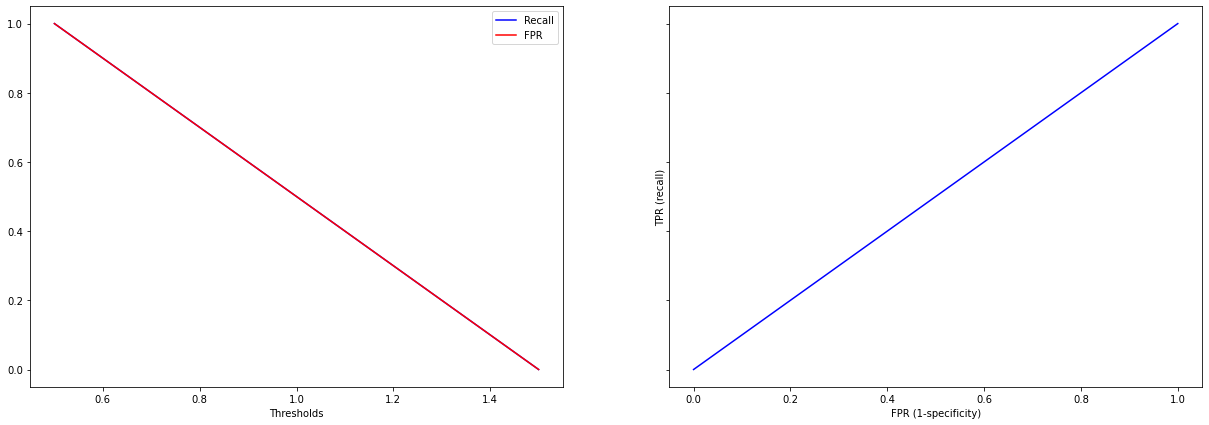

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


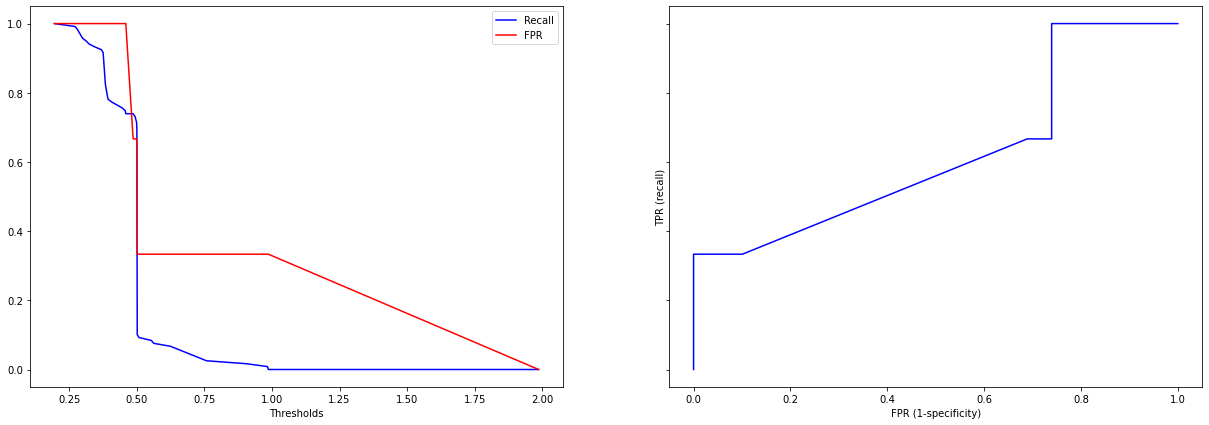

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.630603  0.360884   0.783576     0.900273  0.494079  0.613021
Validation  0.633068  0.359130   0.794185     0.907377  0.490340  0.617373


Random Forest (100 estimators)
╠■■■■■■■■■╣


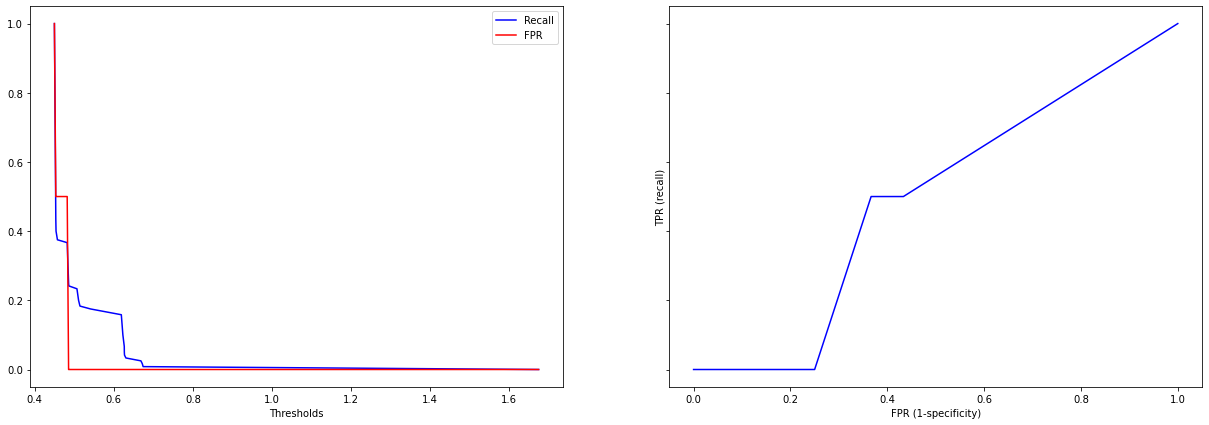

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.634058  0.434990   0.723274     0.833091  0.542846  0.666399
Validation  0.635955  0.429555   0.728250     0.842623  0.536611  0.675053


XGBoost Classifier
╠■■■■■■■■■╣


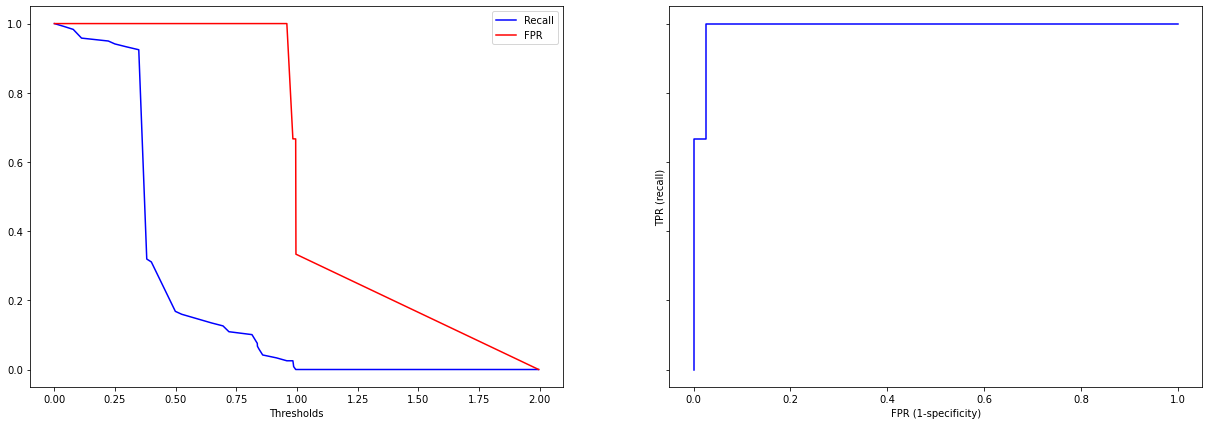

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703155  0.502637   0.839312     0.903636  0.628538  0.754808
Validation  0.640033  0.449993   0.725036     0.830328  0.553250  0.637647


SVM
╠■■■■■■■■■╣


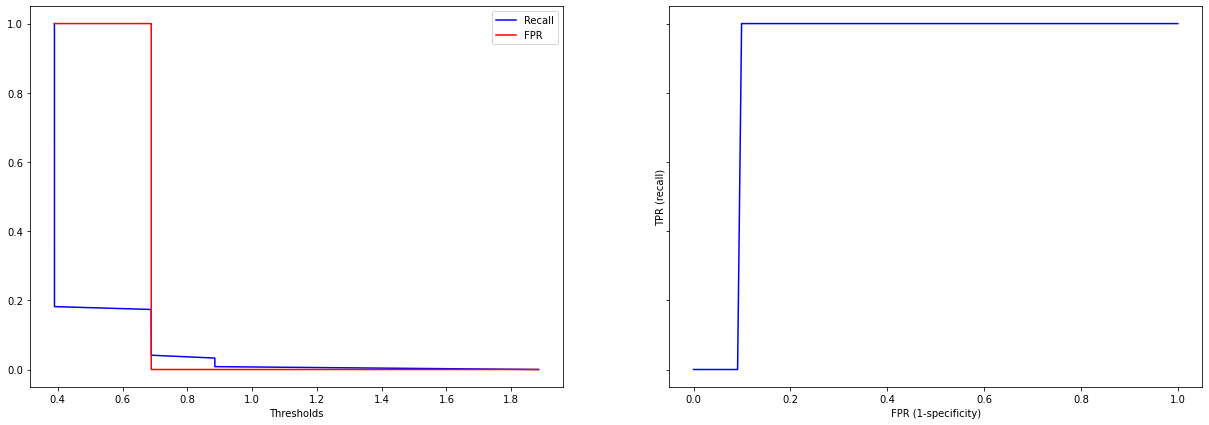

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.651968  0.442439   0.762694     0.861455  0.558936  0.686914
Validation  0.643707  0.442650   0.738038     0.845082  0.550275  0.668882


KNN
╠■■■■■■■■■╣


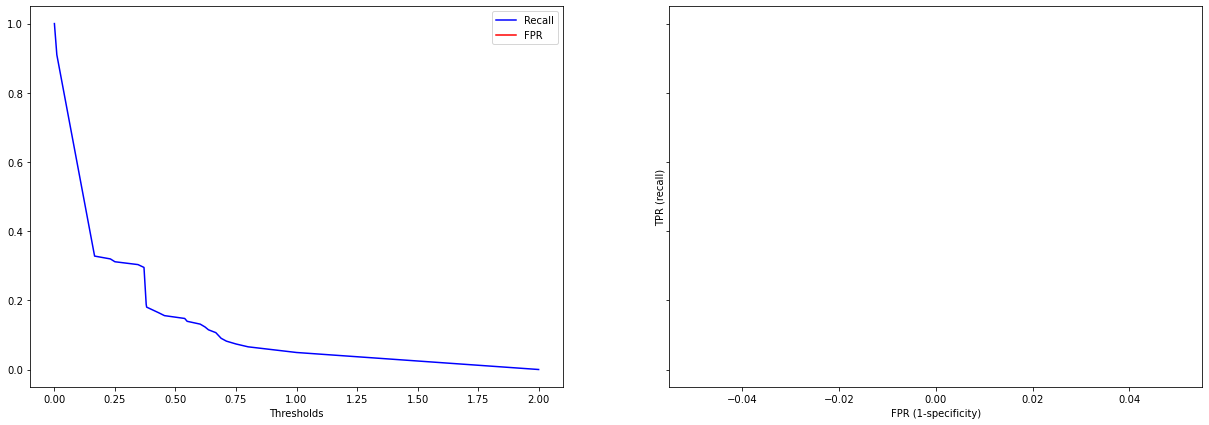

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703518  0.487451   0.858654     0.919545  0.621623  0.737939
Validation  0.640035  0.427889   0.741147     0.852459  0.540638  0.650661


Logistic Regression
╠■■■■■■■■■╣


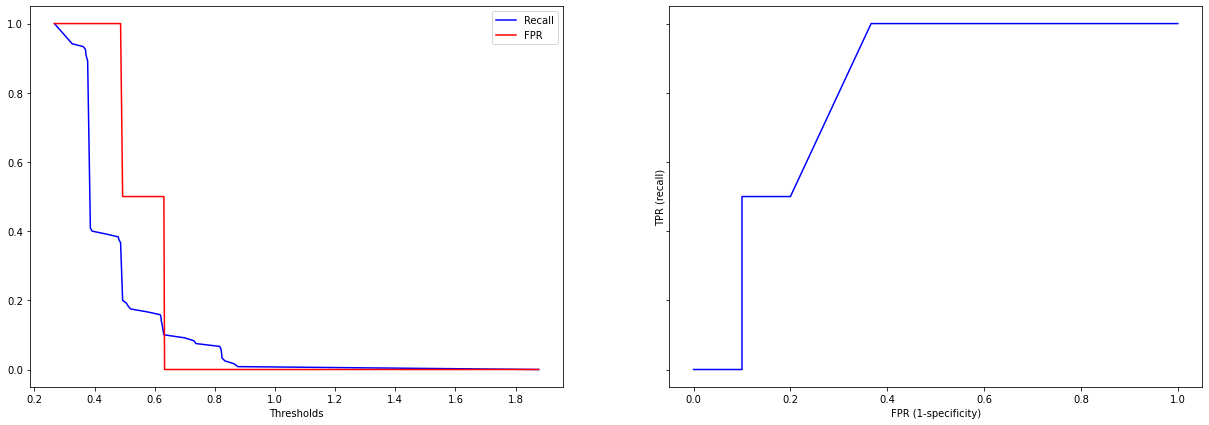

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662787  0.489815   0.750759     0.835727  0.592024  0.691248
Validation  0.659261  0.487652   0.742631     0.831148  0.583761  0.691635

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.633068  0.359130   0.794185     0.907377   
Random Forest (100 estimators)  0.635955  0.429555   0.728250     0.842623   
XGBoost Classifier              0.640033  0.449993   0.725036     0.830328   
SVM                             0.643707  0.442650   0.738038     0.845082   
KNN                             0.640035  0.427889   0.741147     0.852459   
Logistic Regression             0.659261  0.487652   0.742631     0.831148   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.490340  0.617373  
Random Forest (100 estimators)  0.536611  0.675053  
XGBoost Classifier              0.553250  0.637647  
SVM                             0.550275  0.668882  
KNN                             0.540638  0.650661  
Logistic Regression             0.583761  0.691635

In [31]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Not surprisingly, <b>cough</b> and <b>cough_severity</b> seem to be the most important ones. Also, almost <b>all of them</b> seem to be <b>relevant</b> for some model, <b>except</b> for <b>diarreah</b> and <b>runny_nose</b>.

Dummy Random
╠■■■■■■■■■╣


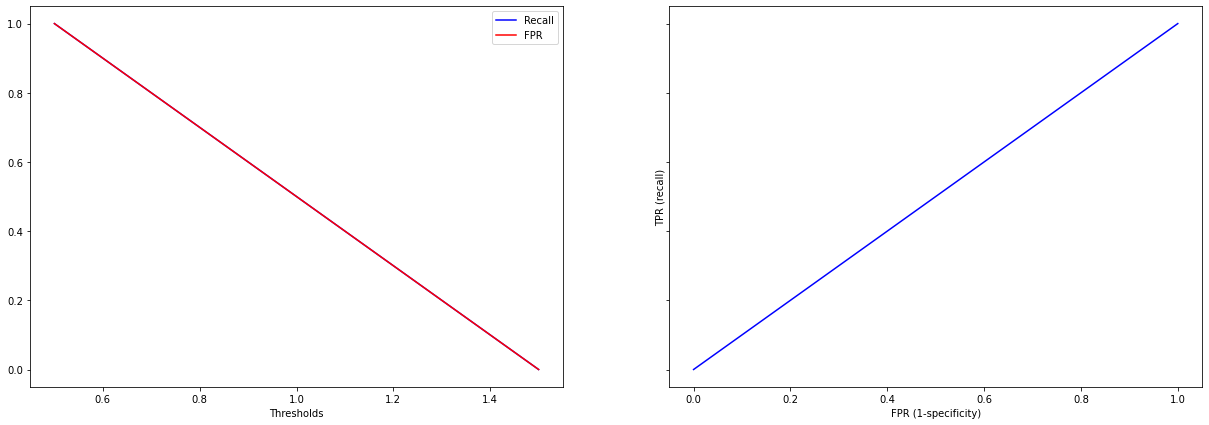

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


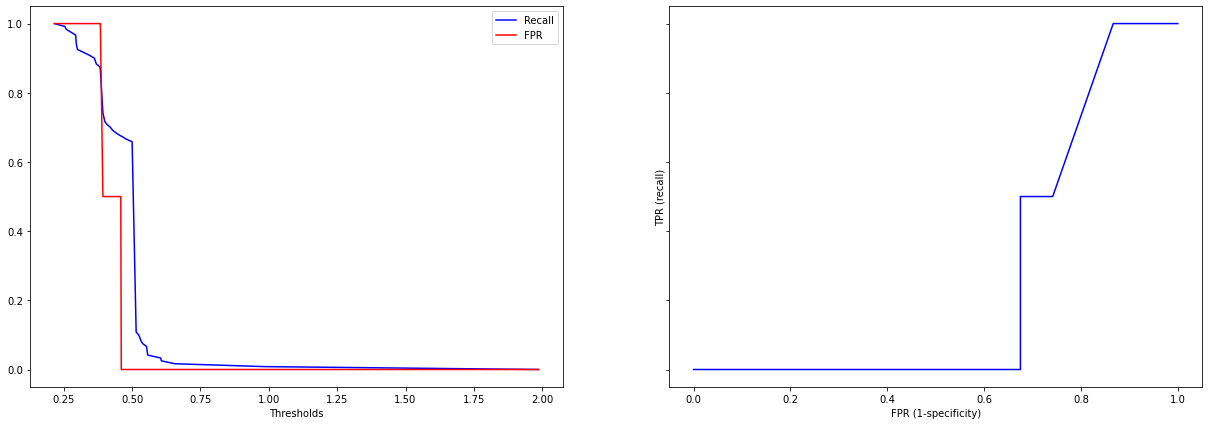

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.619692  0.337332   0.775249        0.902  0.469907  0.595917
Validation  0.619946  0.340291   0.768949        0.900  0.467457  0.599896


Random Forest (100 estimators)
╠■■■■■■■■■╣


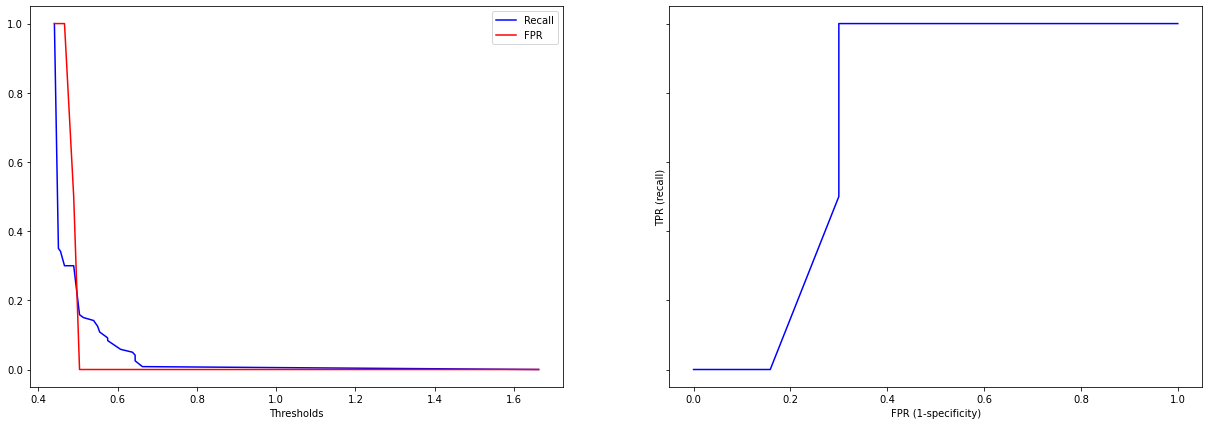

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.640012  0.471993   0.711129     0.808000  0.56710  0.666473
Validation  0.635120  0.463128   0.704619     0.807377  0.55396  0.664549


XGBoost Classifier
╠■■■■■■■■■╣


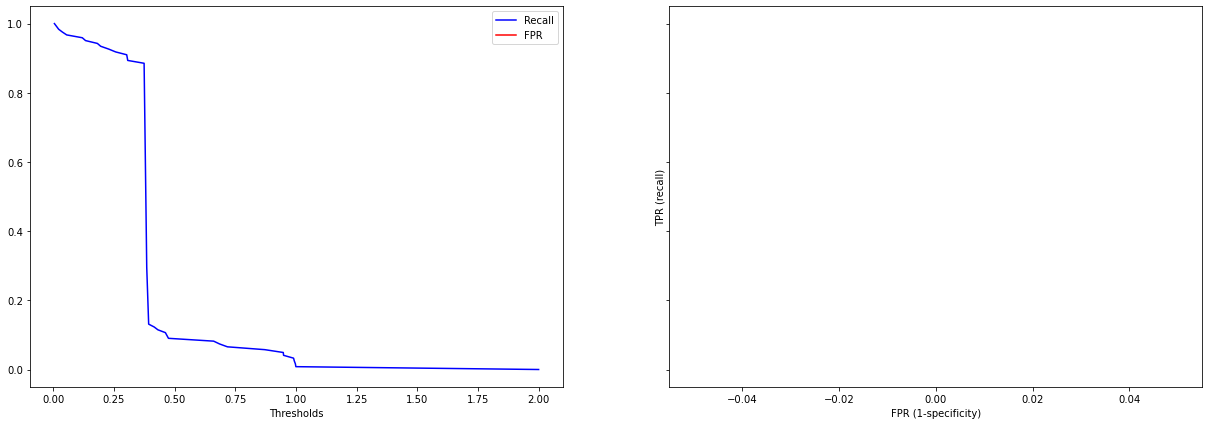

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.705882  0.503091   0.846567     0.908636  0.631001  0.758081
Validation  0.643712  0.431981   0.744298     0.855738  0.543982  0.657989


SVM
╠■■■■■■■■■╣


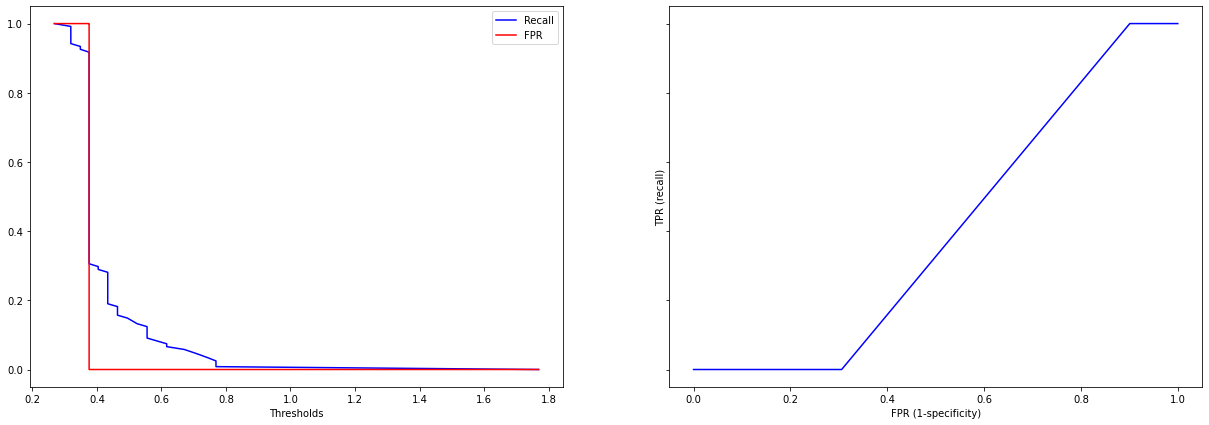

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.658605  0.512736   0.729143     0.804455  0.599550  0.688162
Validation  0.651126  0.497501   0.720887     0.804918  0.581903  0.673967


KNN
╠■■■■■■■■■╣


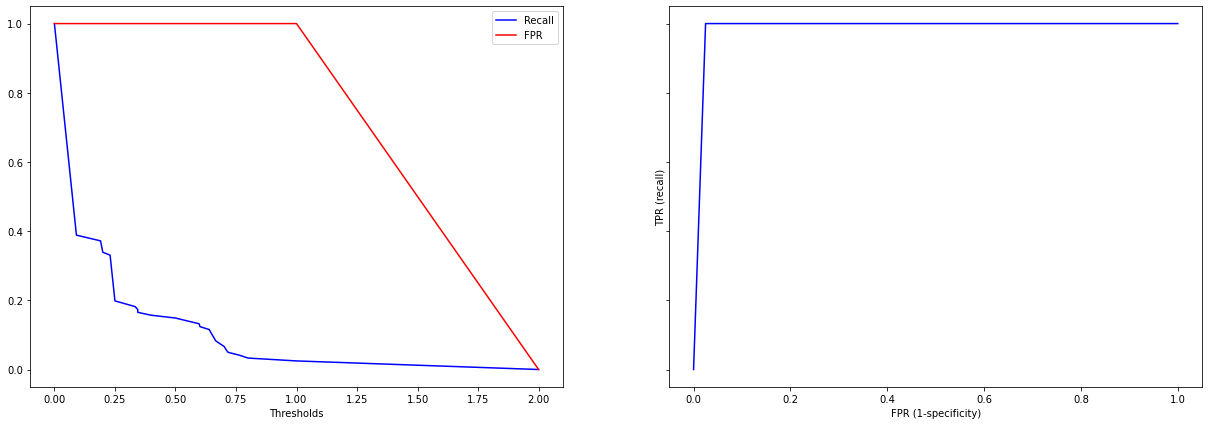

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.701518  0.477815   0.865082     0.925182  0.615350  0.736323
Validation  0.645773  0.431181   0.755120     0.860656  0.545742  0.657295


Logistic Regression
╠■■■■■■■■■╣


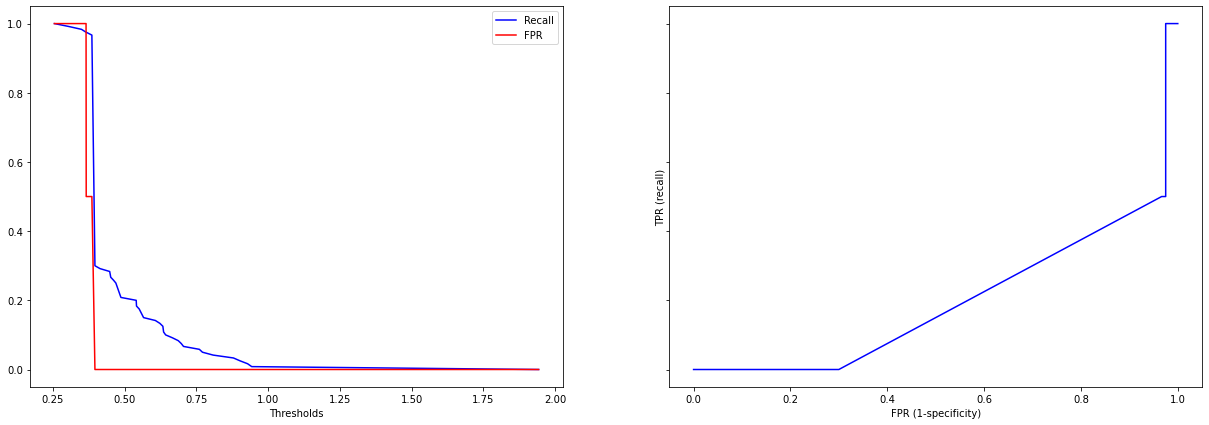

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659742  0.496641   0.741199     0.822818  0.592768  0.692049
Validation  0.643727  0.488485   0.710146     0.799180  0.573401  0.674928

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.619946  0.340291   0.768949     0.900000   
Random Forest (100 estimators)  0.635120  0.463128   0.704619     0.807377   
XGBoost Classifier              0.643712  0.431981   0.744298     0.855738   
SVM                             0.651126  0.497501   0.720887     0.804918   
KNN                             0.645773  0.431181   0.755120     0.860656   
Logistic Regression             0.643727  0.488485   0.710146     0.799180   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.467457  0.599896  
Random Forest (100 estimators)  0.553960  0.664549  
XGBoost Classifier              0.543982  0.657989  
SVM                             0.581903  0.673967  
KNN                             0.545742  0.657295  
Logistic Regression             0.573401  0.674928

In [32]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

In almost all models performance went down if we removed the booleanw <b>cough</b> and <b>sob</b> in favor of the graded <b>cough_severity</b>.


Dummy Random
╠■■■■■■■■■╣


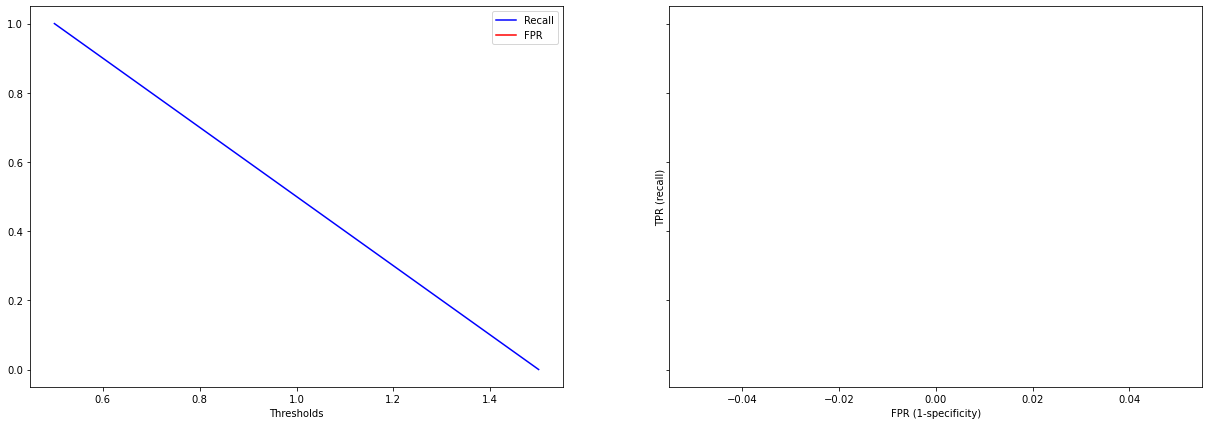

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


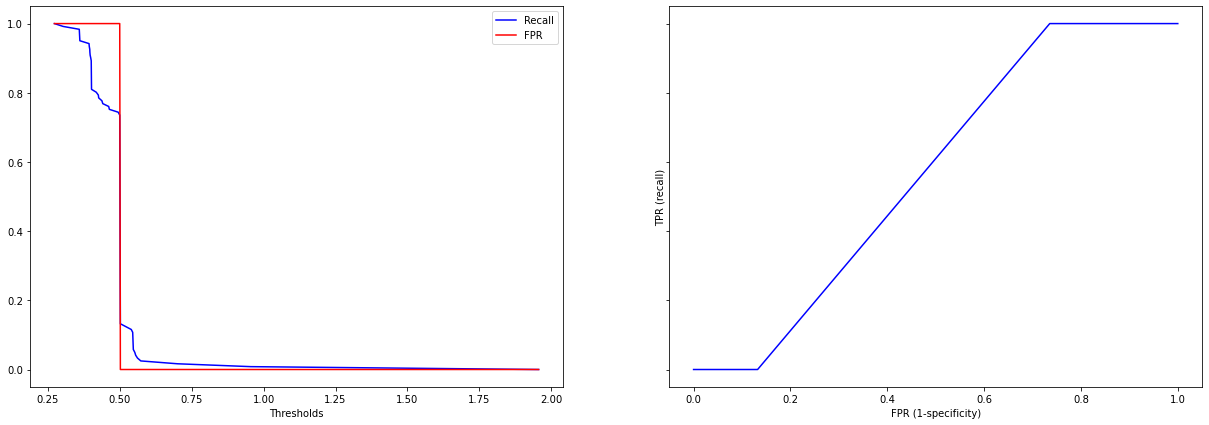

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.620102  0.331422   0.784263     0.908727  0.465438  0.596117
Validation  0.601111  0.319865   0.729408     0.882787  0.442405  0.581625


Random Forest (100 estimators)
╠■■■■■■■■■╣


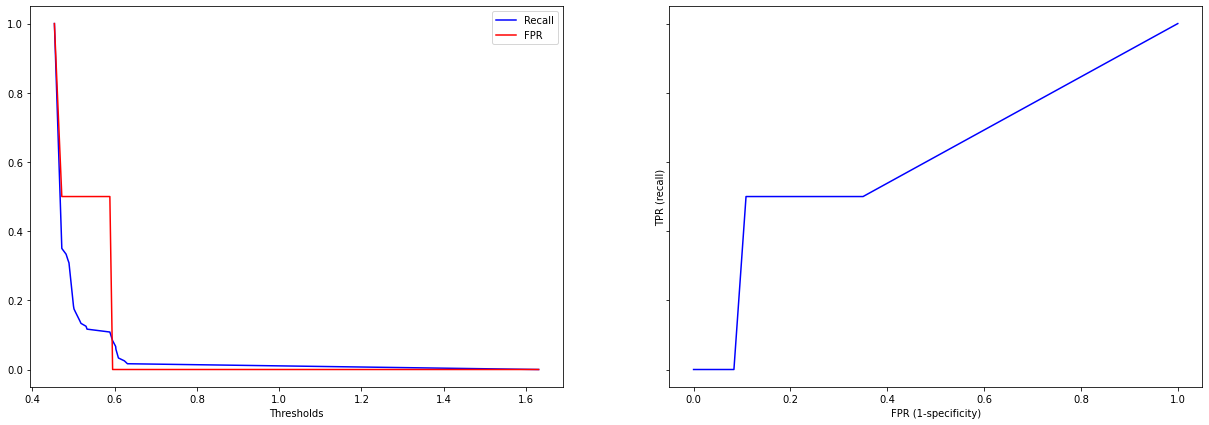

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.640194  0.475449   0.709335     0.804909  0.568910  0.666419
Validation  0.636766  0.472124   0.700229     0.801639  0.561202  0.661992


XGBoost Classifier
╠■■■■■■■■■╣


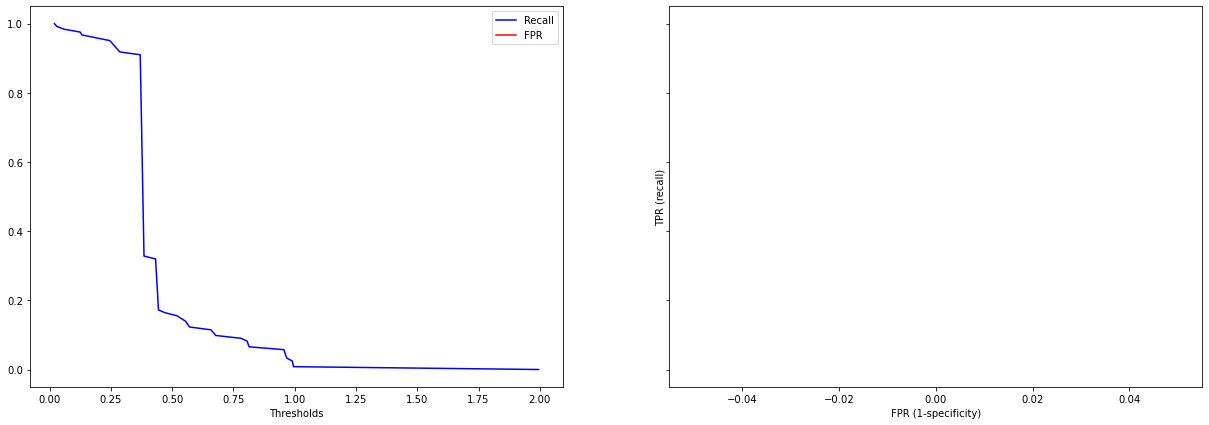

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.695790  0.502544   0.819400      0.88900  0.622661  0.746001
Validation  0.649036  0.449220   0.747453      0.84918  0.559340  0.667737


SVM
╠■■■■■■■■■╣


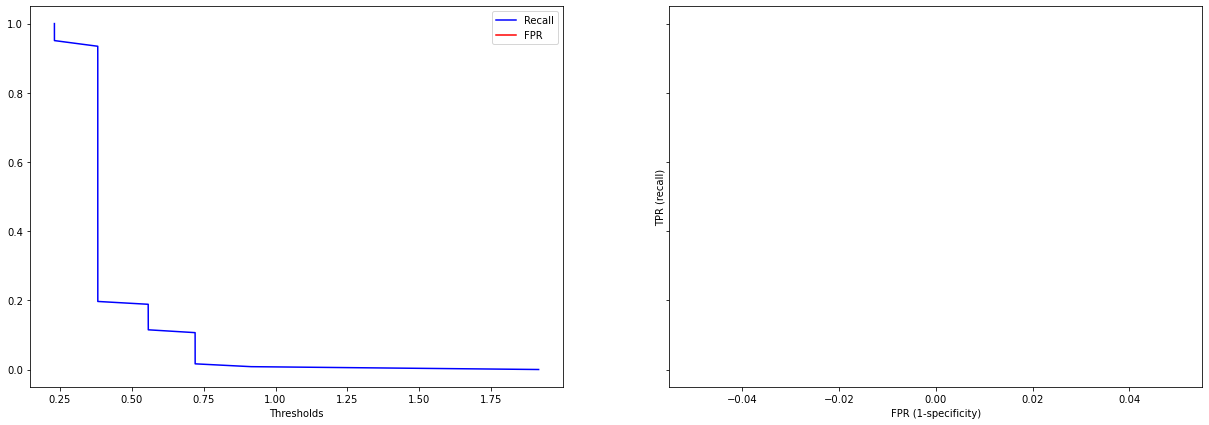

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.651559  0.443989   0.759311     0.859091  0.559380  0.682616
Validation  0.654356  0.442623   0.762732     0.866393  0.557198  0.691989


KNN
╠■■■■■■■■■╣


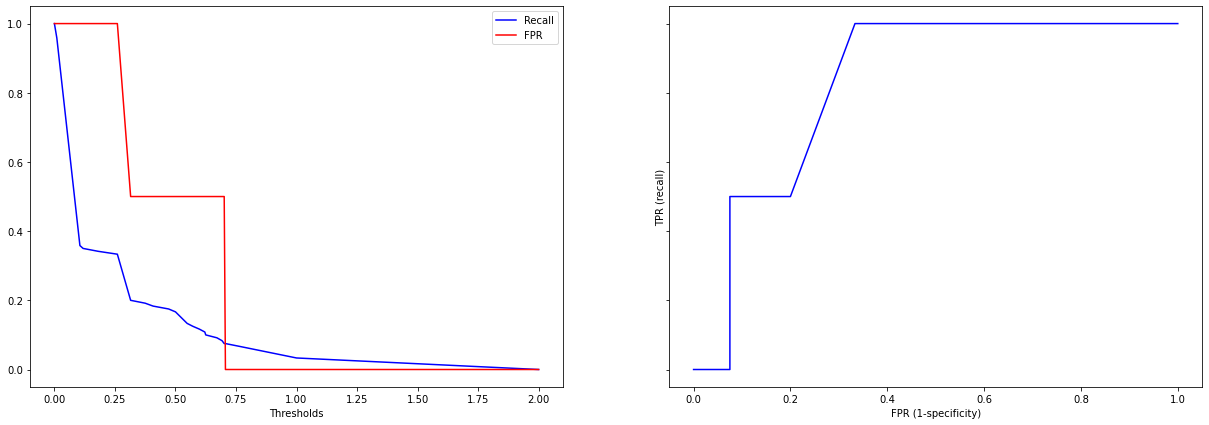

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.696154  0.486815   0.837577     0.905455  0.615626  0.733404
Validation  0.633071  0.419739   0.732241     0.846721  0.532184  0.655743


Logistic Regression
╠■■■■■■■■■╣


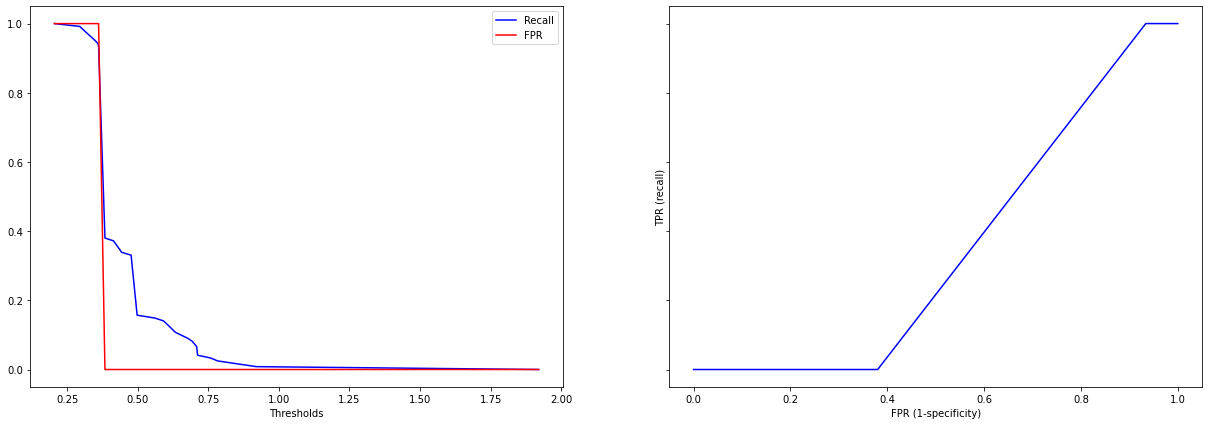

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667651  0.488452   0.761324     0.846818  0.595043  0.692818
Validation  0.662559  0.481121   0.751106     0.844262  0.584160  0.690380

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.601111  0.319865   0.729408     0.882787   
Random Forest (100 estimators)  0.636766  0.472124   0.700229     0.801639   
XGBoost Classifier              0.649036  0.449220   0.747453     0.849180   
SVM                             0.654356  0.442623   0.762732     0.866393   
KNN                             0.633071  0.419739   0.732241     0.846721   
Logistic Regression             0.662559  0.481121   0.751106     0.844262   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.442405  0.581625  
Random Forest (100 estimators)  0.561202  0.661992  
XGBoost Classifier              0.559340  0.667737  
SVM                             0.557198  0.691989  
KNN                             0.532184  0.655743  
Logistic Regression             0.584160  0.690380

In [33]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently keeping both the boolean and the graded yields better performance for every algorithm, except for <b>XGBoost</b> which improves when we just leave the boolean value.

Dummy Random
╠■■■■■■■■■╣


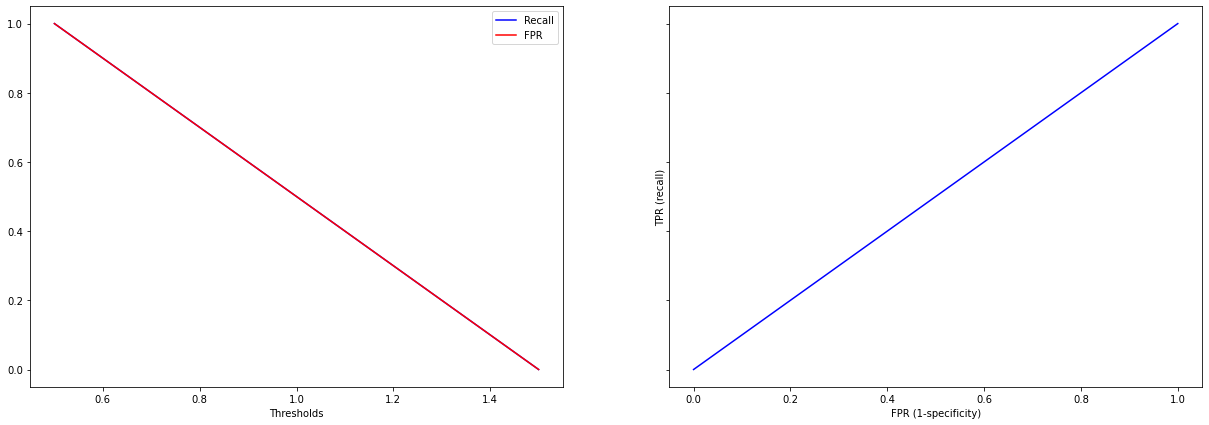

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


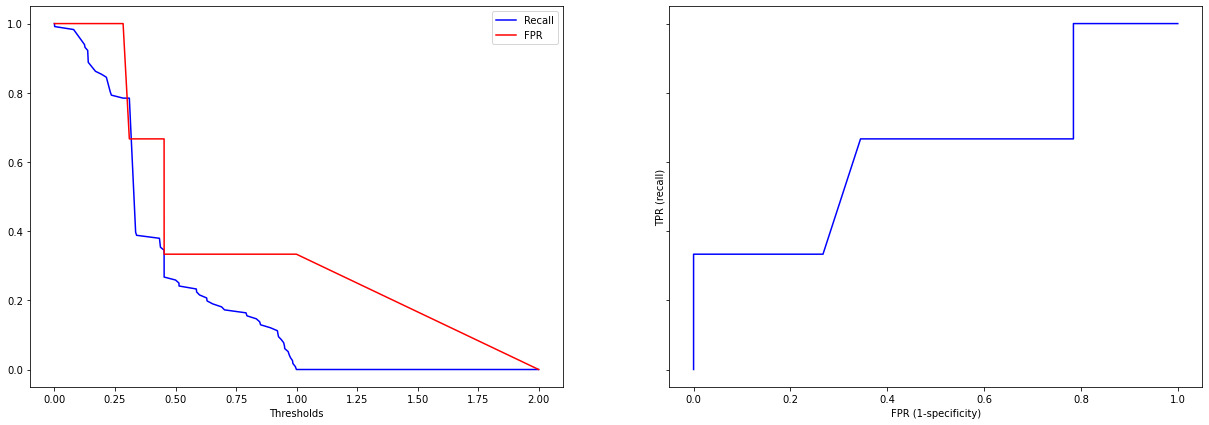

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656843  0.514017   0.719516     0.799628  0.599567  0.688686
Validation  0.650875  0.510490   0.708621     0.791597  0.589959  0.681790


Random Forest (100 estimators)
╠■■■■■■■■■╣


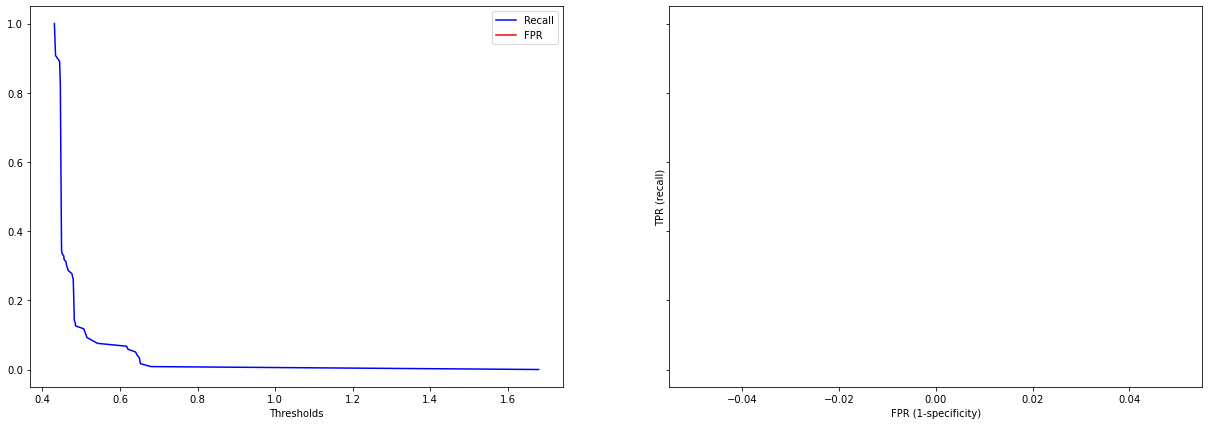

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.640499  0.463539   0.717533     0.817412  0.563060  0.684386
Validation  0.634072  0.454314   0.709696     0.814286  0.549285  0.669843


XGBoost Classifier
╠■■■■■■■■■╣


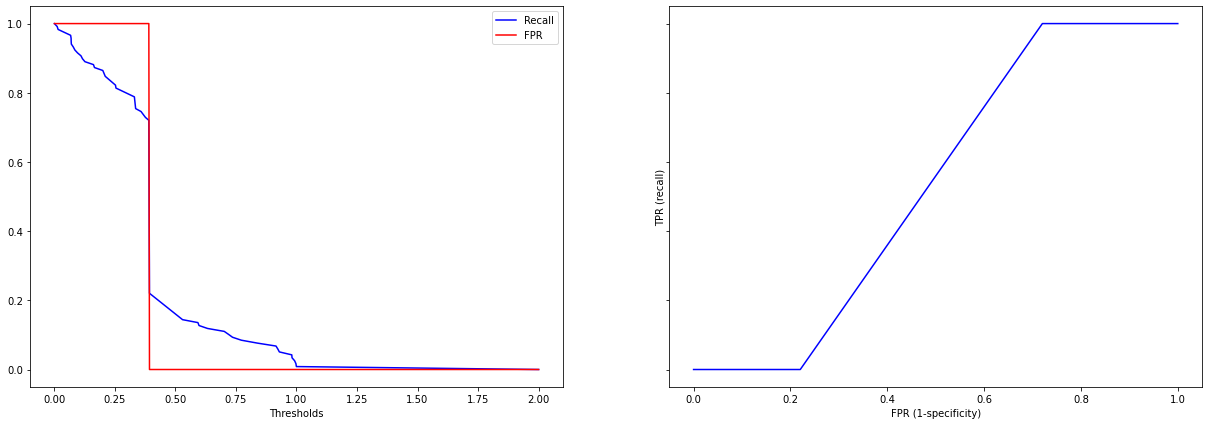

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.763235  0.586943   0.906521     0.939479  0.712521  0.841402
Validation  0.645851  0.455161   0.736436     0.836975  0.559657  0.646509


SVM
╠■■■■■■■■■╣


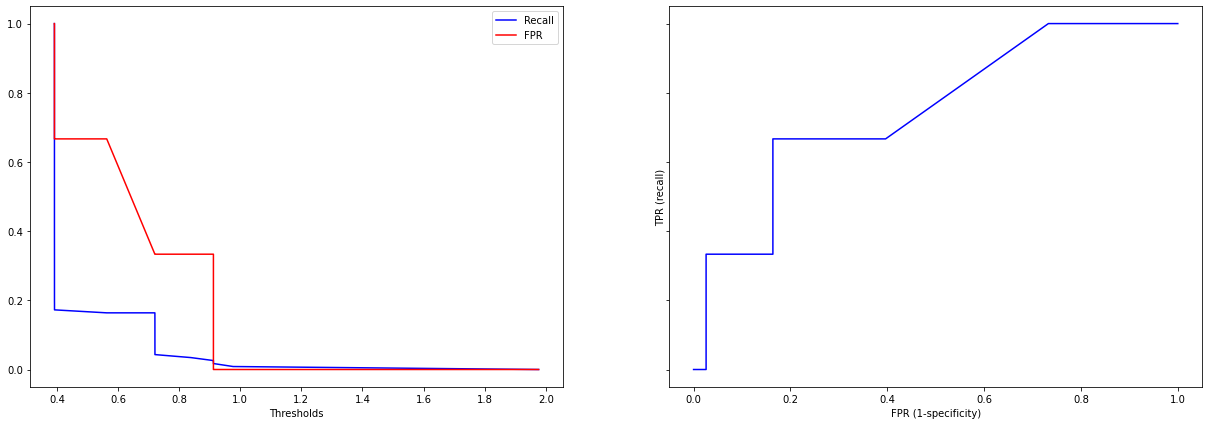

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.654142  0.449382   0.761142     0.858845  0.564690  0.703487
Validation  0.662631  0.446751   0.780920     0.878992  0.563696  0.700636


KNN
╠■■■■■■■■■╣


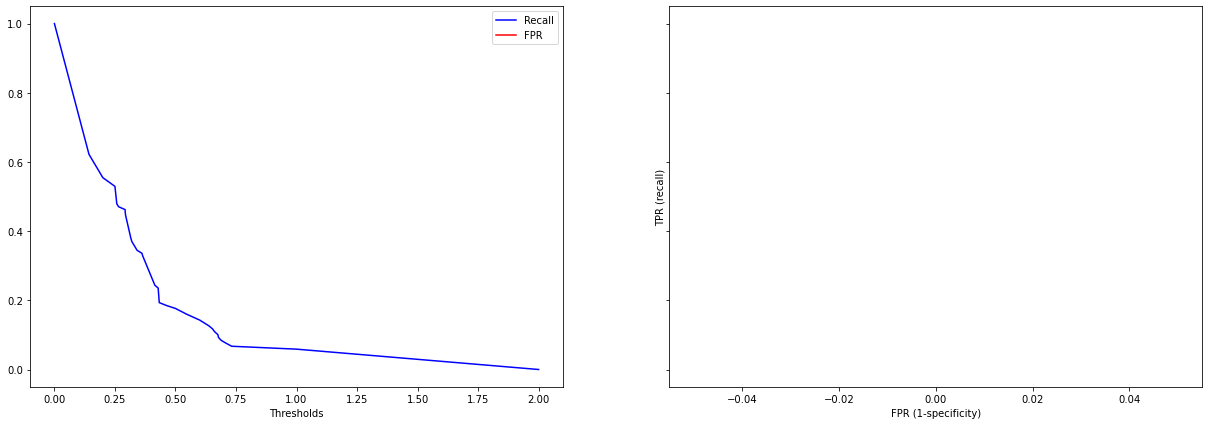

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.769288  0.571481   0.945431     0.967039  0.712303  0.816395
Validation  0.634062  0.479489   0.692227     0.789076  0.563392  0.652301


Logistic Regression
╠■■■■■■■■■╣


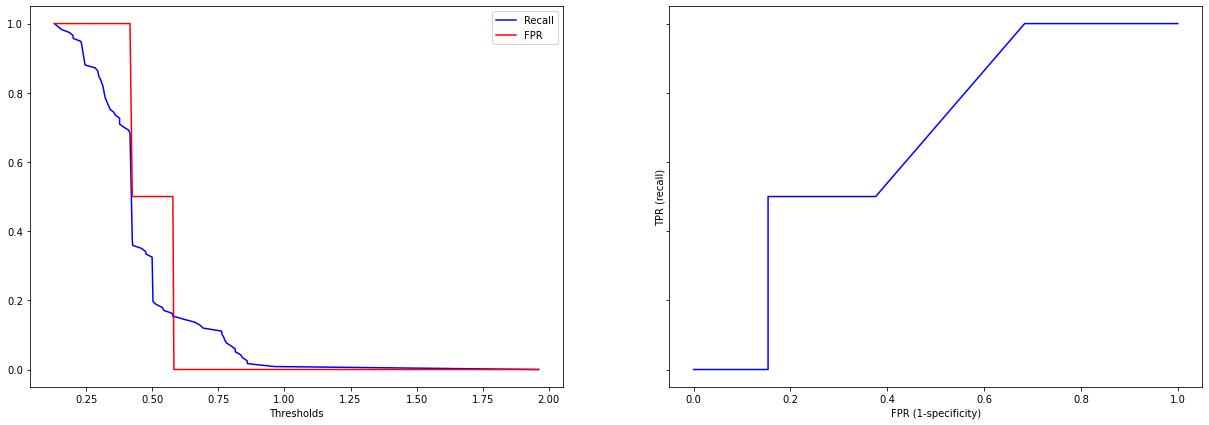

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673418  0.508342   0.759445     0.838454  0.608313  0.717077
Validation  0.656739  0.492850   0.731694     0.821008  0.586820  0.695254

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.650875  0.510490   0.708621     0.791597   
Random Forest (100 estimators)  0.634072  0.454314   0.709696     0.814286   
XGBoost Classifier              0.645851  0.455161   0.736436     0.836975   
SVM                             0.662631  0.446751   0.780920     0.878992   
KNN                             0.634062  0.479489   0.692227     0.789076   
Logistic Regression             0.656739  0.492850   0.731694     0.821008   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.589959  0.681790  
Random Forest (100 estimators)  0.549285  0.669843  
XGBoost Classifier              0.559657  0.646509  
SVM                             0.563696  0.700636  
KNN                             0.563392  0.652301  
Logistic Regression             0.586820  0.695254

In [34]:
#ra_symptoms
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently, all features in <b>reported_symptoms</b> are more important than the assesed ones. <b>days_since_symptom_onset</b> seems to have some importance. Performance improves slightly for all of them except for <b>SVM</b> and <b>Logistic Regression</b>. Logistic Regression improves with a slightly lower threshold (.4 for higher recall and .44 for higher specificity). SVM improves also with a lower threshold(.47)

Dummy Random
╠■■■■■■■■■╣


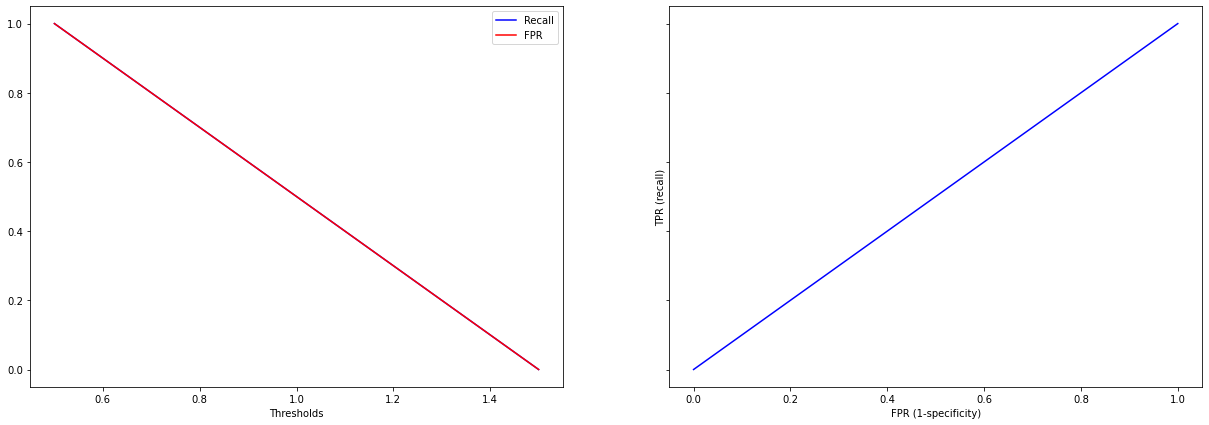

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


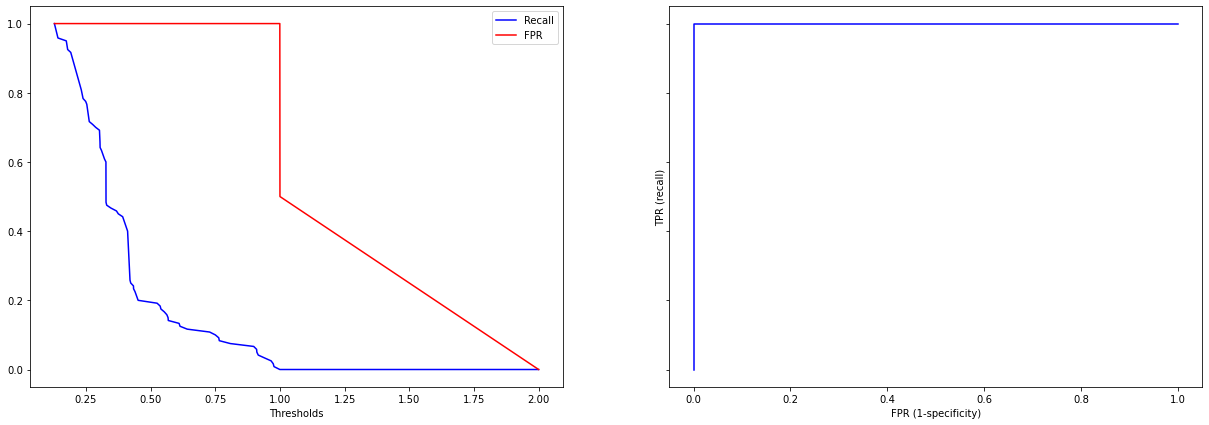

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655332  0.489361   0.732678     0.821273  0.586679  0.682422
Validation  0.658869  0.483600   0.743016     0.834426  0.582554  0.688877


Random Forest (100 estimators)
╠■■■■■■■■■╣


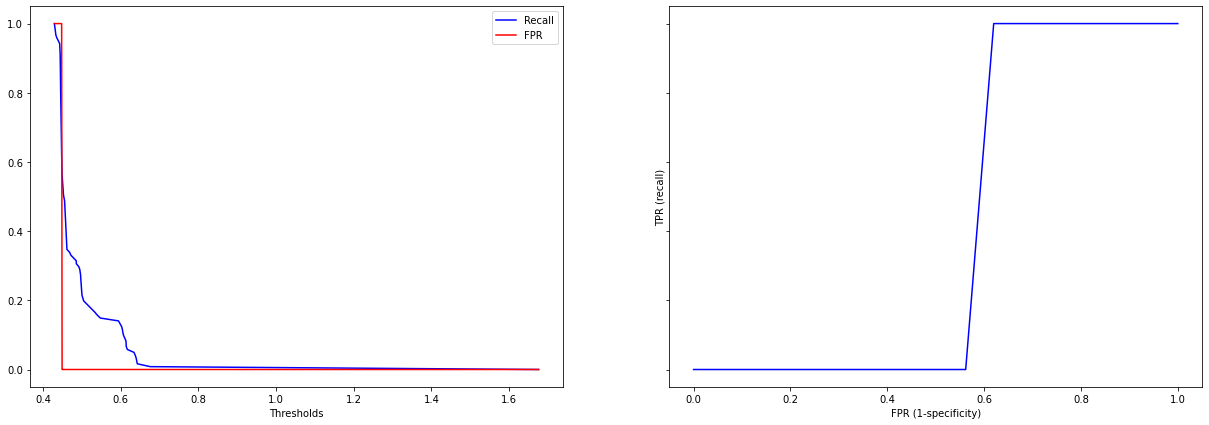

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.638467  0.439805   0.730171     0.837091  0.548741  0.686774
Validation  0.628975  0.432847   0.707564     0.825410  0.533131  0.674543


XGBoost Classifier
╠■■■■■■■■■╣


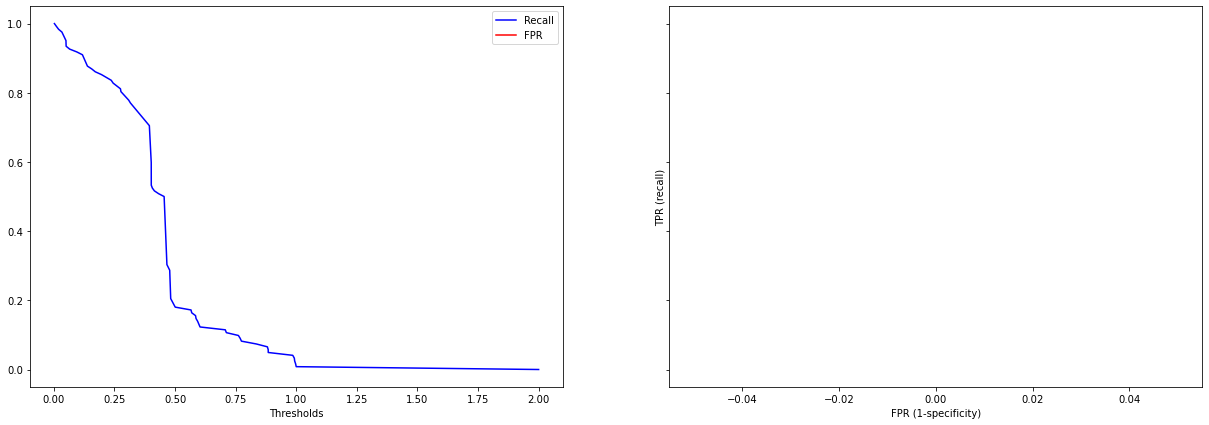

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.751477  0.569376   0.895861     0.933545  0.695986  0.835259
Validation  0.628968  0.441004   0.705798     0.817213  0.540937  0.645815


SVM
╠■■■■■■■■■╣


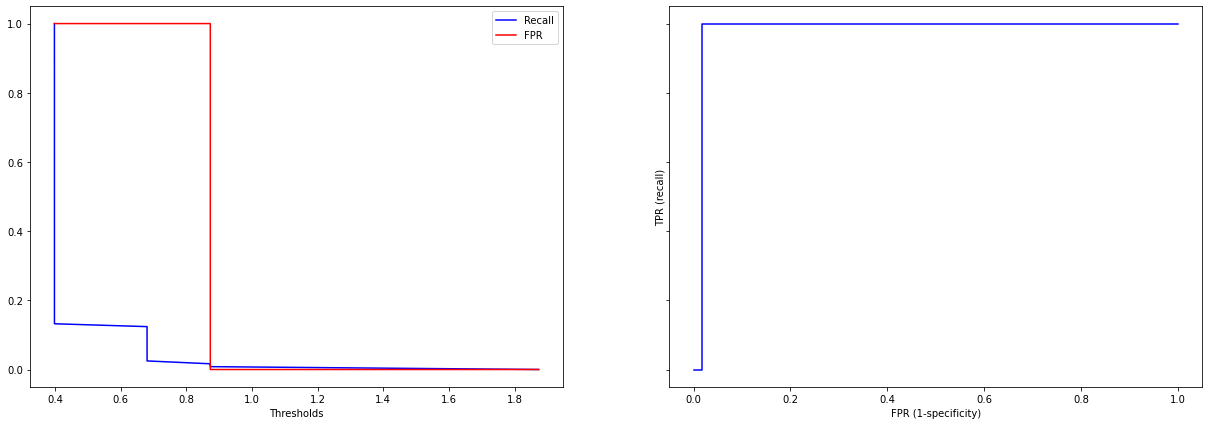

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.651650  0.449348   0.756154     0.853909  0.562593  0.694804
Validation  0.653155  0.450846   0.756543     0.855738  0.560312  0.678722


KNN
╠■■■■■■■■■╣


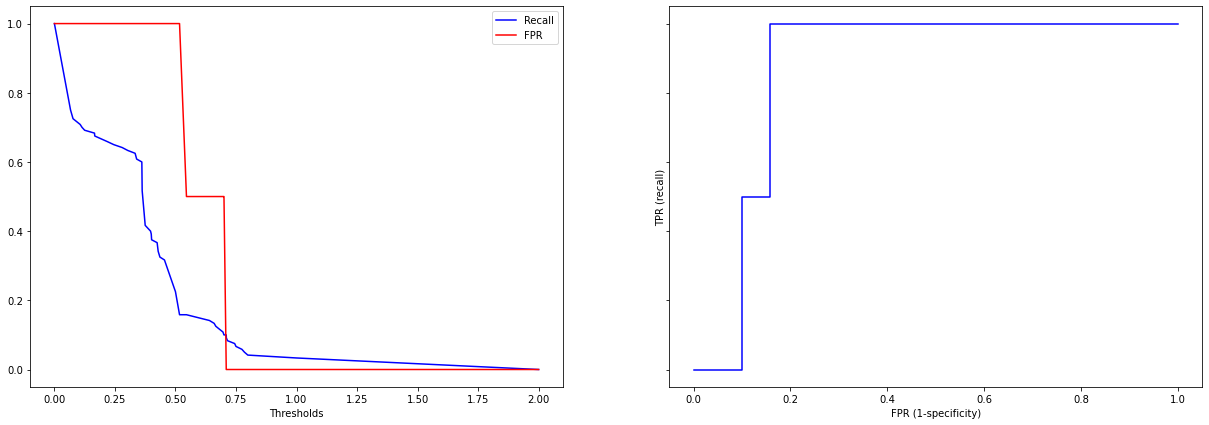

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.750750  0.551736   0.916621     0.949727  0.688711  0.803127
Validation  0.607265  0.394362   0.682236     0.820492  0.498414  0.619485


Logistic Regression
╠■■■■■■■■■╣


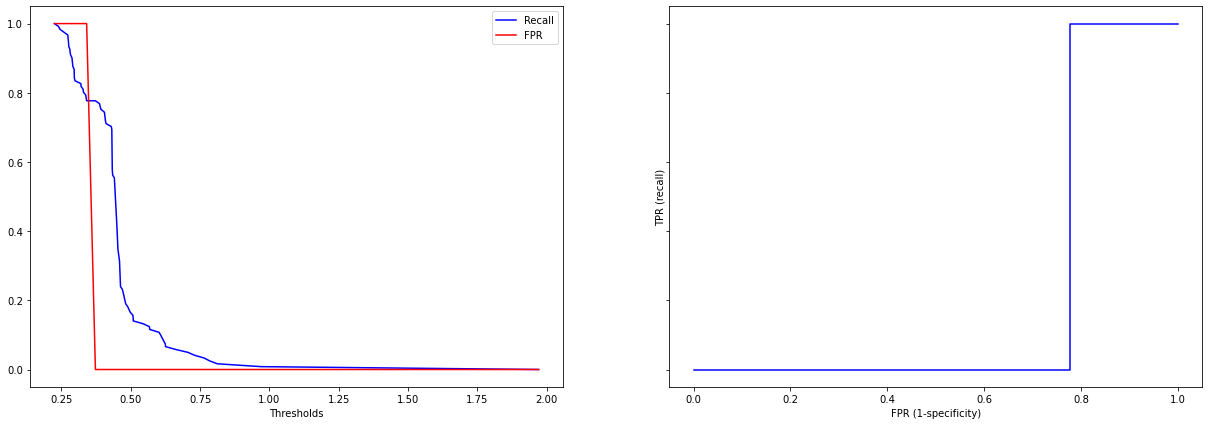

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664424  0.503007   0.744576     0.825818  0.599682  0.707933
Validation  0.647427  0.479475   0.721191     0.815574  0.572164  0.692742

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.658869  0.483600   0.743016     0.834426   
Random Forest (100 estimators)  0.628975  0.432847   0.707564     0.825410   
XGBoost Classifier              0.628968  0.441004   0.705798     0.817213   
SVM                             0.653155  0.450846   0.756543     0.855738   
KNN                             0.607265  0.394362   0.682236     0.820492   
Logistic Regression             0.647427  0.479475   0.721191     0.815574   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.582554  0.688877  
Random Forest (100 estimators)  0.533131  0.674543  
XGBoost Classifier              0.540937  0.645815  
SVM                             0.560312  0.678722  
KNN                             0.498414  0.619485  
Logistic Regression             0.572164  0.692742

In [35]:
#r_symptoms_ex
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Epidemiological factors proves themselves to be slightly more important that some of the of the reported symptoms. <b>high_risk_exposure_occupation</b> once again proves to be a highly determinant feature. It also improves performance in all other models, while reducing specificity by a small amount (with the exception of <b>KNN</b>).

Dummy Random
╠■■■■■■■■■╣


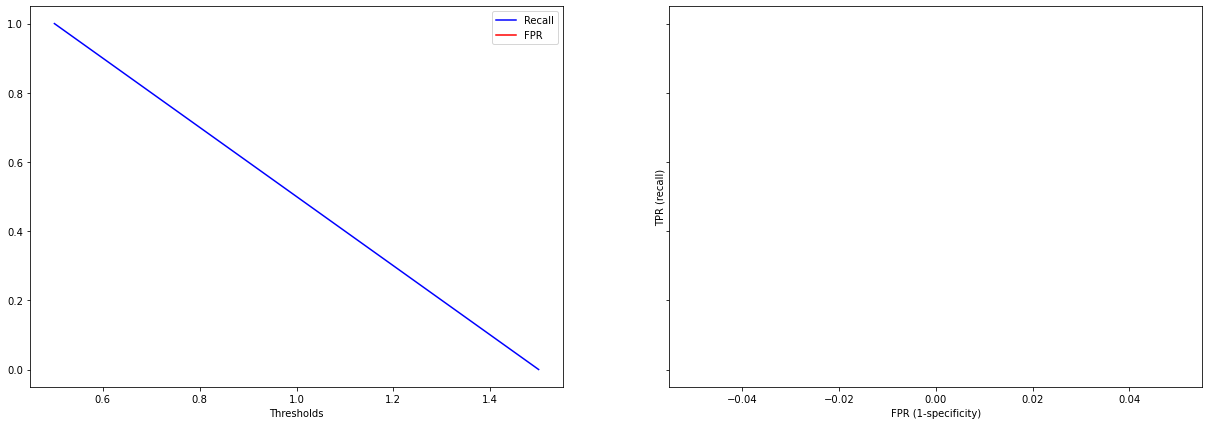

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


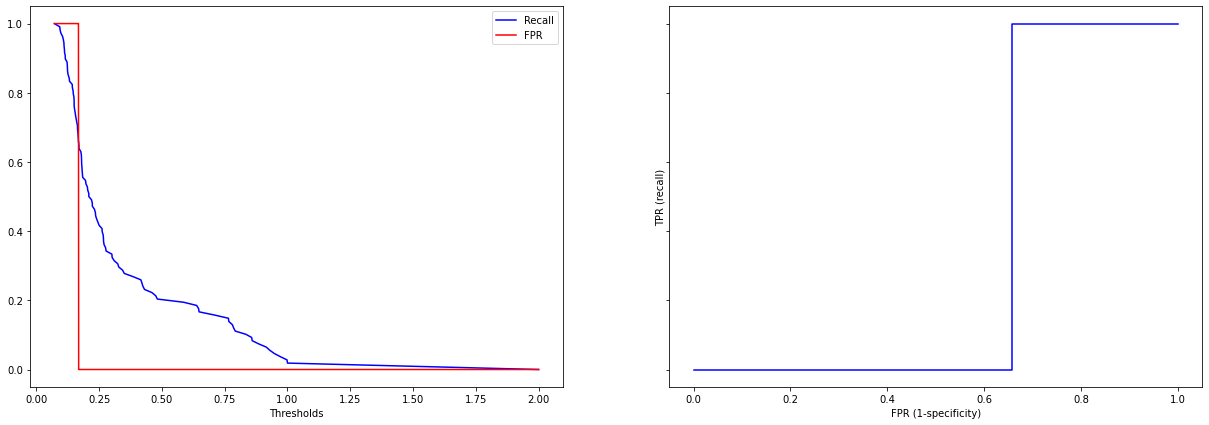

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659593  0.504399   0.731231     0.814646  0.596944  0.707532
Validation  0.658757  0.503211   0.728368     0.815596  0.594052  0.703124


Random Forest (100 estimators)
╠■■■■■■■■■╣


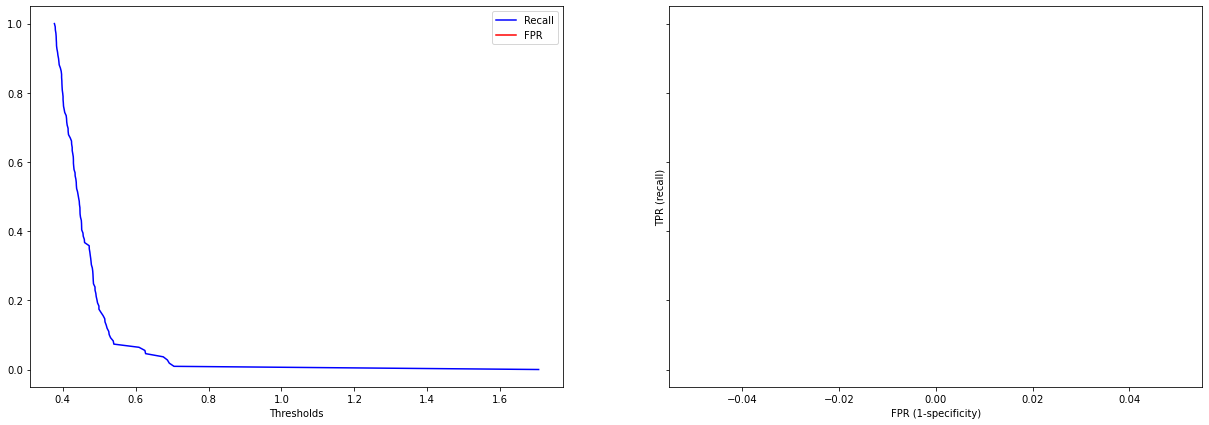

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.658734  0.501766   0.731853     0.815556  0.594815  0.718673
Validation  0.648257  0.495980   0.714970     0.801835  0.581543  0.689439


XGBoost Classifier
╠■■■■■■■■■╣


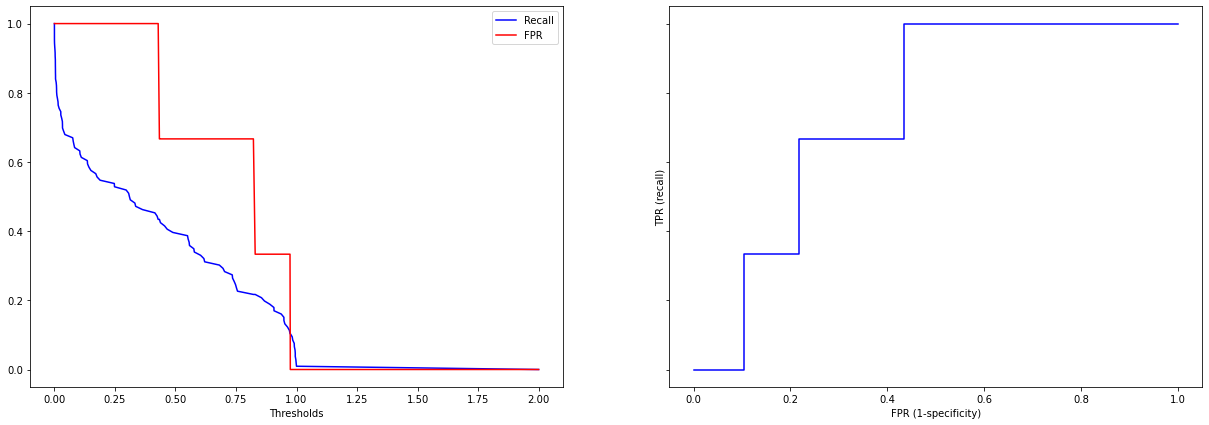

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999646  0.999596   0.999697     0.999697  0.999646  0.999999
Validation  0.613516  0.602360   0.617561     0.624771  0.608971  0.661611


SVM
╠■■■■■■■■■╣


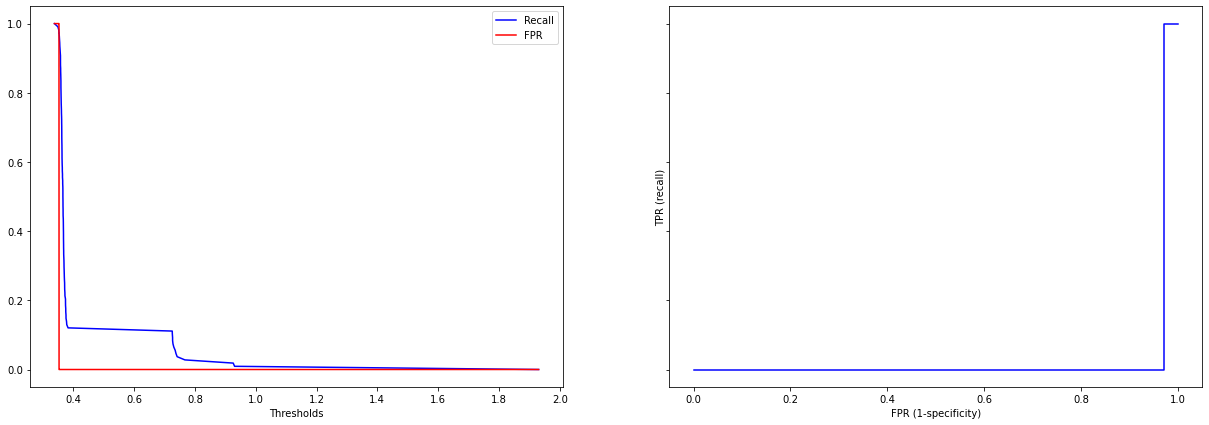

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667829  0.483269   0.766189     0.852222  0.592477  0.736187
Validation  0.661941  0.472252   0.761507     0.853211  0.579350  0.729480


KNN
╠■■■■■■■■■╣


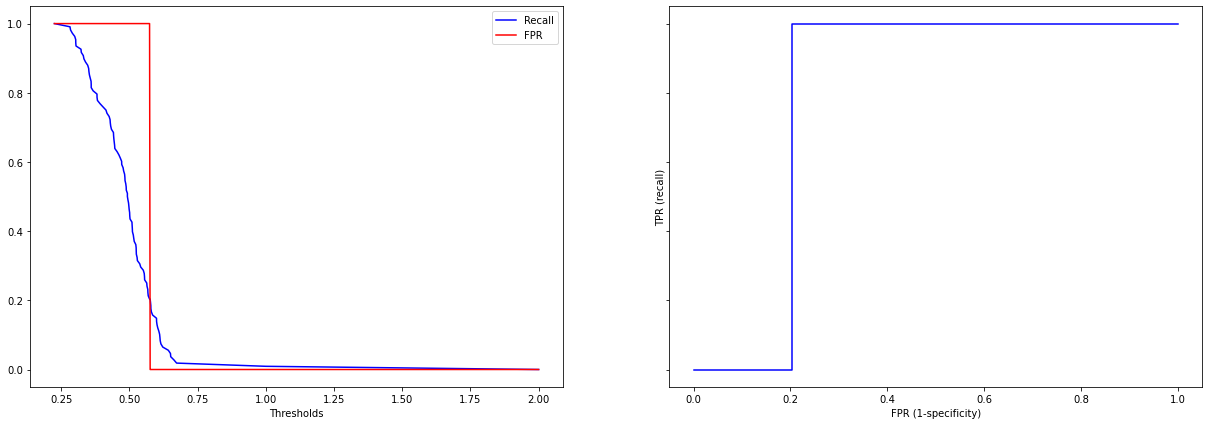

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999545  0.999090   1.000000     1.000000  0.999545  0.999999
Validation  0.575154  0.497756   0.589261     0.653211  0.537471  0.606678


Logistic Regression
╠■■■■■■■■■╣


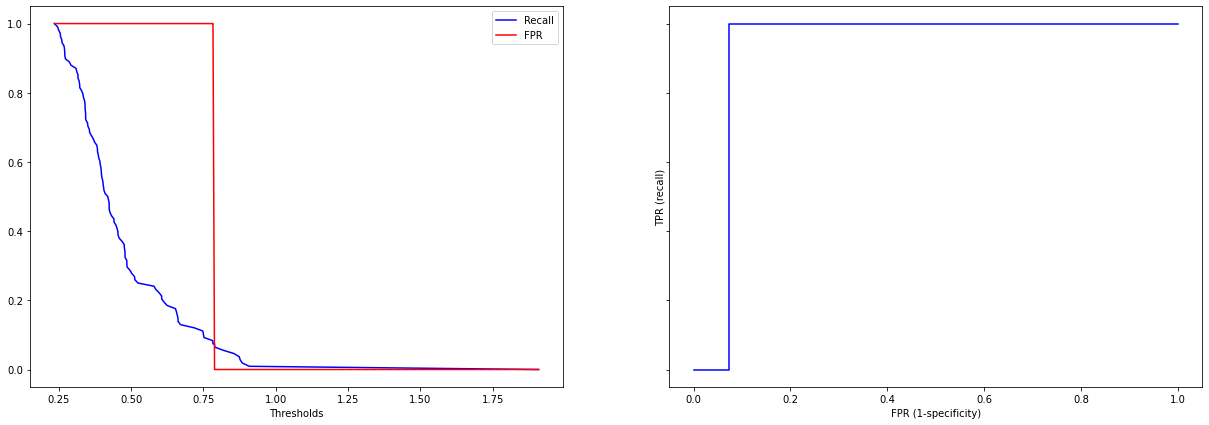

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.672578  0.546153   0.730958     0.798889  0.624998  0.729781
Validation  0.659216  0.528682   0.718068     0.790826  0.607185  0.717915

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.658757  0.503211   0.728368     0.815596   
Random Forest (100 estimators)  0.648257  0.495980   0.714970     0.801835   
XGBoost Classifier              0.613516  0.602360   0.617561     0.624771   
SVM                             0.661941  0.472252   0.761507     0.853211   
KNN                             0.575154  0.497756   0.589261     0.653211   
Logistic Regression             0.659216  0.528682   0.718068     0.790826   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.594052  0.703124  
Random Forest (100 estimators)  0.581543  0.689439  
XGBoost Classifier              0.608971  0.661611  
SVM                             0.579350  0.729480  
KNN                             0.537471  0.606678  
Logistic Regression             0.607185  0.717915

In [36]:
#r_symptoms_vitals
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


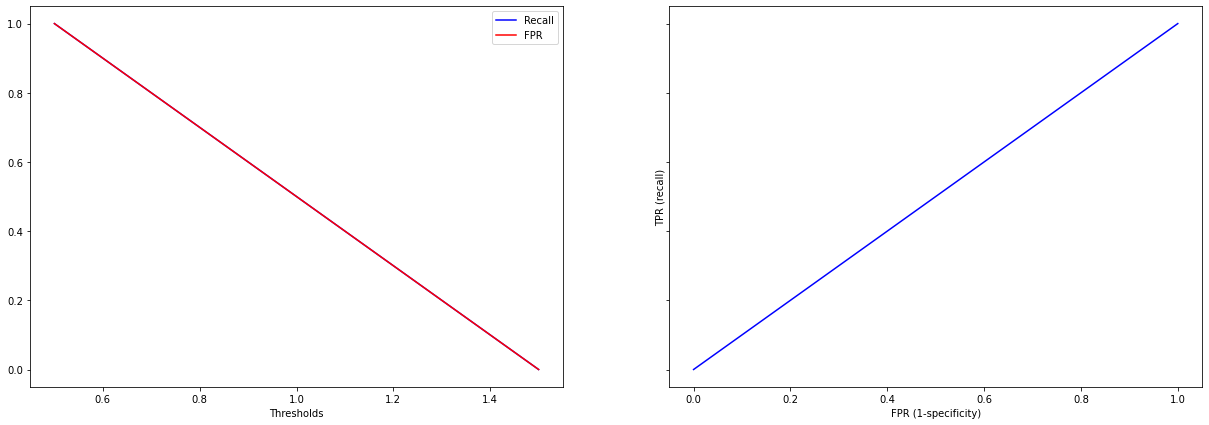

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


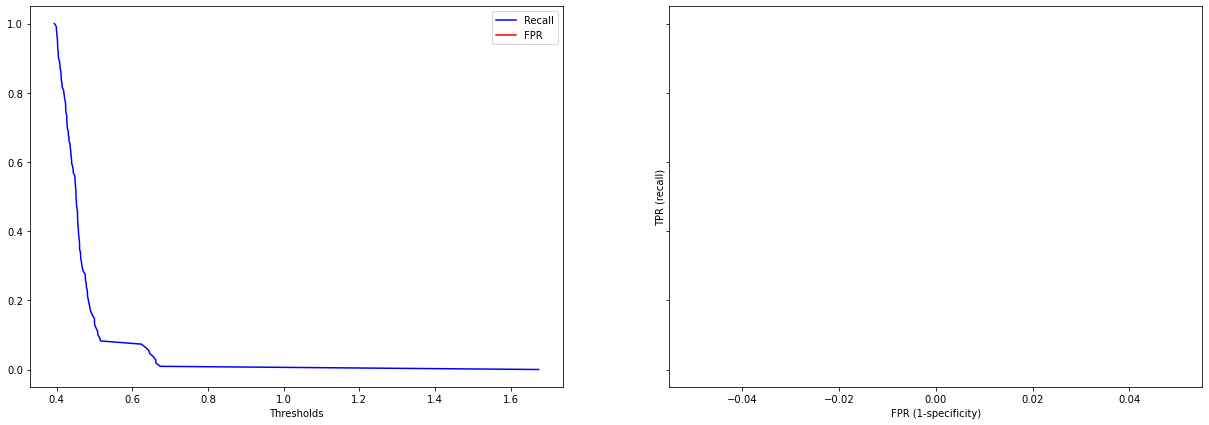

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659947  0.513198   0.726760     0.806566  0.601110  0.720483
Validation  0.651454  0.505021   0.713249     0.799083  0.589255  0.698495


XGBoost Classifier
╠■■■■■■■■■╣


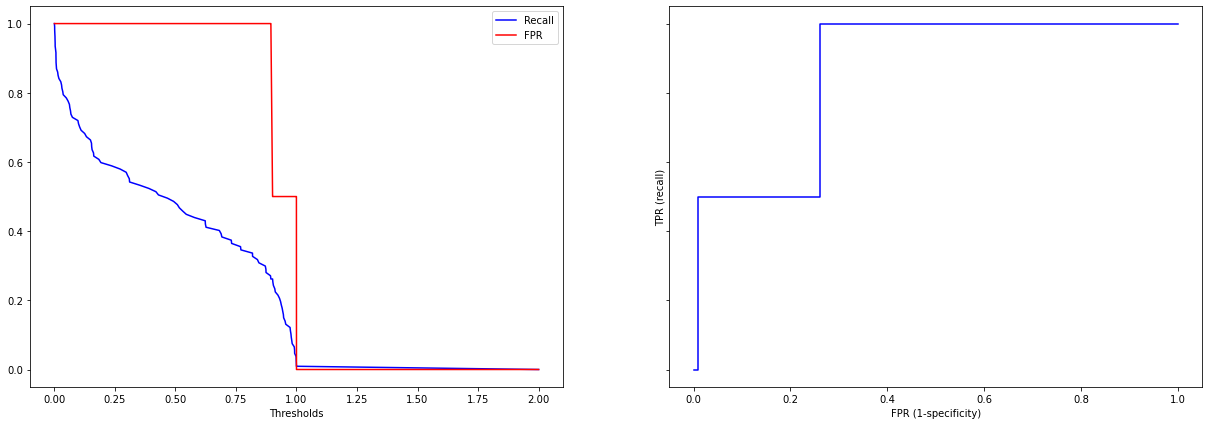

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999545  0.999393   0.999697     0.999697  0.999545  0.999999
Validation  0.624955  0.608749   0.631631     0.641284  0.619424  0.670605


SVM
╠■■■■■■■■■╣


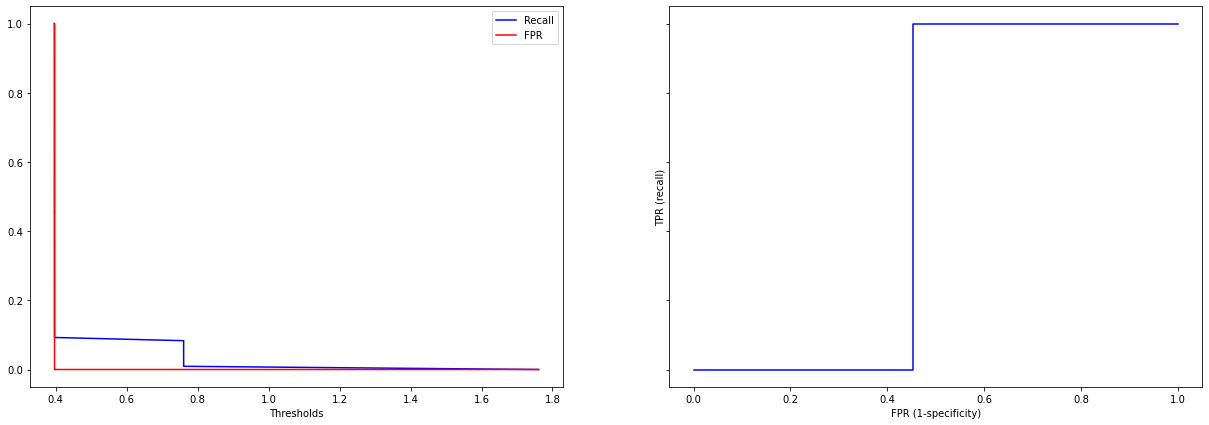

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664039  0.467698   0.770495     0.860202  0.581517  0.732764
Validation  0.655549  0.460434   0.755742     0.852294  0.567719  0.721323


KNN
╠■■■■■■■■■╣


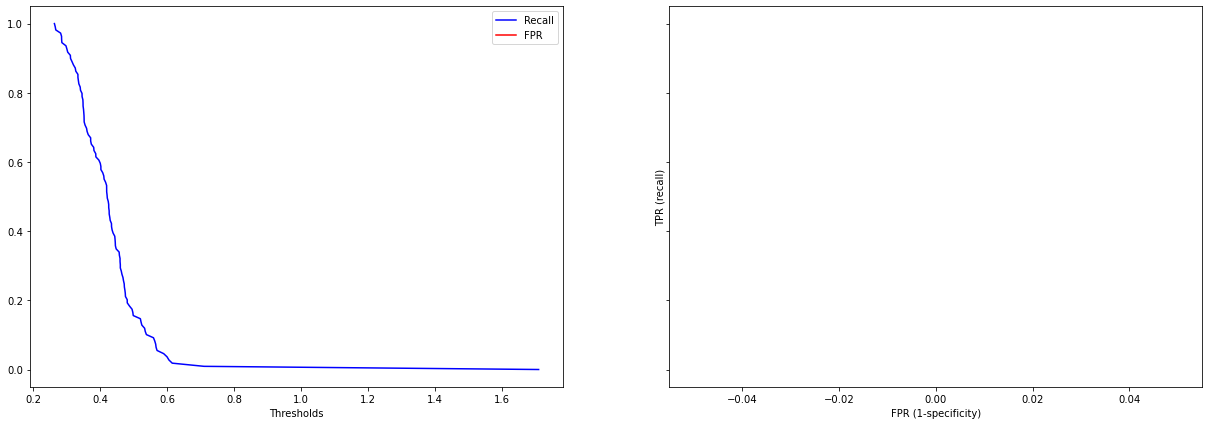

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999596  0.999191   1.000000     1.000000  0.999595  0.999999
Validation  0.630878  0.397665   0.746058     0.866055  0.512913  0.702909


Logistic Regression
╠■■■■■■■■■╣


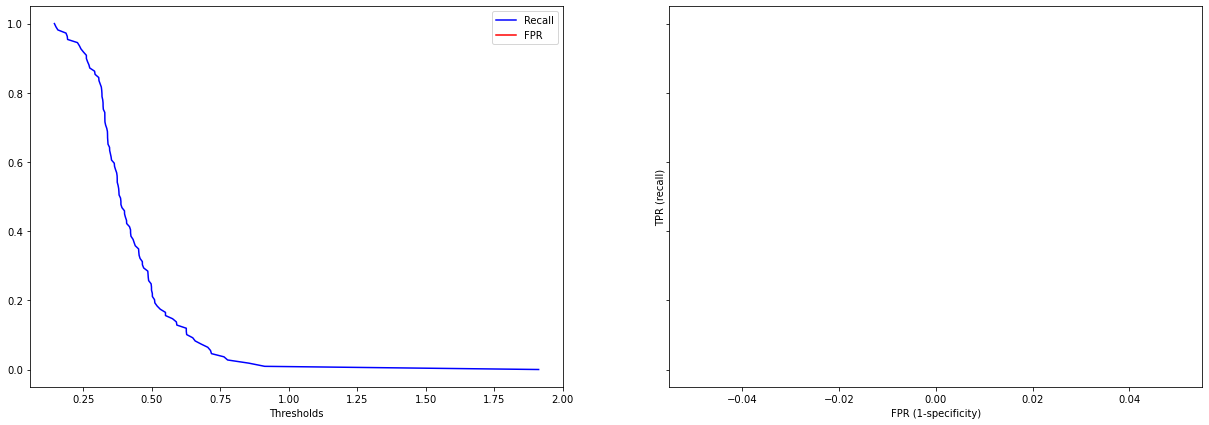

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681876  0.572947   0.732389     0.790707  0.642789  0.740371
Validation  0.677952  0.555988   0.741408     0.800917  0.632720  0.734477

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.651454  0.505021   0.713249     0.799083   
XGBoost Classifier              0.624955  0.608749   0.631631     0.641284   
SVM                             0.655549  0.460434   0.755742     0.852294   
KNN                             0.630878  0.397665   0.746058     0.866055   
Logistic Regression             0.677952  0.555988   0.741408     0.800917   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.589255  0.698495  
XGBoost Classifier              0.619424  0.670605  
SVM                             0.567719  0.721323  
KNN                             0.512913  0.702909  
Logistic Regression             0.632720  0.734477

In [37]:
#r_symptoms_svitals
run_models(r_symptoms_svitals, y[r_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

It seems the vitals do hold certain importance compared to the reported symptoms. Surprisingly, <b>sats</b> is on the list of high importance, however this might be due to the vitals not being standardized. Again there is an improvement, with a little sacrifice in specificity. <b>XGB</b> and <b>KNN</b> however performed slightly worse.

Dummy Random
╠■■■■■■■■■╣


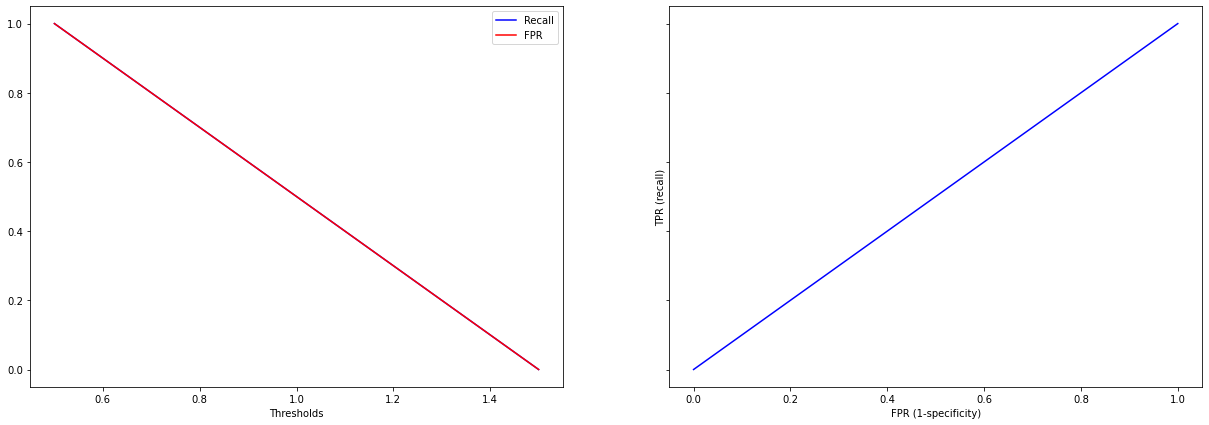

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


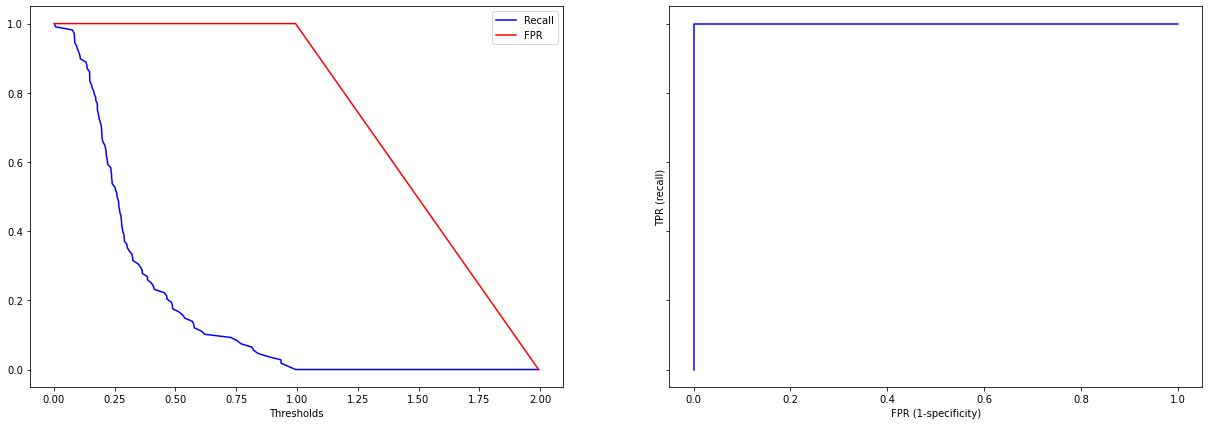

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659498  0.512023   0.726208     0.806897  0.600459  0.709292
Validation  0.658582  0.511384   0.722301     0.806422  0.595582  0.712112


Random Forest (100 estimators)
╠■■■■■■■■■╣


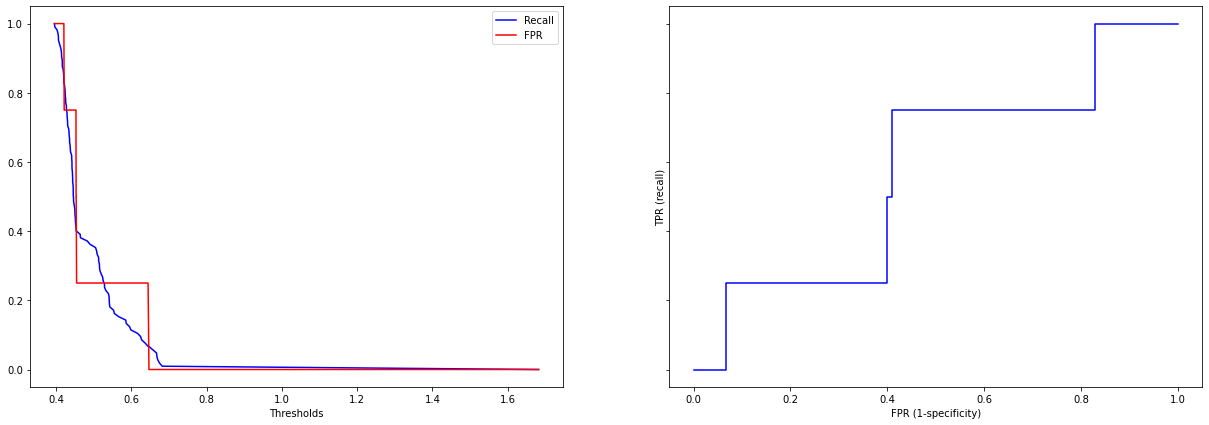

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664164  0.534449   0.722294     0.793813  0.613990  0.722979
Validation  0.642994  0.516781   0.684851     0.769725  0.586229  0.704546


XGBoost Classifier
╠■■■■■■■■■╣


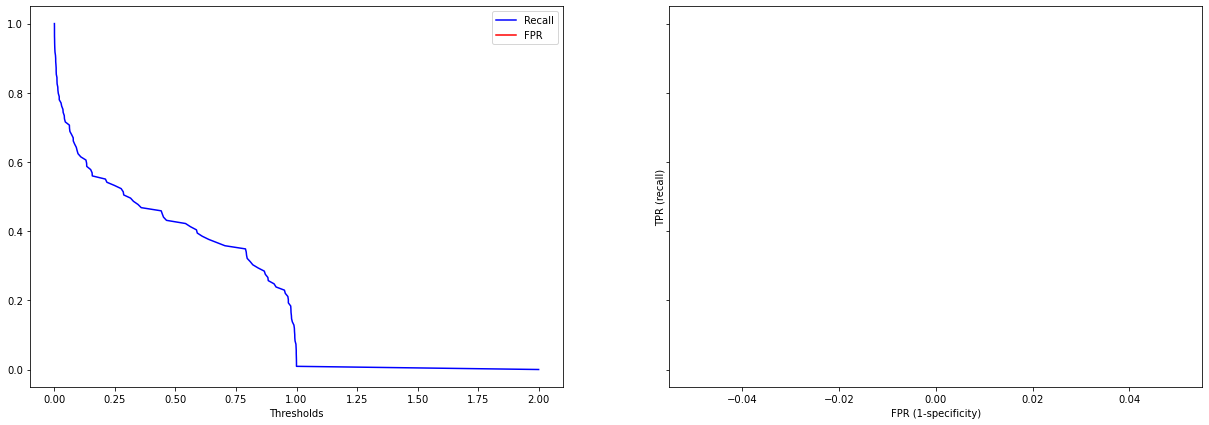

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999594  0.999391   0.999797     0.999797  0.999594  0.999999
Validation  0.608707  0.595413   0.613594     0.622018  0.603543  0.653171


SVM
╠■■■■■■■■■╣


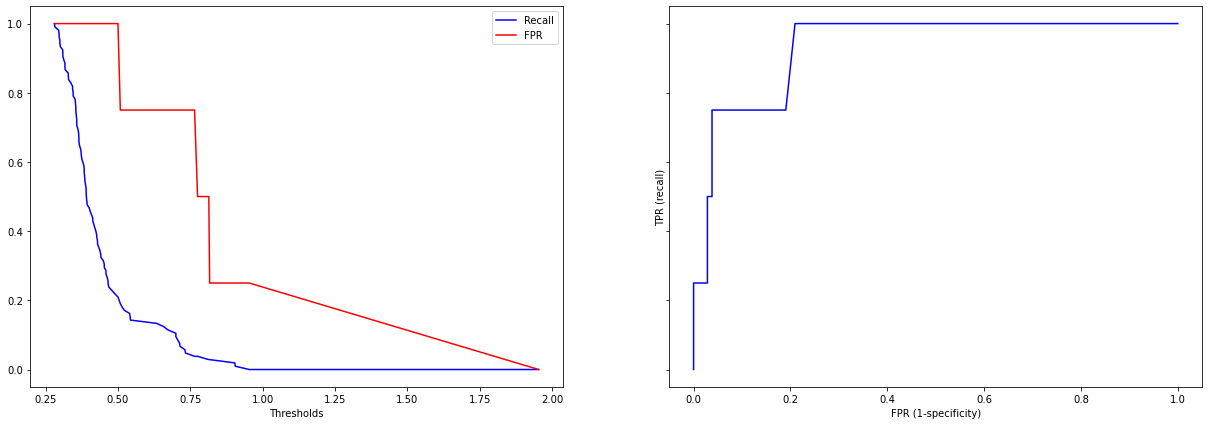

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.668882  0.477832   0.773427     0.859838  0.590415  0.742392
Validation  0.659916  0.470259   0.755837     0.850459  0.576511  0.718772


KNN
╠■■■■■■■■■╣


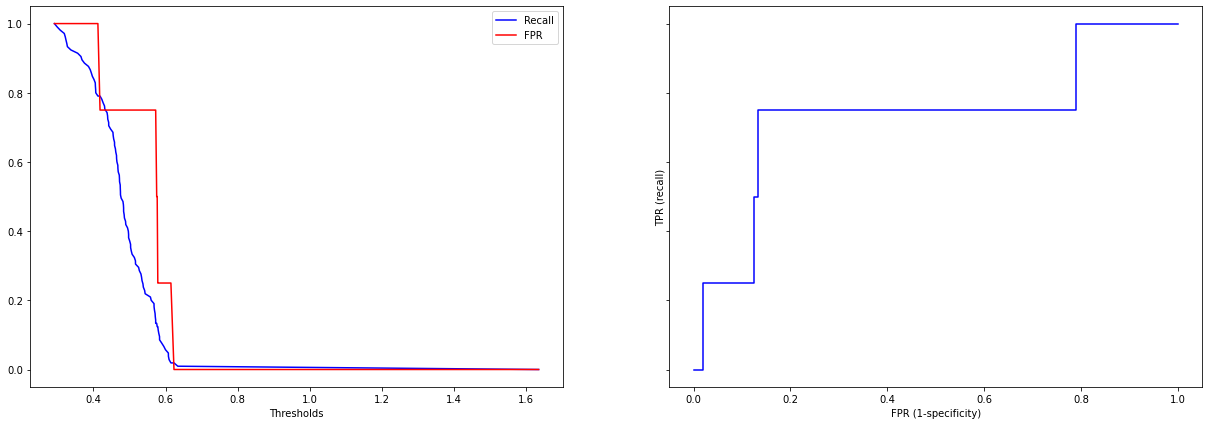

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999746  0.999493   1.000000     1.000000  0.999746  1.000000
Validation  0.563814  0.480192   0.575884     0.647706  0.521639  0.606139


Logistic Regression
╠■■■■■■■■■╣


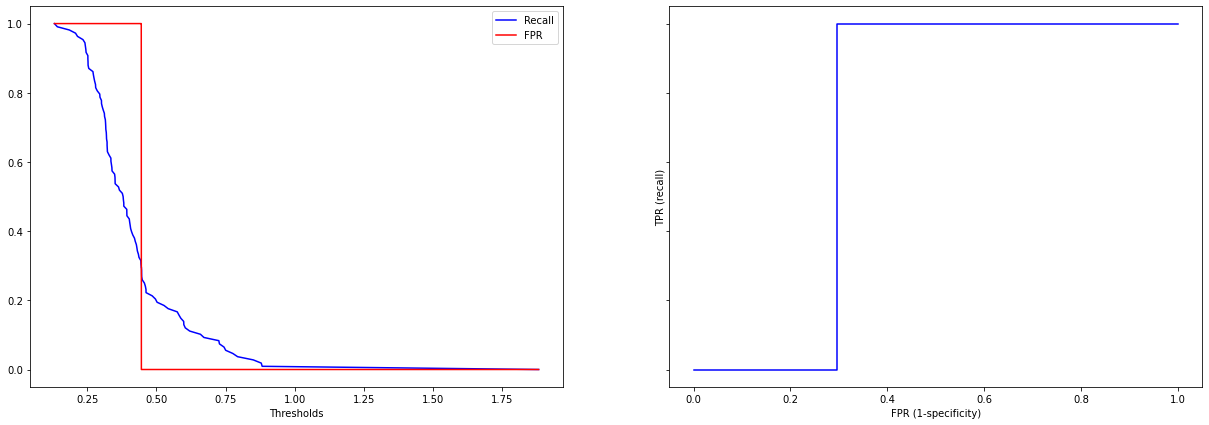

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675831  0.562048   0.727738     0.789554  0.634148  0.736350
Validation  0.664499  0.541518   0.718257     0.788073  0.616073  0.728706

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.658582  0.511384   0.722301     0.806422   
Random Forest (100 estimators)  0.642994  0.516781   0.684851     0.769725   
XGBoost Classifier              0.608707  0.595413   0.613594     0.622018   
SVM                             0.659916  0.470259   0.755837     0.850459   
KNN                             0.563814  0.480192   0.575884     0.647706   
Logistic Regression             0.664499  0.541518   0.718257     0.788073   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.595582  0.712112  
Random Forest (100 estimators)  0.586229  0.704546  
XGBoost Classifier              0.603543  0.653171  
SVM                             0.576511  0.718772  
KNN                             0.521639  0.606139  
Logistic Regression             0.616073  0.728706

In [38]:
#ra_symptoms_vitals
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


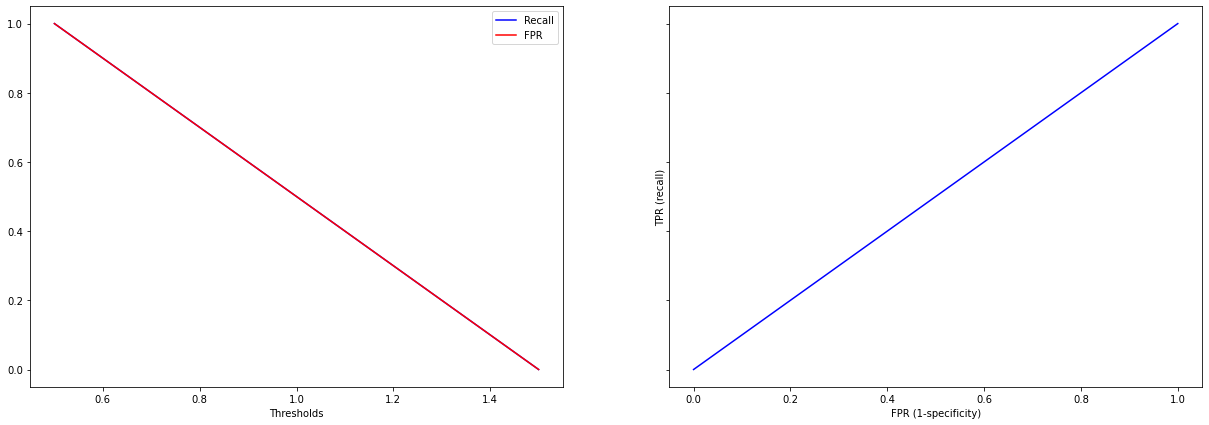

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


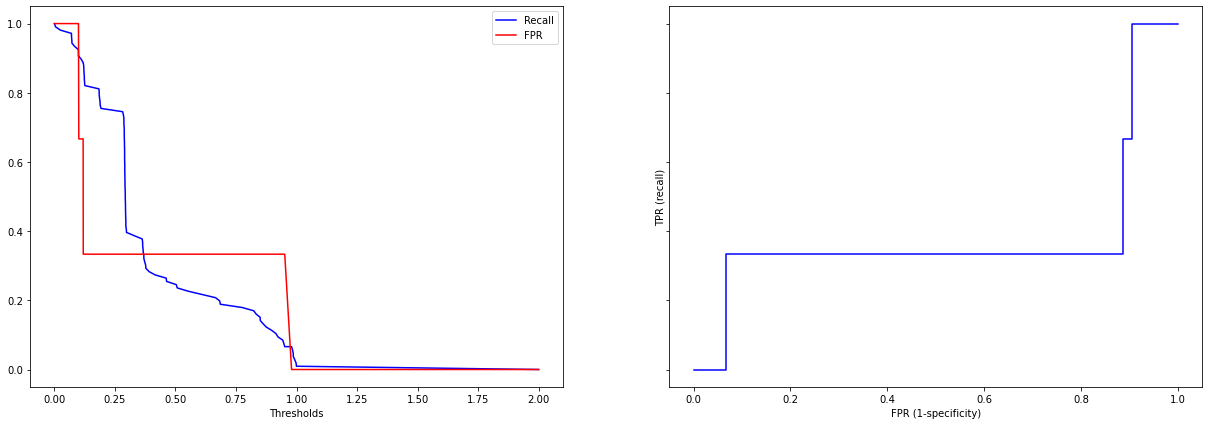

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657013  0.496703   0.731004     0.817241  0.591464  0.687087
Validation  0.653990  0.499508   0.721215     0.809174  0.586898  0.674508


Random Forest (100 estimators)
╠■■■■■■■■■╣


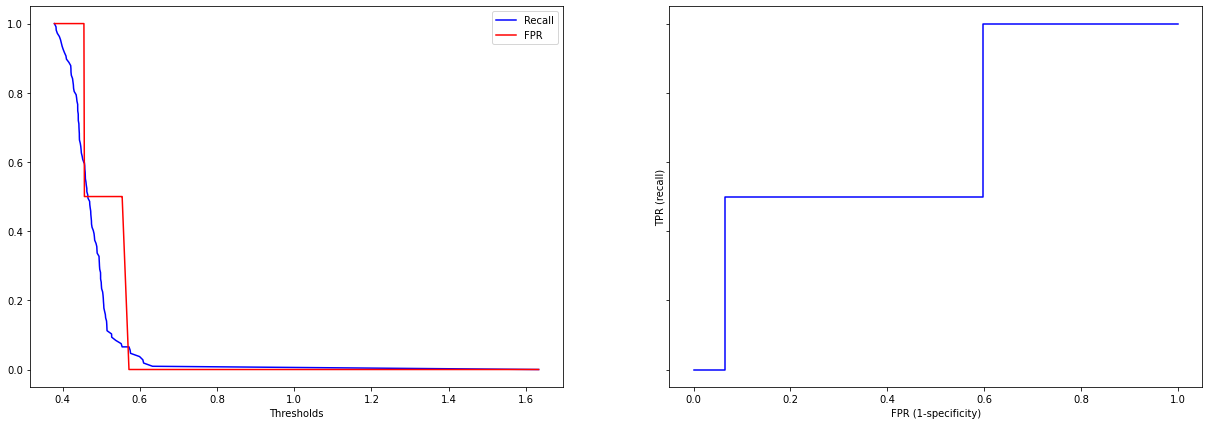

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659599  0.530080   0.715654     0.789047  0.608779  0.723458
Validation  0.644793  0.520442   0.692257     0.769725  0.590525  0.692346


XGBoost Classifier
╠■■■■■■■■■╣


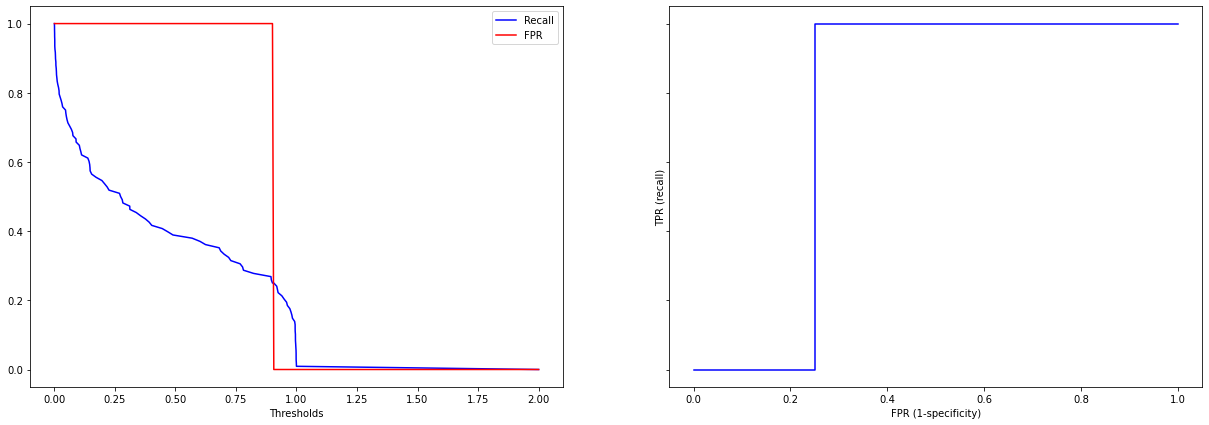

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999797  0.999696   0.999899     0.999899  0.999797  1.000000
Validation  0.615577  0.603636   0.619702     0.627523  0.611143  0.668445


SVM
╠■■■■■■■■■╣


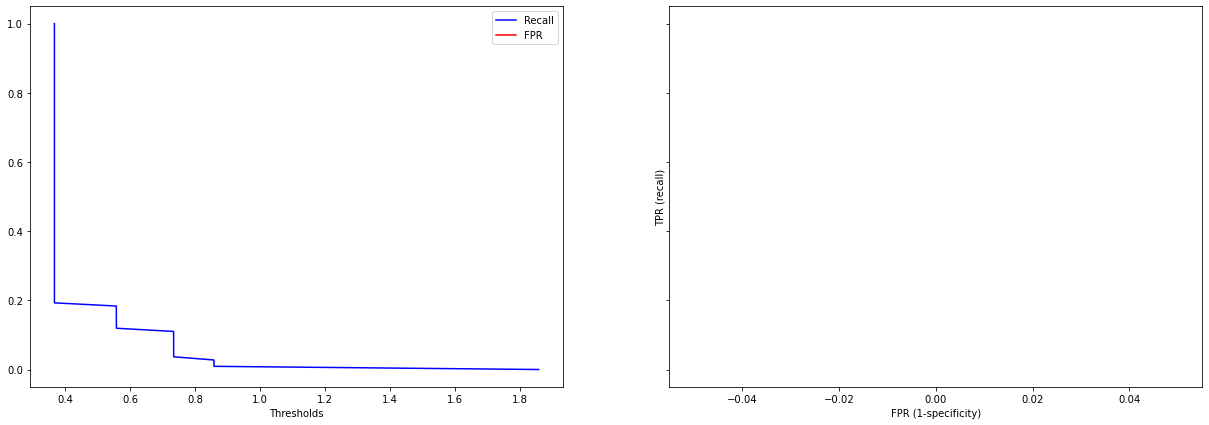

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663556  0.462196   0.774417     0.864807  0.578455  0.738915
Validation  0.658559  0.456622   0.760561     0.861468  0.566115  0.731946


KNN
╠■■■■■■■■■╣


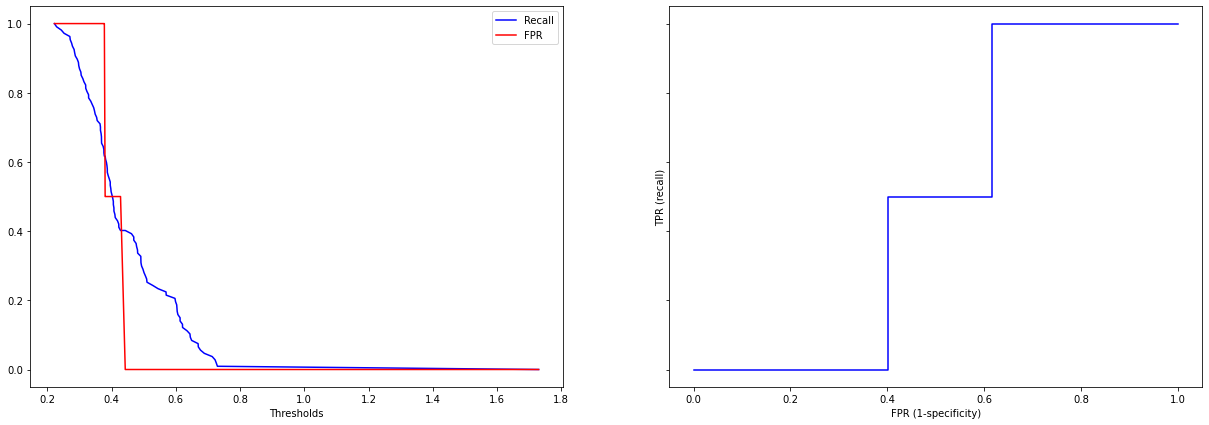

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999696   1.000000     1.000000  0.999848  1.000000
Validation  0.636134  0.498632   0.686803     0.774312  0.574225  0.682809


Logistic Regression
╠■■■■■■■■■╣


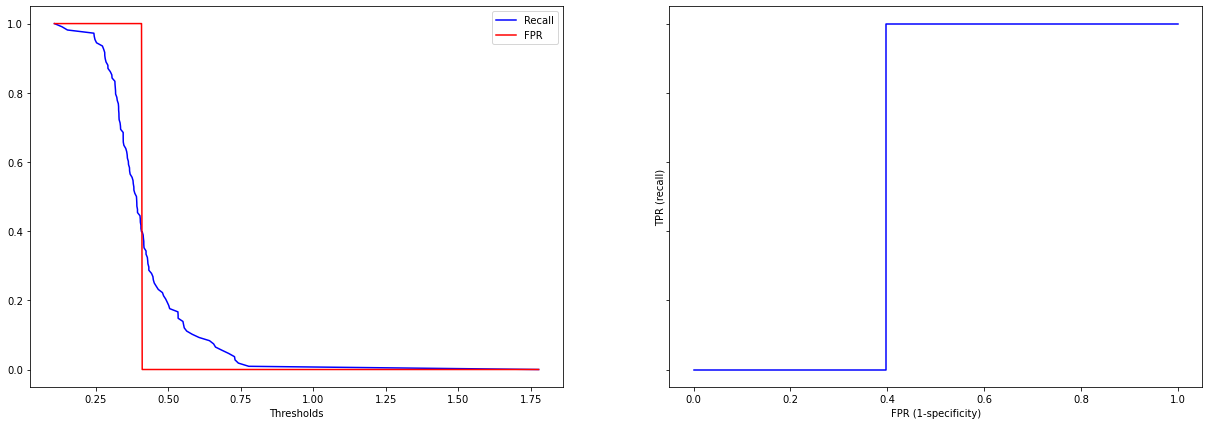

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683388  0.549058   0.751239     0.817647  0.634107  0.744945
Validation  0.675056  0.536055   0.744087     0.814679  0.619613  0.727576

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.653990  0.499508   0.721215     0.809174   
Random Forest (100 estimators)  0.644793  0.520442   0.692257     0.769725   
XGBoost Classifier              0.615577  0.603636   0.619702     0.627523   
SVM                             0.658559  0.456622   0.760561     0.861468   
KNN                             0.636134  0.498632   0.686803     0.774312   
Logistic Regression             0.675056  0.536055   0.744087     0.814679   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.586898  0.674508  
Random Forest (100 estimators)  0.590525  0.692346  
XGBoost Classifier              0.611143  0.668445  
SVM                             0.566115  0.731946  
KNN                             0.574225  0.682809  
Logistic Regression             0.619613  0.727576

In [39]:
#ra_symptoms_nvitals
run_models(ra_symptoms_nvitals, y[ra_symptoms_nvitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


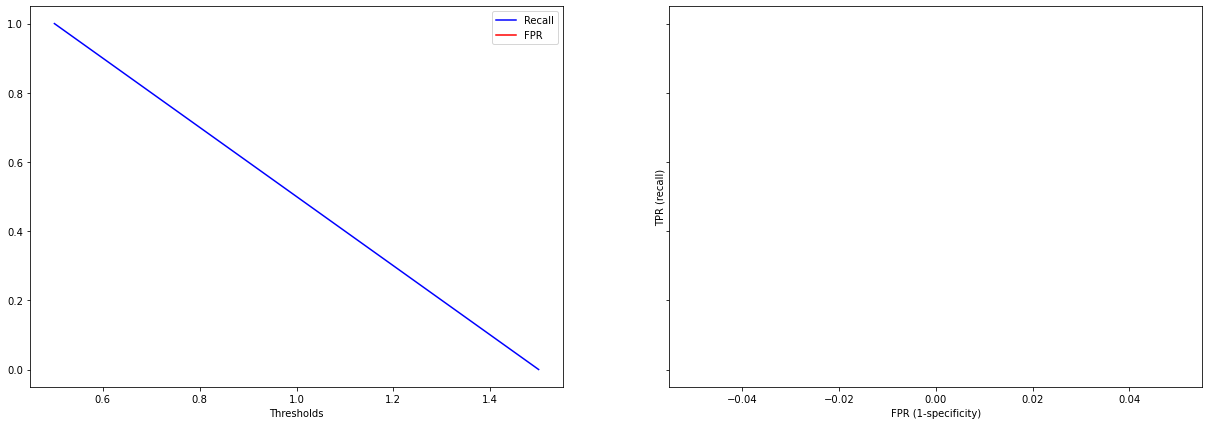

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


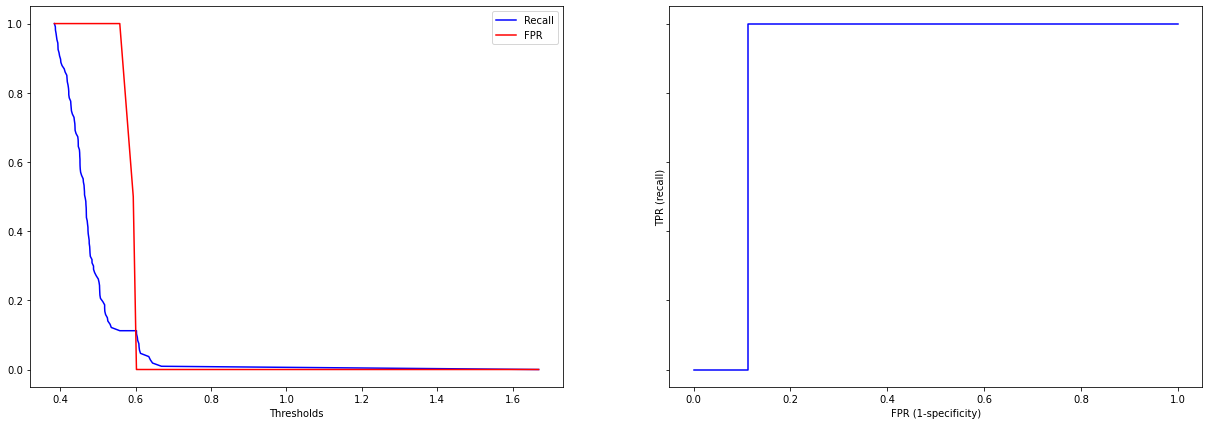

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662337  0.525112   0.723798     0.799493  0.608579  0.724033
Validation  0.663144  0.514012   0.730744     0.812844  0.599382  0.715313


XGBoost Classifier
╠■■■■■■■■■╣


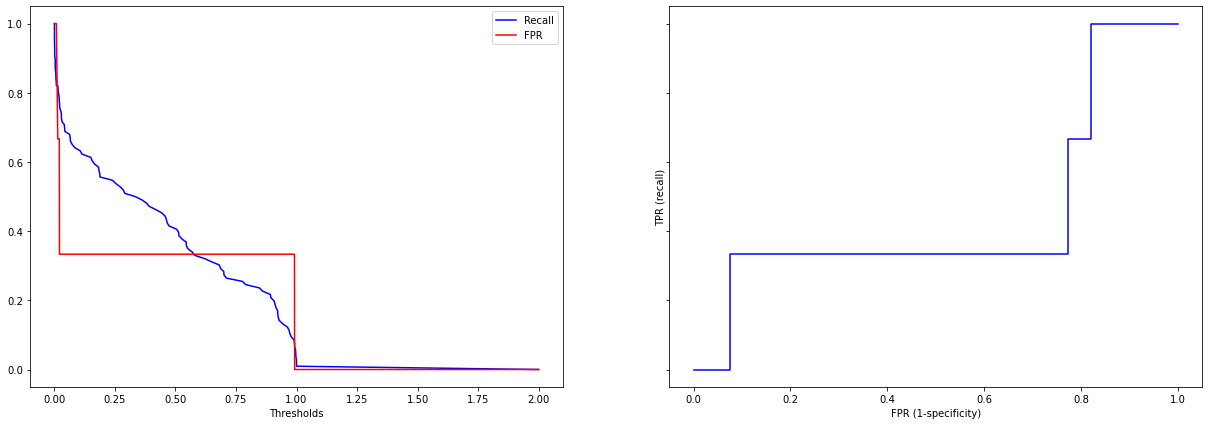

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999645  0.999493   0.999797     0.999797  0.999645  1.000000
Validation  0.614620  0.595405   0.622511     0.633945  0.606816  0.663264


SVM
╠■■■■■■■■■╣


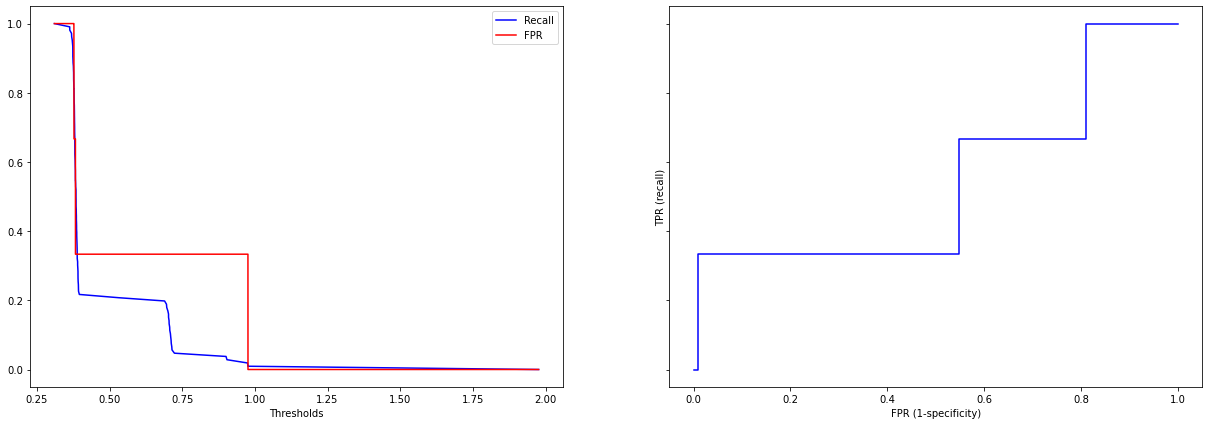

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.678062  0.499440   0.777182     0.856592  0.607765  0.748807
Validation  0.659945  0.482177   0.744495     0.838532  0.581799  0.722883


KNN
╠■■■■■■■■■╣


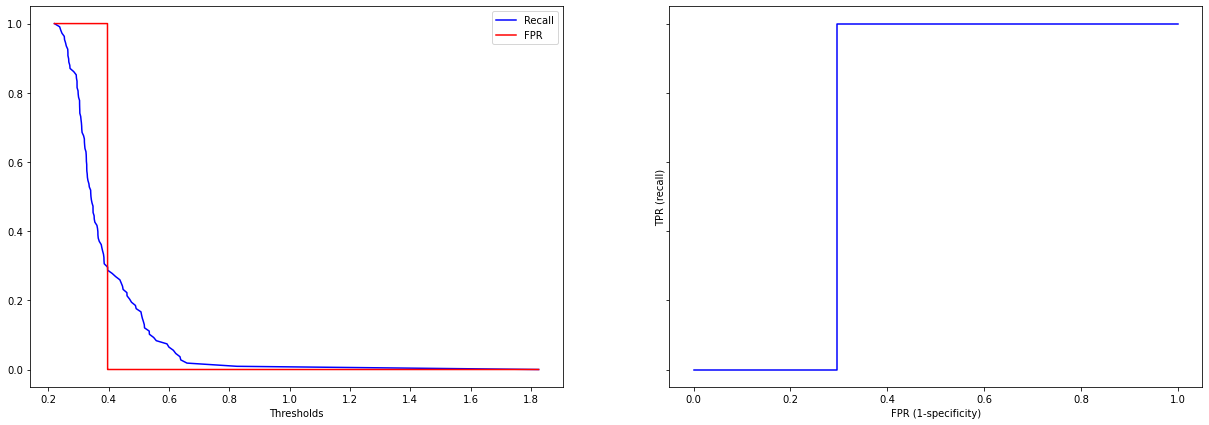

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999645  0.999290   1.000000     1.000000  0.999645  0.999999
Validation  0.628809  0.415421   0.719736     0.843119  0.523781  0.690730


Logistic Regression
╠■■■■■■■■■╣


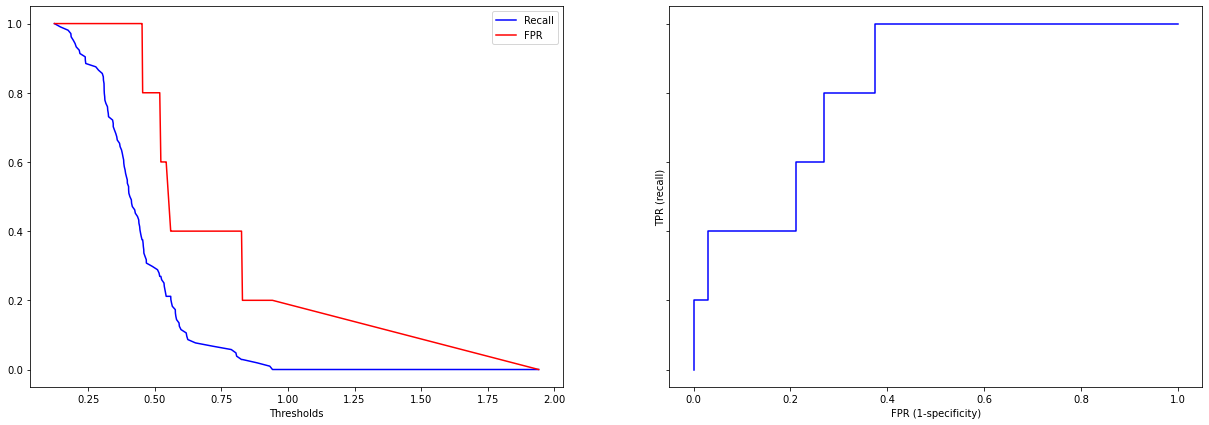

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.686736  0.577673   0.739036     0.795740  0.648197  0.747017
Validation  0.676413  0.551576   0.738905     0.801835  0.628255  0.735015

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.663144  0.514012   0.730744     0.812844   
XGBoost Classifier              0.614620  0.595405   0.622511     0.633945   
SVM                             0.659945  0.482177   0.744495     0.838532   
KNN                             0.628809  0.415421   0.719736     0.843119   
Logistic Regression             0.676413  0.551576   0.738905     0.801835   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.599382  0.715313  
XGBoost Classifier              0.606816  0.663264  
SVM                             0.581799  0.722883  
KNN                             0.523781  0.690730  
Logistic Regression             0.628255  0.735015

In [40]:
#ra_symptoms_svitals
run_models(ra_symptoms_svitals, y[ra_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

All the features that were determined to be important before are also important here

Dummy Random
╠■■■■■■■■■╣


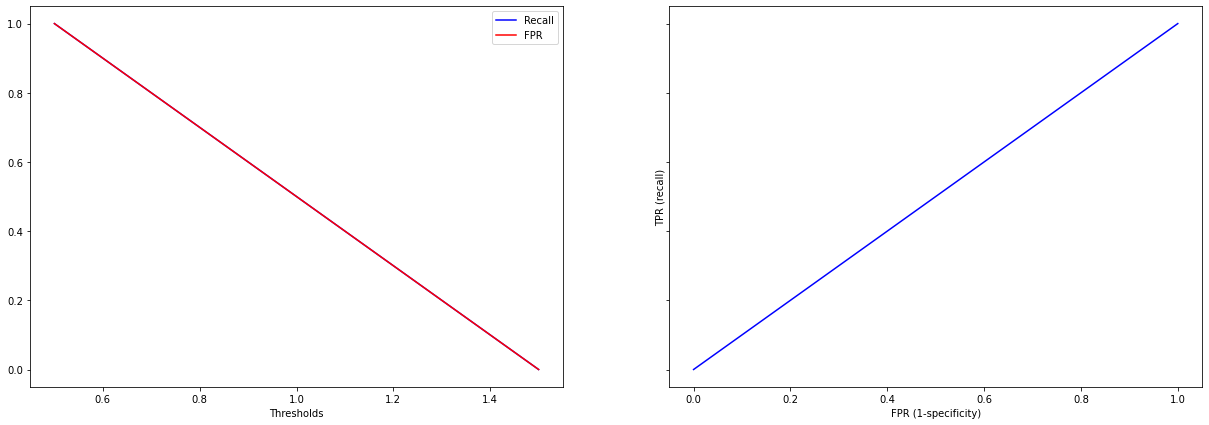

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


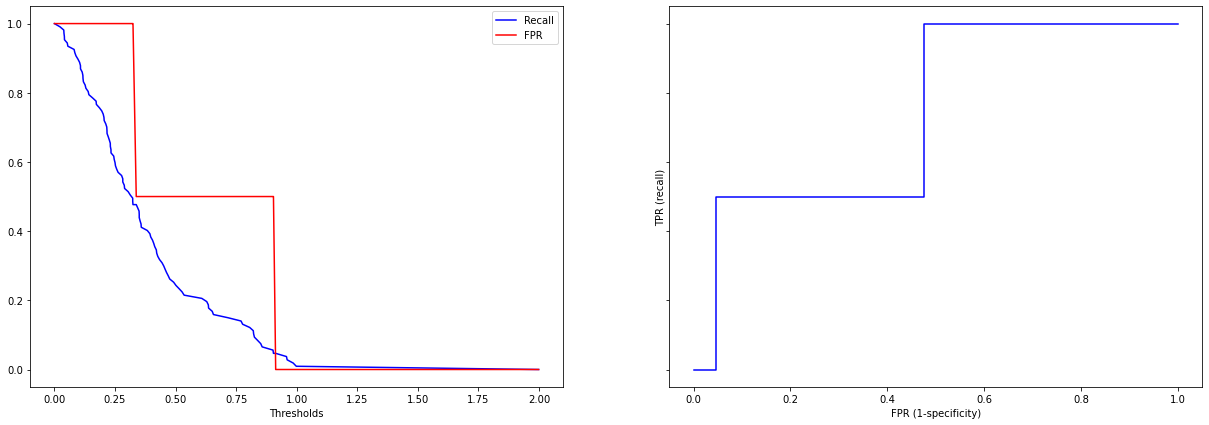

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660665  0.513344   0.727491     0.807911  0.601887  0.711633
Validation  0.660400  0.508624   0.729764     0.812844  0.596895  0.705181


Random Forest (100 estimators)
╠■■■■■■■■■╣


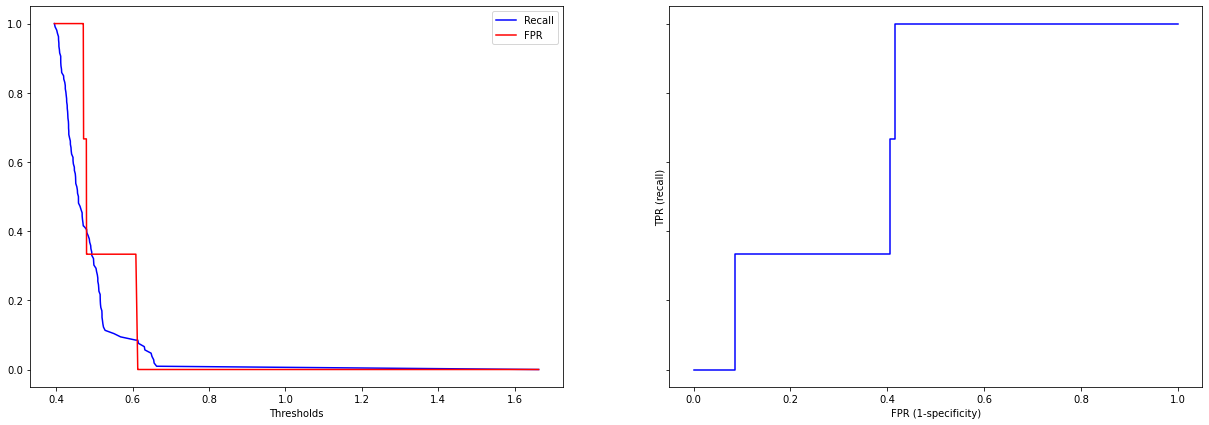

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665787  0.528359   0.728828     0.803144  0.612427  0.731367
Validation  0.648042  0.514971   0.702577     0.781651  0.589389  0.702161


XGBoost Classifier
╠■■■■■■■■■╣


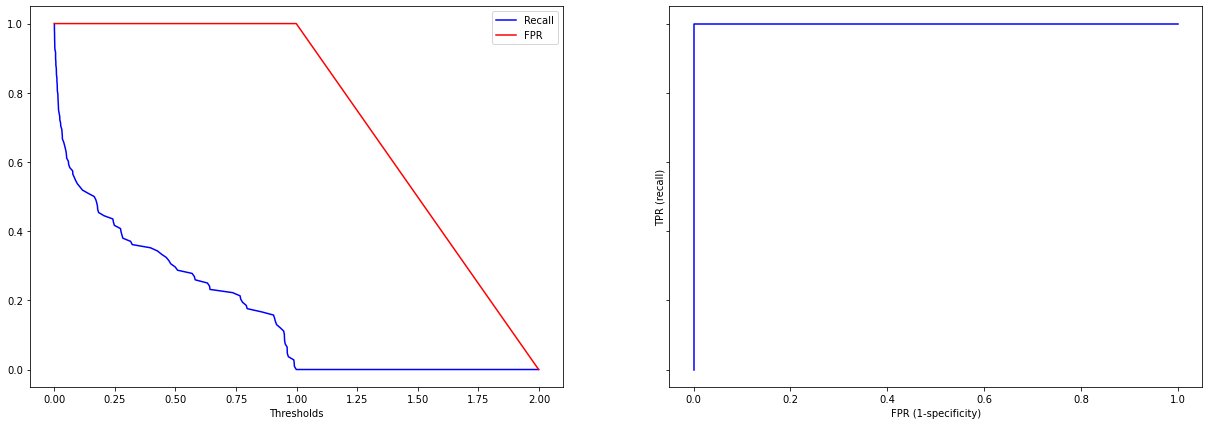

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation  0.625187  0.600917   0.633964     0.649541  0.616559  0.679685


SVM
╠■■■■■■■■■╣


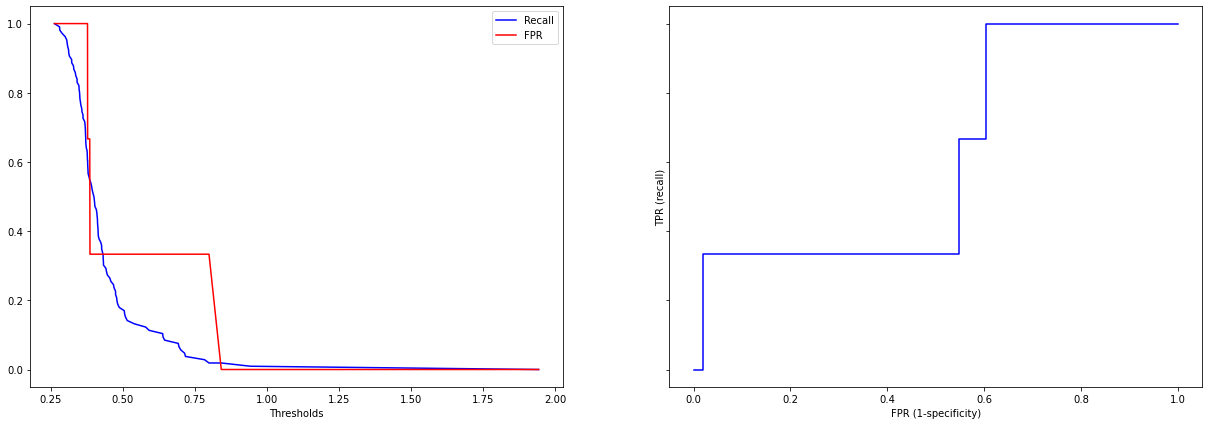

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.671925  0.485435   0.775332     0.858316  0.596005  0.744984
Validation  0.657679  0.469450   0.749198     0.846789  0.572849  0.726112


KNN
╠■■■■■■■■■╣


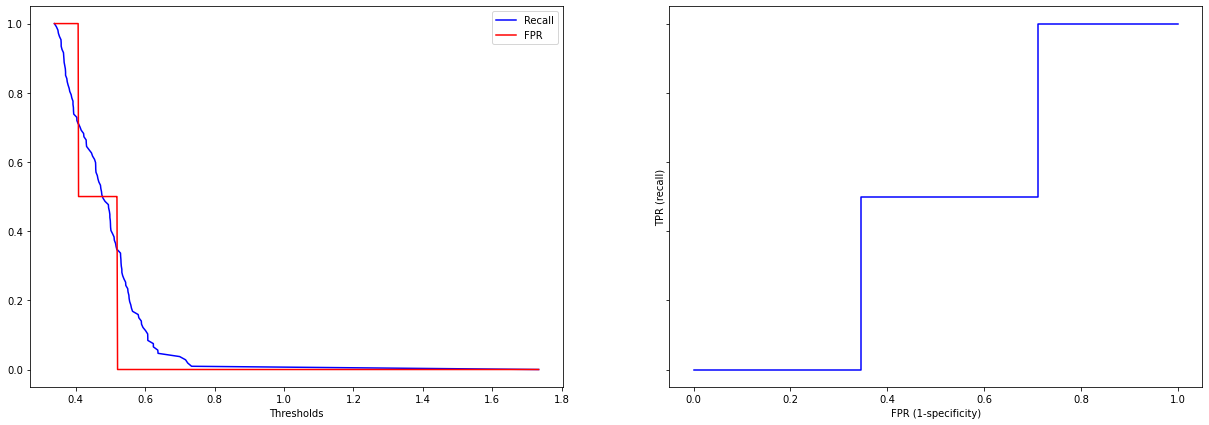

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999696  0.999391   1.000000     1.000000  0.999695  1.000000
Validation  0.568432  0.496714   0.579604     0.640367  0.532446  0.591179


Logistic Regression
╠■■■■■■■■■╣


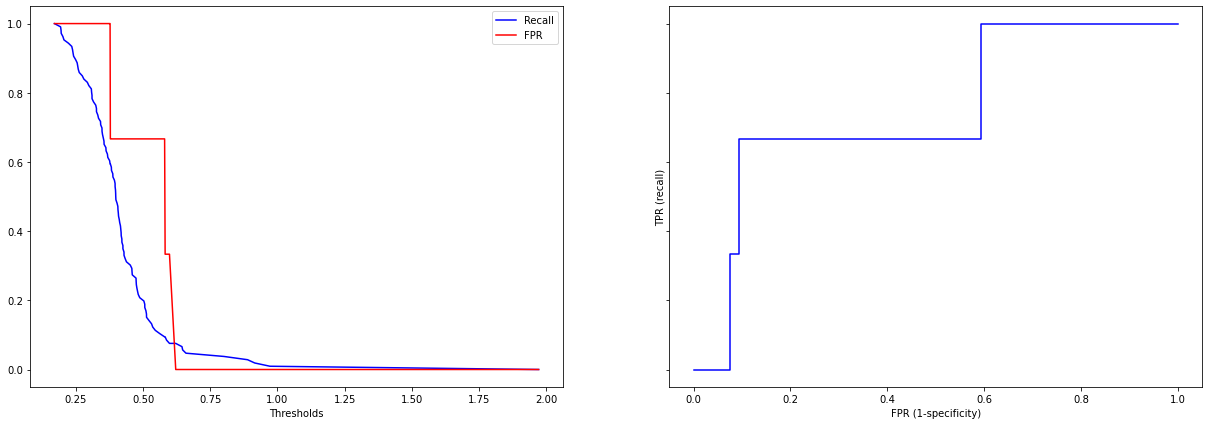

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674005  0.571890   0.718546     0.776065  0.636733  0.738920
Validation  0.676872  0.558932   0.733649     0.795413  0.632612  0.738442

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.660400  0.508624   0.729764     0.812844   
Random Forest (100 estimators)  0.648042  0.514971   0.702577     0.781651   
XGBoost Classifier              0.625187  0.600917   0.633964     0.649541   
SVM                             0.657679  0.469450   0.749198     0.846789   
KNN                             0.568432  0.496714   0.579604     0.640367   
Logistic Regression             0.676872  0.558932   0.733649     0.795413   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.596895  0.705181  
Random Forest (100 estimators)  0.589389  0.702161  
XGBoost Classifier              0.616559  0.679685  
SVM                             0.572849  0.726112  
KNN                             0.532446  0.591179  
Logistic Regression             0.632612  0.738442

In [41]:
#ra_symptoms_vitals_ex
run_models(ra_symptoms_vitals_ex, y[ra_symptoms_vitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


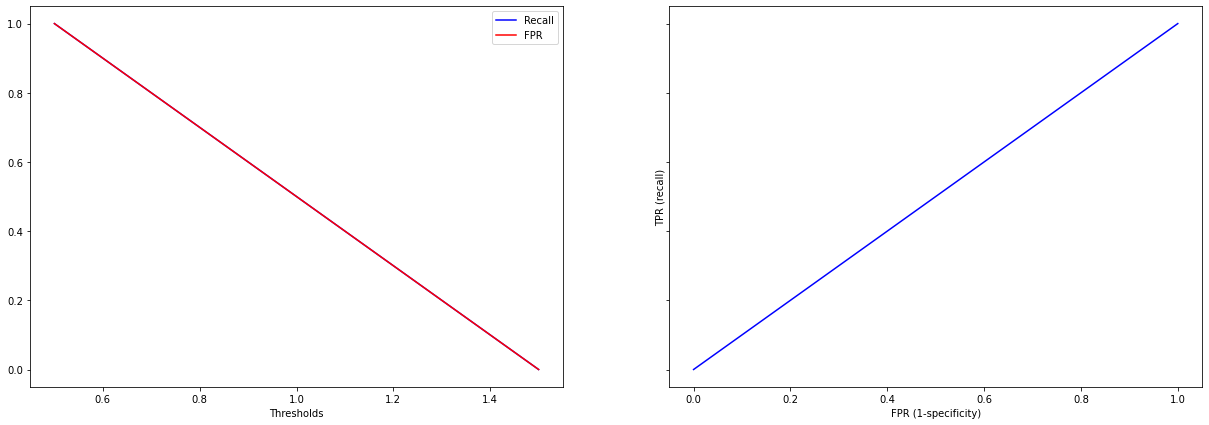

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


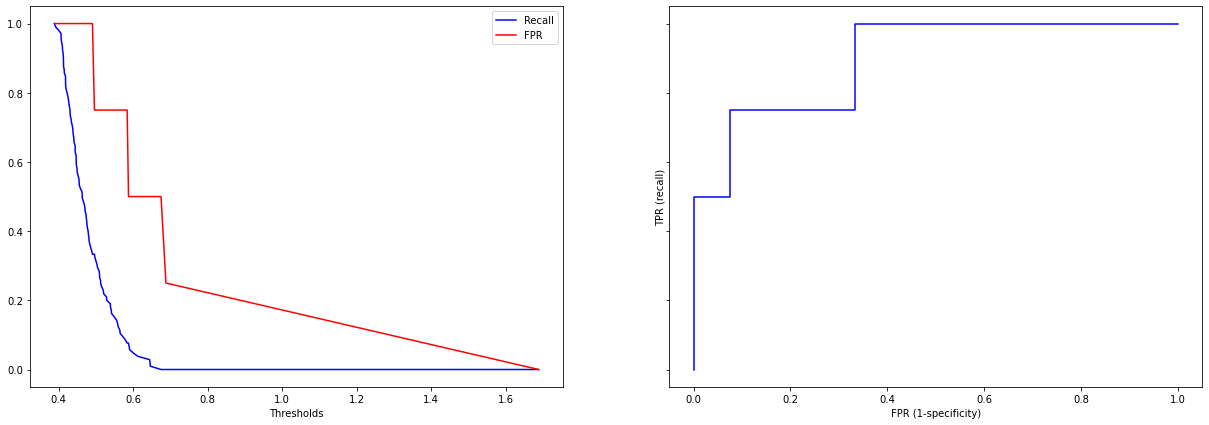

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663556  0.531100   0.722511     0.795943  0.612022  0.726212
Validation  0.652164  0.515872   0.705862     0.788991  0.593326  0.708070


XGBoost Classifier
╠■■■■■■■■■╣


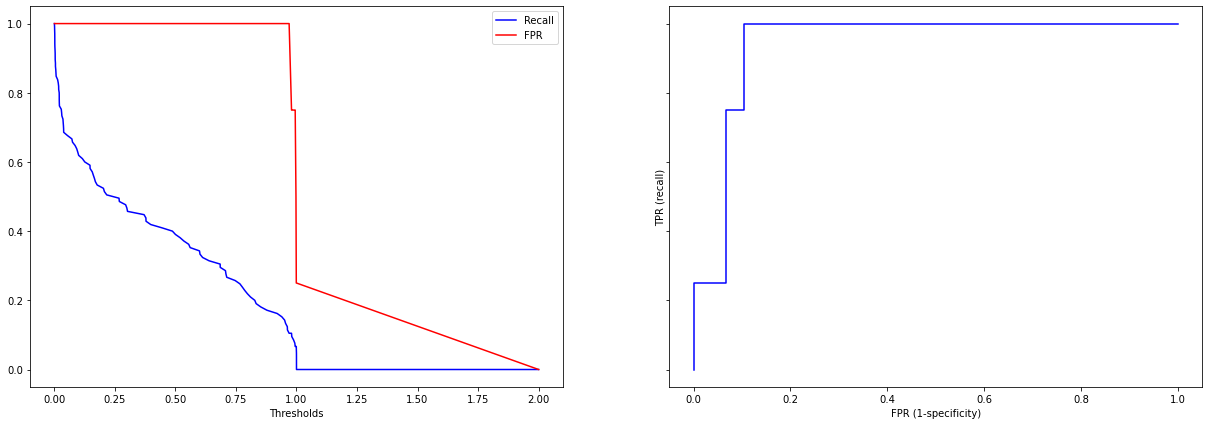

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999949  1.000000   0.999899     0.999899  0.999949  1.000000
Validation  0.629726  0.603578   0.637926     0.655963  0.620167  0.676075


SVM
╠■■■■■■■■■╣


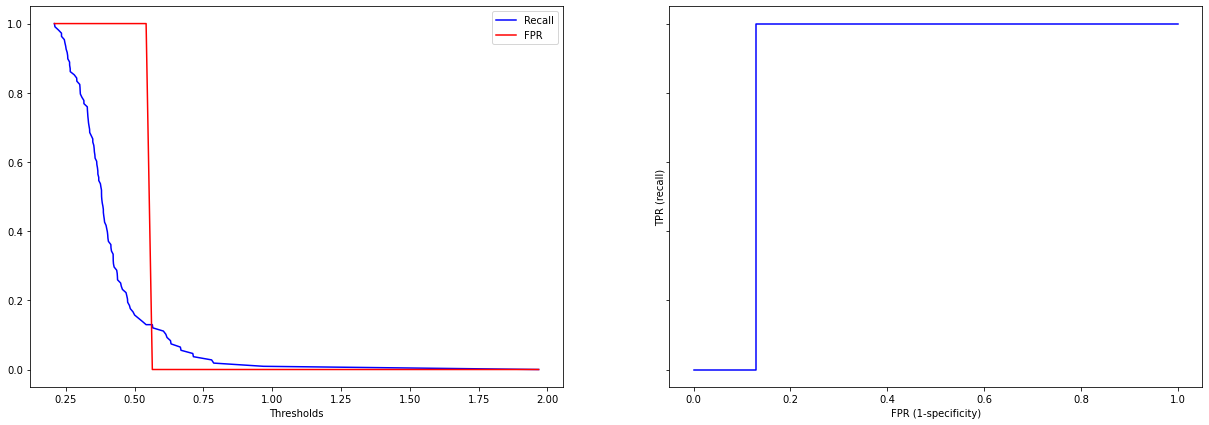

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674613  0.505530   0.764281     0.843611  0.607777  0.747372
Validation  0.669117  0.483128   0.770378     0.855963  0.589328  0.742203


KNN
╠■■■■■■■■■╣


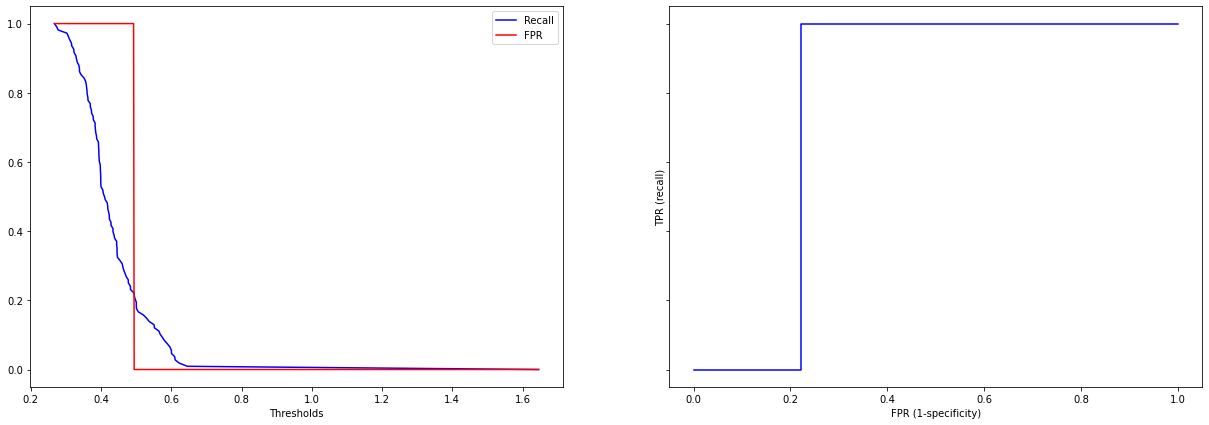

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999949  0.999898    1.00000     1.000000  0.999949  1.000000
Validation  0.630177  0.436447    0.71463     0.824771  0.538198  0.689111


Logistic Regression
╠■■■■■■■■■╣


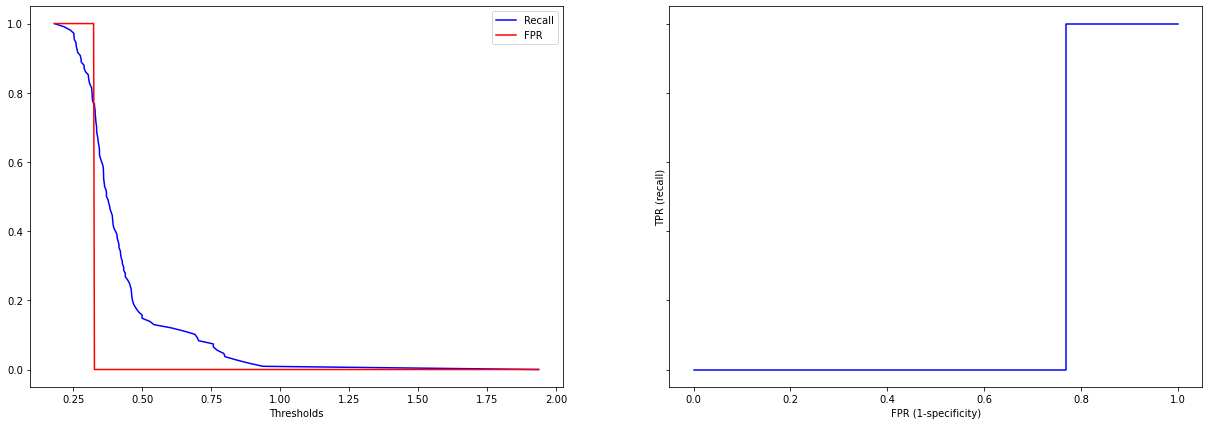

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685620  0.587417   0.731033     0.783773  0.651327  0.750636
Validation  0.666794  0.555104   0.715922     0.778899  0.623813  0.722242

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.652164  0.515872   0.705862     0.788991   
XGBoost Classifier              0.629726  0.603578   0.637926     0.655963   
SVM                             0.669117  0.483128   0.770378     0.855963   
KNN                             0.630177  0.436447   0.714630     0.824771   
Logistic Regression             0.666794  0.555104   0.715922     0.778899   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.593326  0.708070  
XGBoost Classifier              0.620167  0.676075  
SVM                             0.589328  0.742203  
KNN                             0.538198  0.689111  
Logistic Regression             0.623813  0.722242

In [42]:
#ra_symptoms_nvitals_ex
run_models(ra_symptoms_nvitals_ex, y[ra_symptoms_nvitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


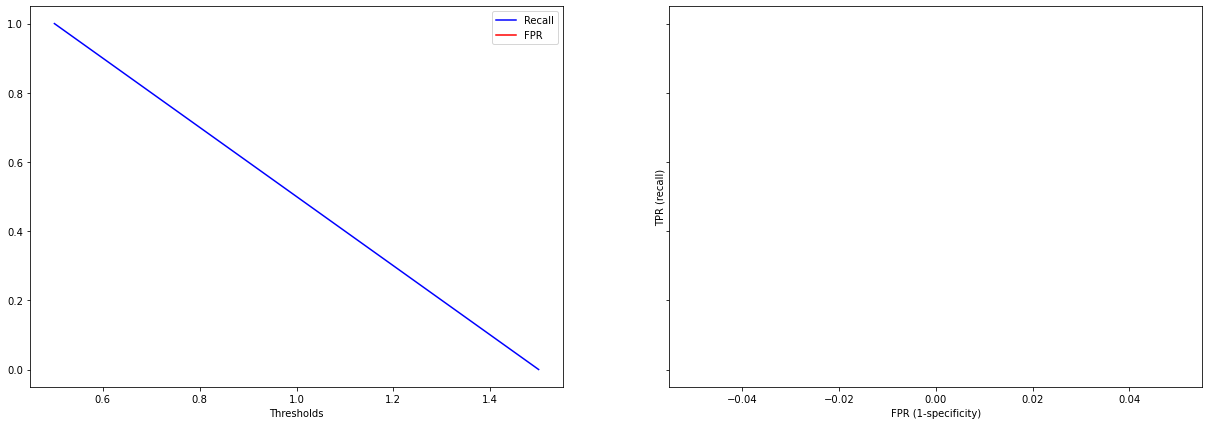

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


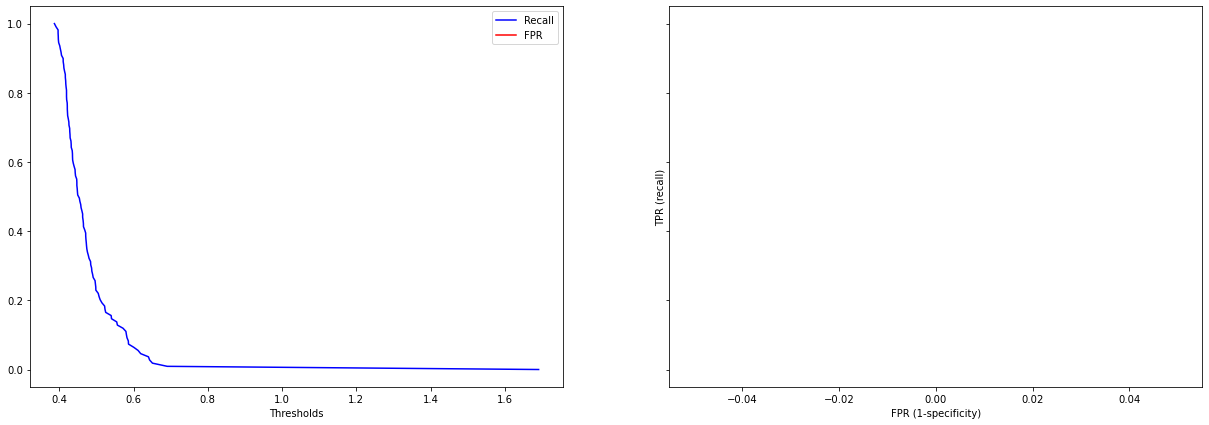

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666345  0.525313   0.732106     0.807302  0.611429  0.732041
Validation  0.634280  0.500350   0.682882     0.768807  0.572782  0.695265


XGBoost Classifier
╠■■■■■■■■■╣


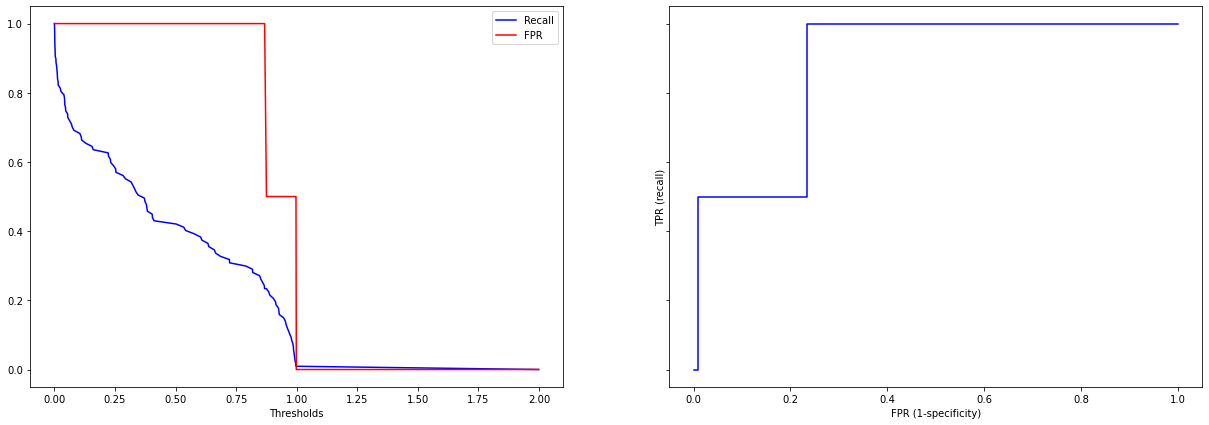

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999899   0.999797     0.999797  0.999848  1.000000
Validation  0.620619  0.593661   0.628902     0.647706  0.609745  0.672225


SVM
╠■■■■■■■■■╣


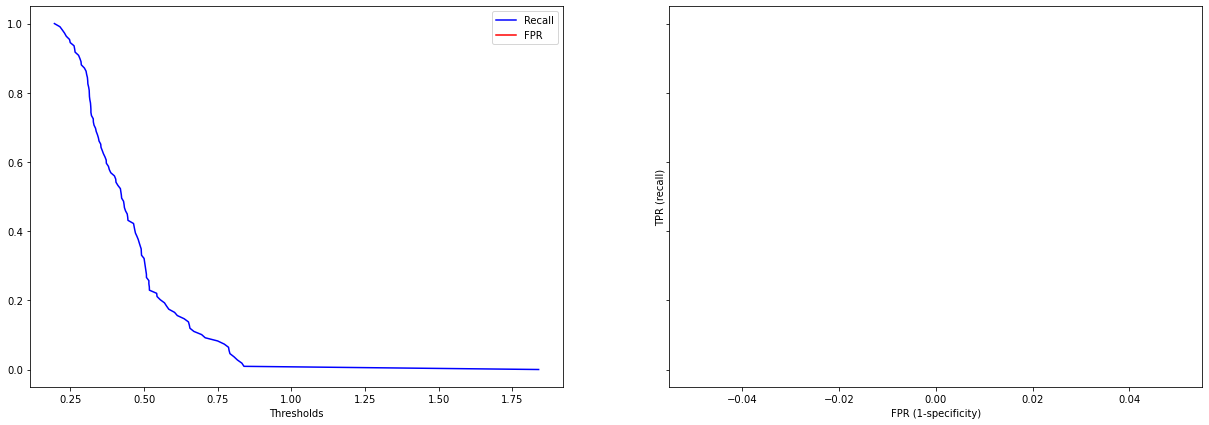

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676237  0.504217   0.769184     0.848174  0.608532  0.748001
Validation  0.664518  0.484837   0.754398     0.844954  0.585376  0.739304


KNN
╠■■■■■■■■■╣


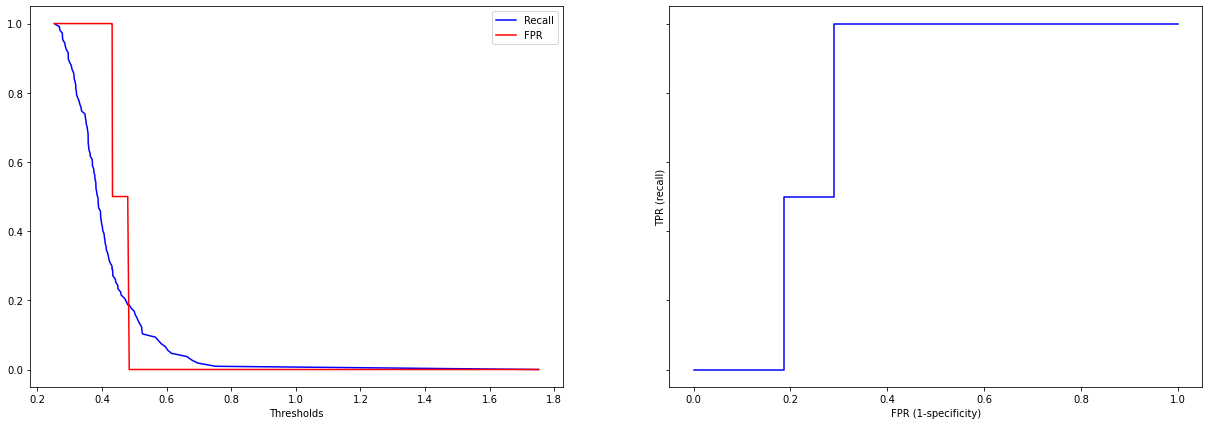

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999949  0.999898   1.000000     1.000000  0.999949  1.000000
Validation  0.617366  0.417306   0.698196     0.818349  0.517570  0.678772


Logistic Regression
╠■■■■■■■■■╣


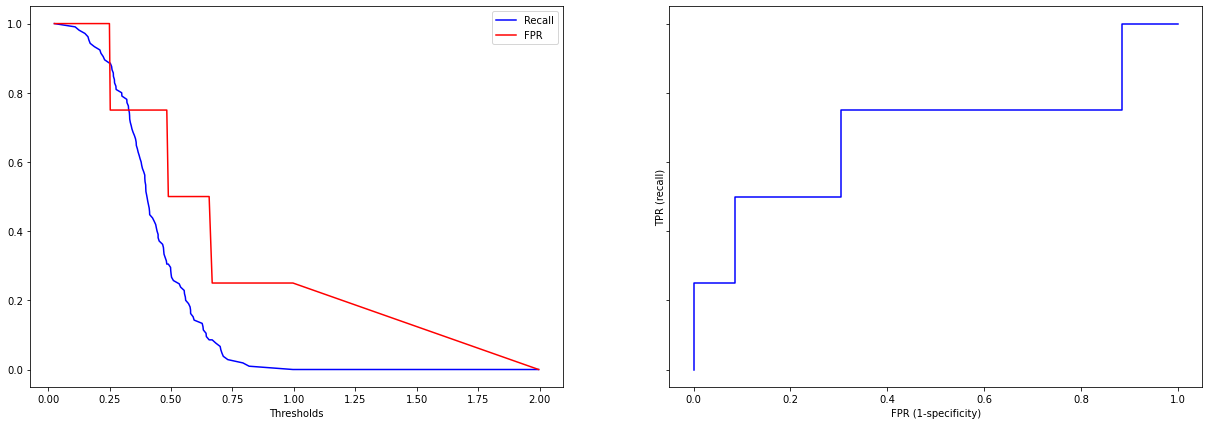

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688663  0.585691   0.737474     0.791582  0.652814  0.751775
Validation  0.672789  0.556130   0.728127     0.789908  0.628817  0.738656

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.634280  0.500350   0.682882     0.768807   
XGBoost Classifier              0.620619  0.593661   0.628902     0.647706   
SVM                             0.664518  0.484837   0.754398     0.844954   
KNN                             0.617366  0.417306   0.698196     0.818349   
Logistic Regression             0.672789  0.556130   0.728127     0.789908   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.572782  0.695265  
XGBoost Classifier              0.609745  0.672225  
SVM                             0.585376  0.739304  
KNN                             0.517570  0.678772  
Logistic Regression             0.628817  0.738656

In [43]:
#ra_symptoms_svitals_ex
run_models(ra_symptoms_svitals_ex, y[ra_symptoms_svitals_ex.index], models, ratio_negatives_to_positives=1)

Notes:

I made a pass through all the metrics selecting the best algorithm for each one. Then, for the ones with notes I look at the recall and if the note is not satisfactory, I look for the second best. 
Repeat the process untill we find the real best metric.

|Best Metric|Model|Dataset|Value|Cons|
| :-| -: | -: | -: | -: |
|Accuracy| Logistic Regression|ra_symptoms_svitals_ex| 0.684209| None |
|Recall | XGBoost | ra_symptoms_vitals_ex |0.614604| Average everywhere else (but above .5)|
|Precision | SVM | ra_symptoms_vitals | 0.775354 | Recall below .5 (but above .4)|
|Specificity | SVM | ra_symptoms_vitals | 0.863303 | Recall below .5 (but above.4) |
|F1 Score | Logistic Regression |ra_symptoms_svitals_ex| 0.646409 | None |
|ROC_AUC Score | Logistic Regression | ra_symptoms_svitals_ex | 0.742775 | None |

Logistic Regression with ra_symptoms_svitals_ex seems to be the best.

In [21]:
selected_features = ["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["asthma", "smoker", "diabetes"]], left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


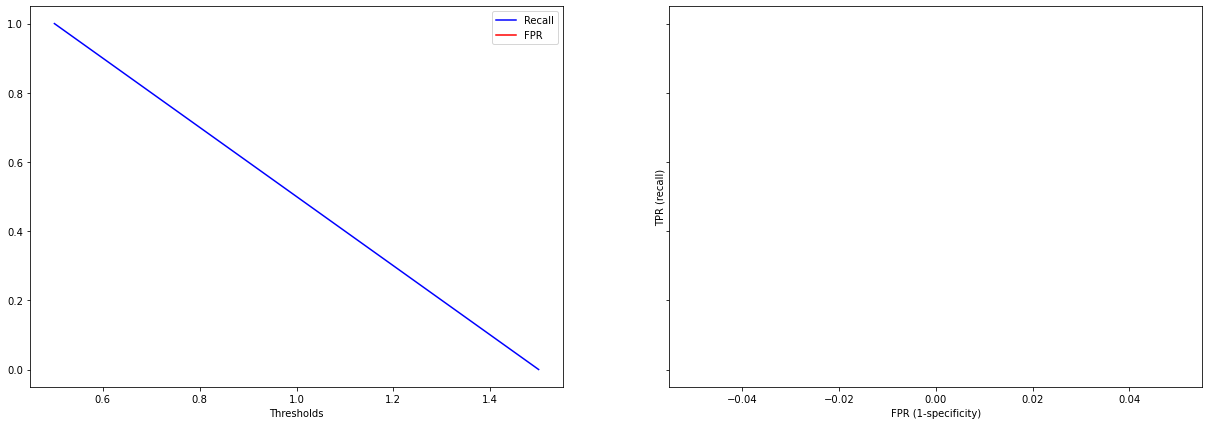

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


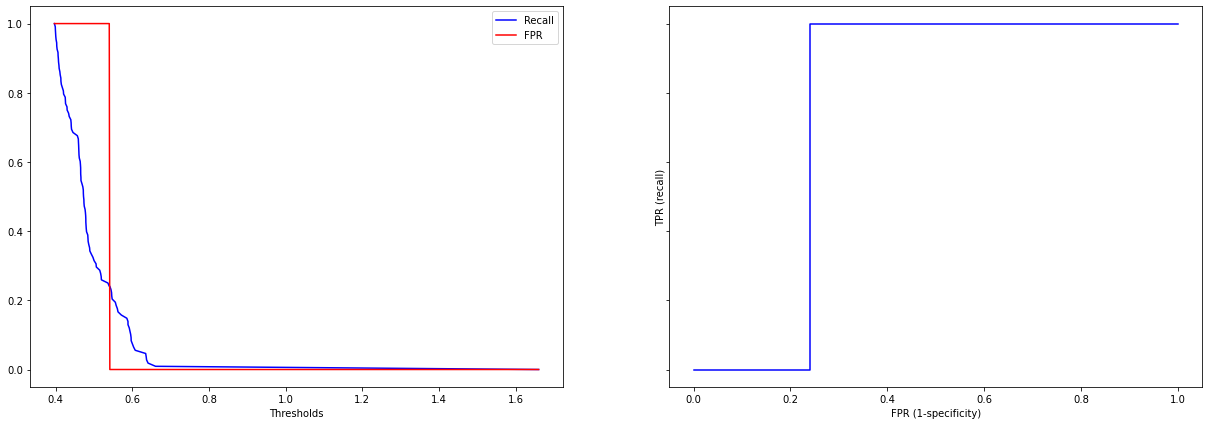

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660563  0.573919   0.694494     0.747160  0.628160  0.719530
Validation  0.650316  0.553311   0.686361     0.747706  0.609771  0.701195


XGBoost Classifier
╠■■■■■■■■■╣


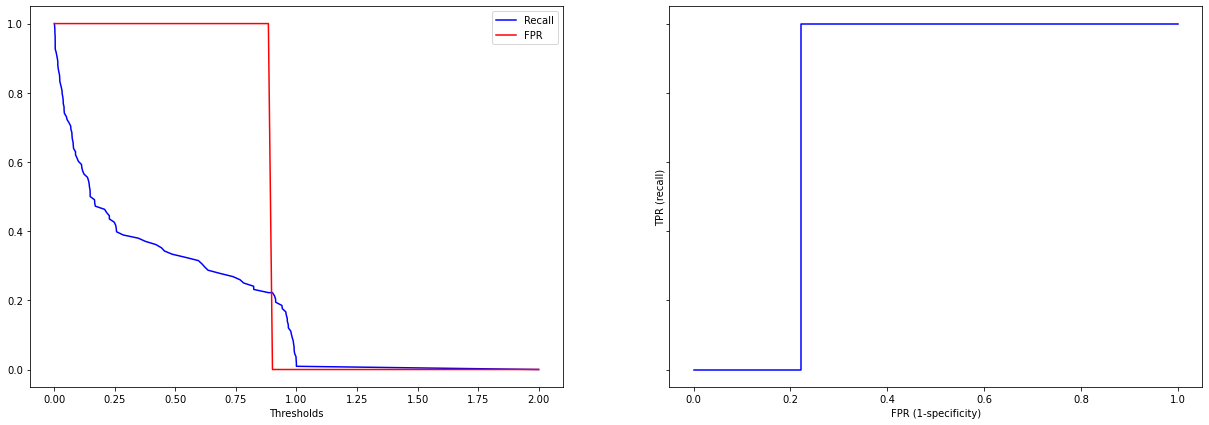

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.967690  0.954744   0.980125     0.980629  0.967256  0.996825
Validation  0.622441  0.610909   0.627071     0.633945  0.618080  0.675377


SVM
╠■■■■■■■■■╣


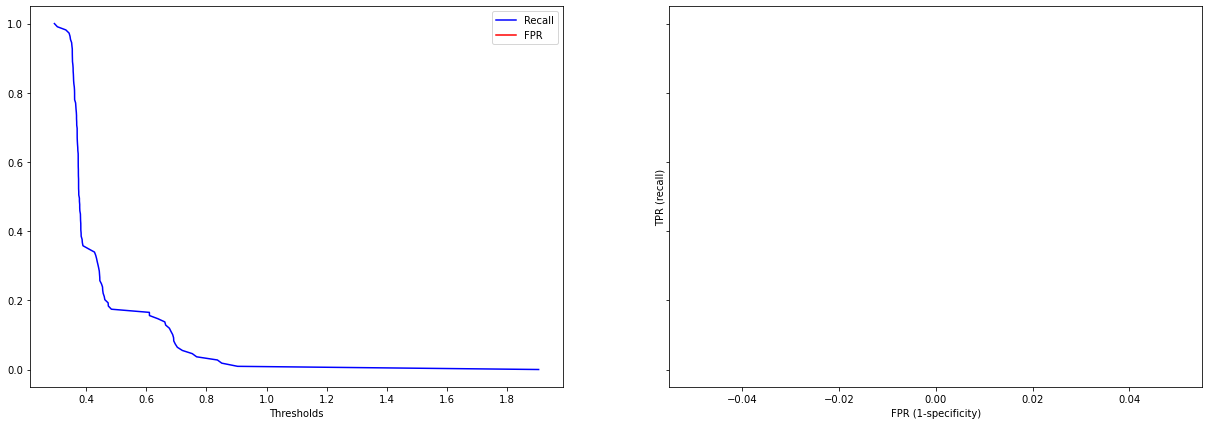

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675323  0.498626   0.771426     0.851927  0.605282  0.746354
Validation  0.672777  0.486731   0.774422     0.859633  0.594066  0.739063


KNN
╠■■■■■■■■■╣


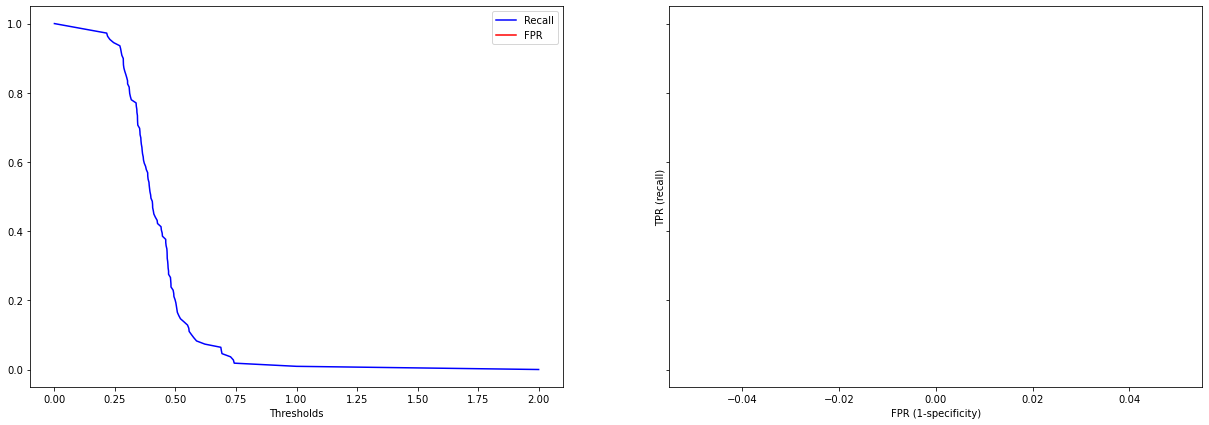

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.980573  0.963775   0.997274     0.997363  0.980232  0.999203
Validation  0.633813  0.460150   0.703394     0.808257  0.554618  0.688360


Logistic Regression
╠■■■■■■■■■╣


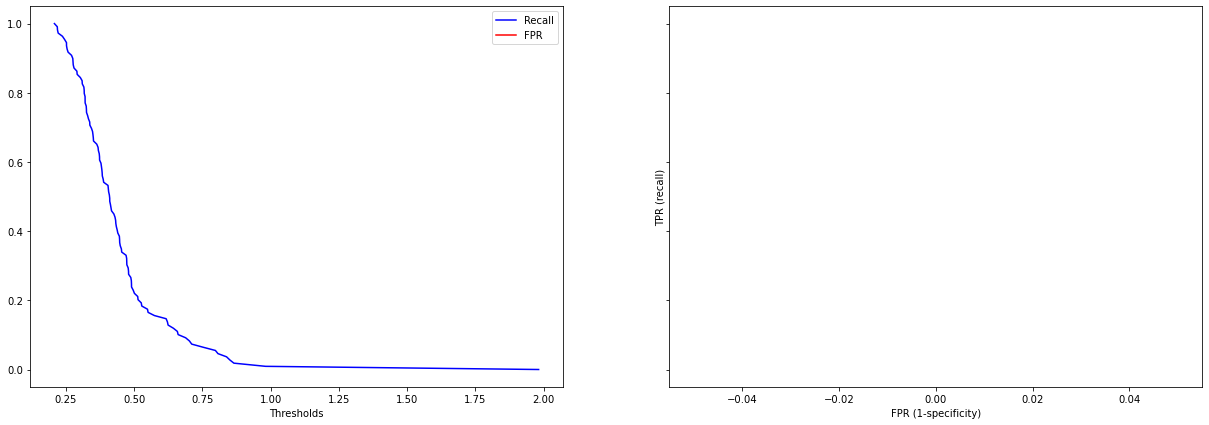

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693635  0.582952   0.748617     0.804260  0.655385  0.749679
Validation  0.677295  0.564304   0.729748     0.790826  0.634849  0.732539

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.650316  0.553311   0.686361     0.747706   
XGBoost Classifier              0.622441  0.610909   0.627071     0.633945   
SVM                             0.672777  0.486731   0.774422     0.859633   
KNN                             0.633813  0.460150   0.703394     0.808257   
Logistic Regression             0.677295  0.564304   0.729748     0.790826   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.609771  0.701195  
XGBoost Classifier              0.618080  0.675377  
SVM                             0.594066  0.739063  
KNN                             0.554618  0.688360  
Logistic Regression             0.634849  0.732539

In [45]:
run_models(selected_dataset, y[selected_dataset.index], models, ratio_negatives_to_positives=1)


╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


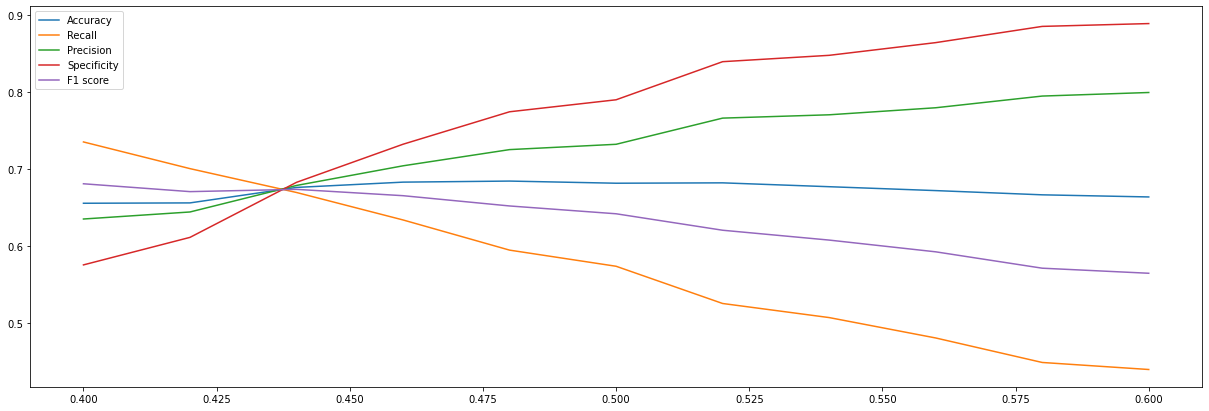

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.655362  0.655827  0.675958  0.682826  0.684205  0.681417   
Recall       0.735088  0.700384  0.669366  0.633653  0.594429  0.573445   
Precision    0.634892  0.644029  0.678517  0.704057  0.725120  0.732034   
Specificity  0.575229  0.611009  0.682569  0.732110  0.774312  0.789908   
F1           0.680698  0.670485  0.673436  0.665206  0.651851  0.641689   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.681901  0.676886  0.671830  0.666329  0.663573  
Recall       0.525038  0.506731  0.480217  0.448357  0.439208  
Precision    0.766070  0.770386  0.779539  0.794740  0.799378  
Specificity  0.839450  0.847706  0.864220  0.885321  0.888991  
F1           0.620286  0.607484  0.592223  0.570936  0.564350

In [46]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11))

With the dataset <b>selected_features</b> and a threshold of <b>.44</b> (for high recall), <b>Logistic Regression</b> seems to be the best out of all algorithms

Probably it might be a good idea to move everything from this point forward to another notebook

## Ensemble models

In [22]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [23]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
FirstEnsembleModel       0.0     0.0        0.0          0.0  0.0      0.0

In [24]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [25]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



LogisticVanilla
╠■■■■■■■■■╣


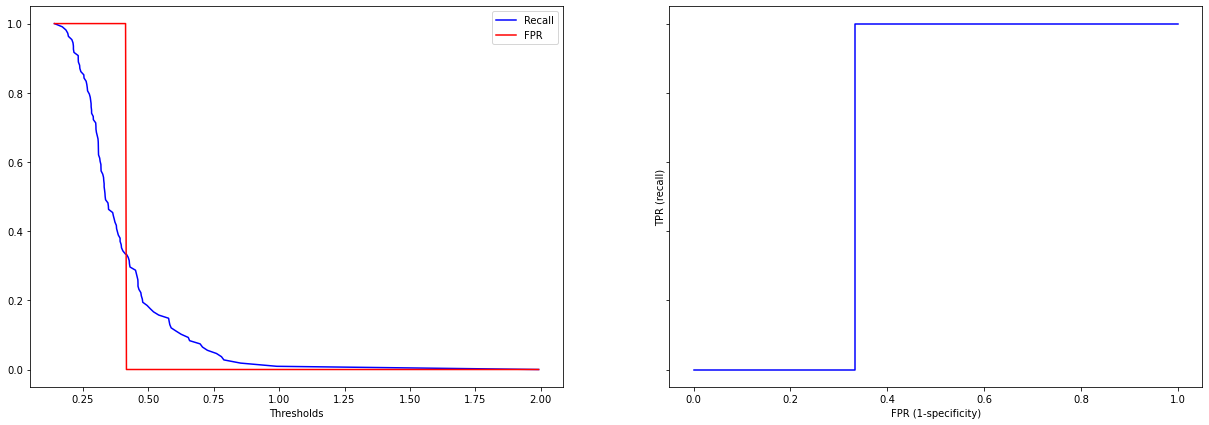

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.687293  0.577775   0.740029     0.796755  0.648771  0.746179
Validation  0.675950  0.564295   0.728174     0.788073  0.632530  0.735469


LogisticStrongRegularization
╠■■■■■■■■■╣


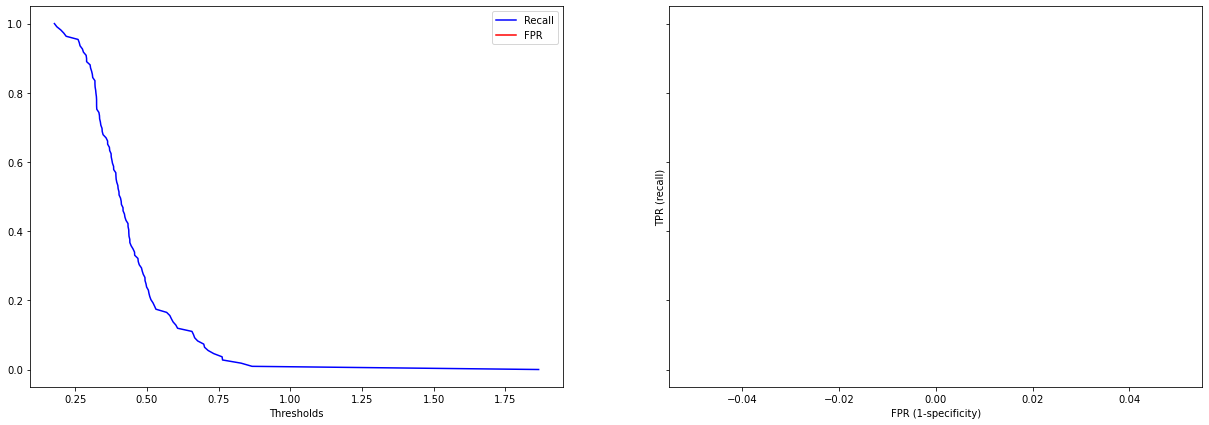

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690338  0.579504   0.744814     0.801116  0.651637  0.747995
Validation  0.683727  0.567031   0.740507     0.800917  0.640913  0.740023


LogisticWeakRegularization
╠■■■■■■■■■╣


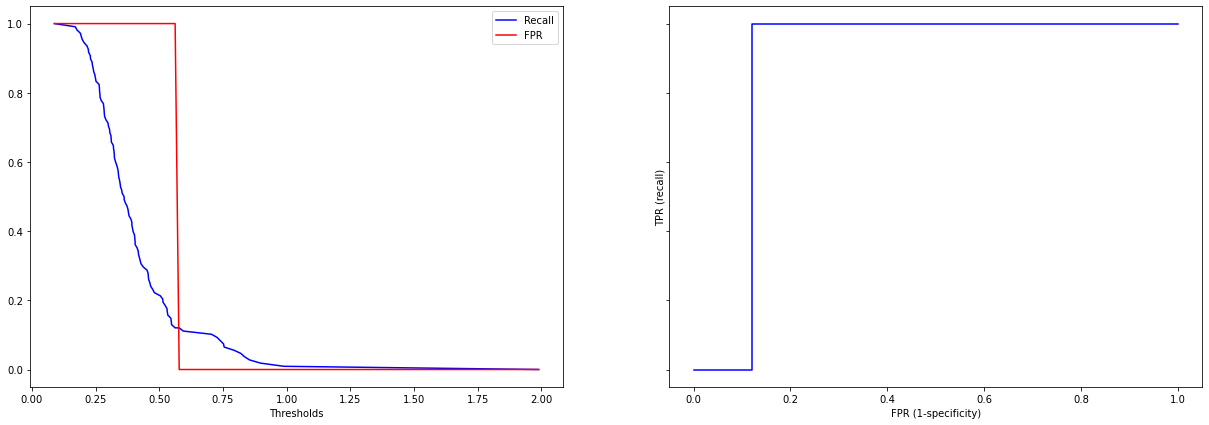

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689019  0.582851   0.740002     0.795132  0.651957  0.749864
Validation  0.682814  0.563386   0.742598     0.802752  0.638808  0.740757


AdaBoost
╠■■■■■■■■■╣


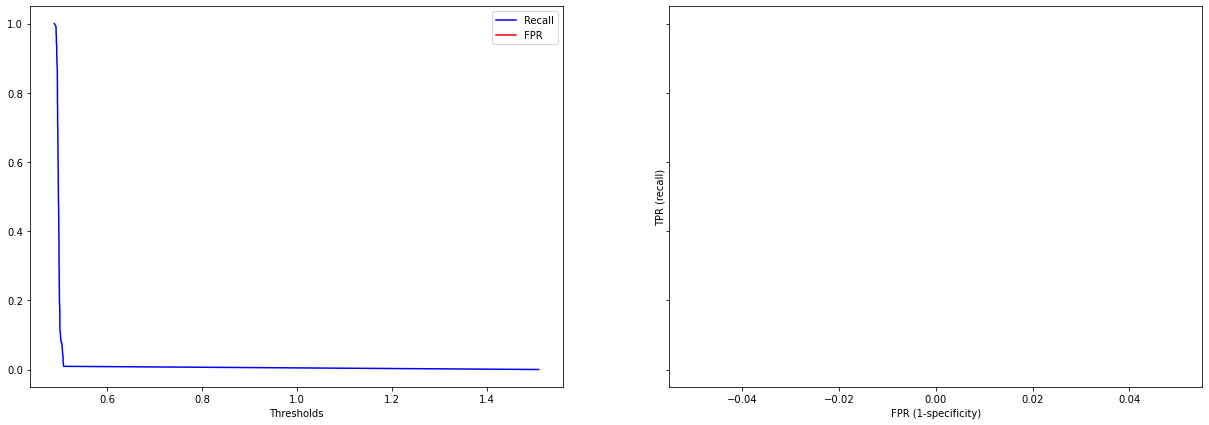

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.680700  0.589549   0.720911     0.771805  0.648585  0.738039
Validation  0.680977  0.575263   0.729323     0.787156  0.641519  0.736577

Accuracy    Recall  Precision  Specificity  \
LogisticVanilla               0.675950  0.564295   0.728174     0.788073   
LogisticStrongRegularization  0.683727  0.567031   0.740507     0.800917   
LogisticWeakRegularization    0.682814  0.563386   0.742598     0.802752   
AdaBoost                      0.680977  0.575263   0.729323     0.787156   

                                    F1   ROC_AUC  
LogisticVanilla               0.632530  0.735469  
LogisticStrongRegularization  0.640913  0.740023  
LogisticWeakRegularization    0.638808  0.740757  
AdaBoost                      0.641519  0.736577

In [29]:
run_models(selected_dataset, y[selected_dataset.index], logistic_model_group, folds=10, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.25
╠■■■■■■■■■╣
Threshold: 0.275
╠■■■■■■■■■╣
Threshold: 0.3
╠■■■■■■■■■╣
Threshold: 0.325
╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.375
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42500000000000004
╠■■■■■■■■■╣
Threshold: 0.45
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.5


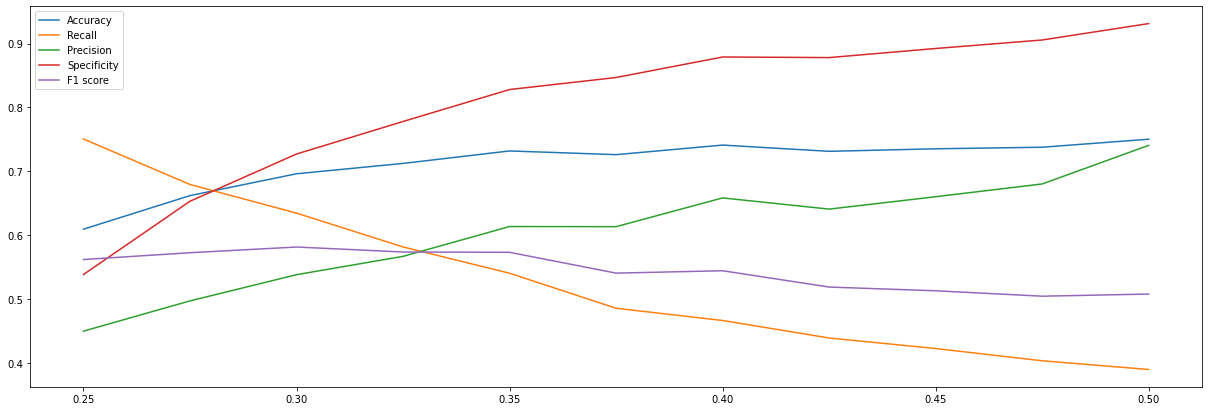

0.250     0.275     0.300     0.325     0.350     0.375  \
Accuracy     0.609453  0.661985  0.696179  0.712360  0.731884  0.726089   
Recall       0.750584  0.679391  0.634621  0.581676  0.540550  0.485738   
Precision    0.449903  0.497255  0.538253  0.566950  0.613593  0.613401   
Specificity  0.538532  0.653211  0.727064  0.777982  0.827982  0.846789   
F1           0.561956  0.572640  0.581551  0.573756  0.573285  0.540685   

                0.400     0.425     0.450     0.475     0.500  
Accuracy     0.741060  0.731289  0.735251  0.737709  0.750223  
Recall       0.466589  0.439199  0.422736  0.403545  0.389892  
Precision    0.658387  0.640871  0.660250  0.680250  0.740667  
Specificity  0.878899  0.877982  0.892202  0.905505  0.931193  
F1           0.544429  0.518908  0.513067  0.504604  0.507962

In [30]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(0.25,0.5,num=11), ratio_negatives_to_positives=2)

In general it seems that normal logistic regression beats all of the other datasets, although by running the experiment multiple times there is no clear winner (all of the results vary a lot to decide a clear winner

In [27]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


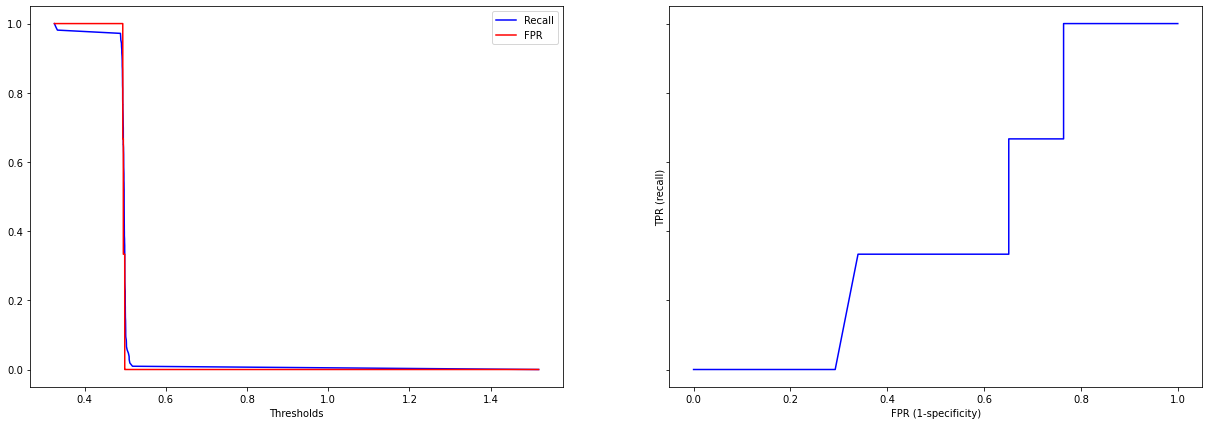

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694091  0.582038   0.750148     0.806085  0.655358  0.762100
Validation  0.661774  0.562460   0.702377     0.761468  0.622632  0.713559


Ada Logistic
╠■■■■■■■■■╣


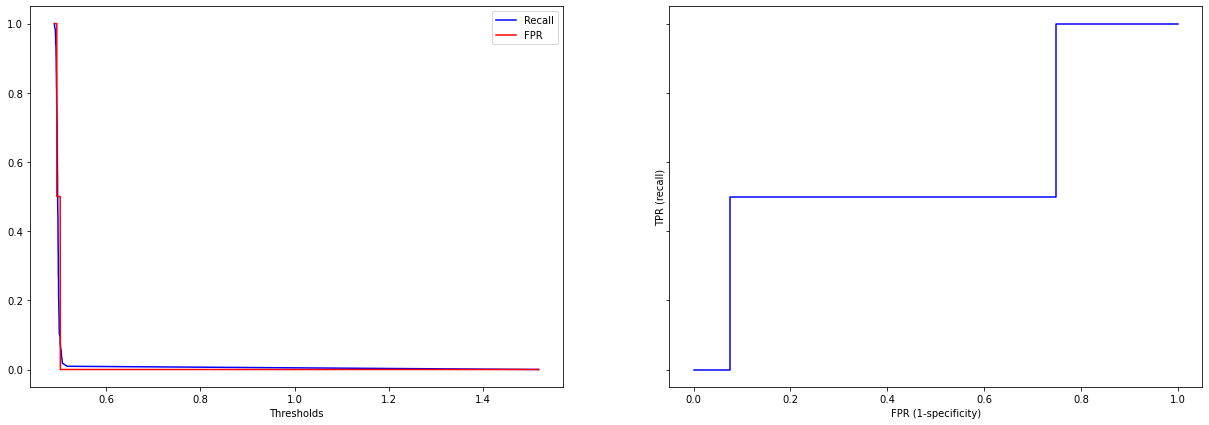

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.686178  0.593807   0.728263     0.778499  0.654145  0.743307
Validation  0.668594  0.588941   0.703013     0.748624  0.639005  0.713502


Ada algo
╠■■■■■■■■■╣


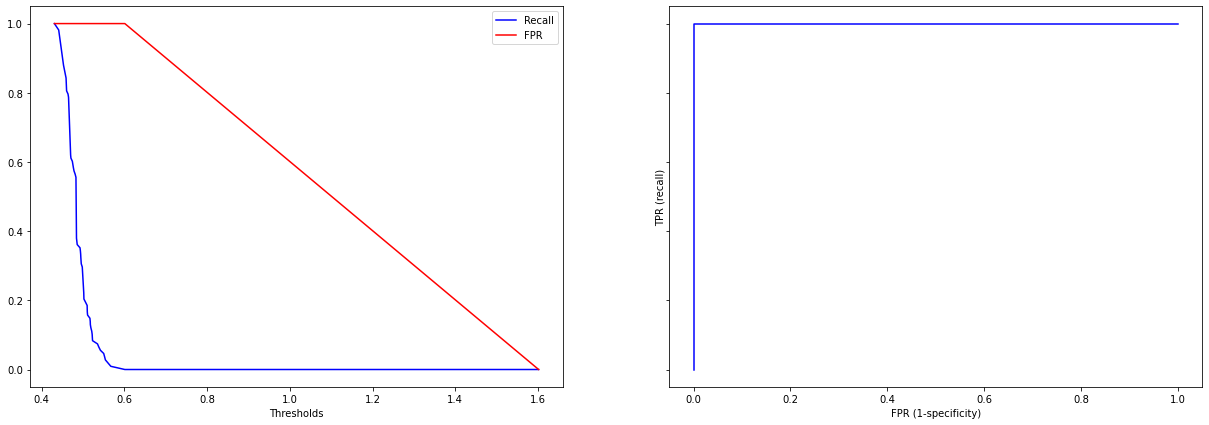

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.677757  0.577164   0.723695     0.778296  0.641300  0.734247
Validation  0.664030  0.557907   0.710372     0.770642  0.620238  0.710839


Ada learning rate
╠■■■■■■■■■╣


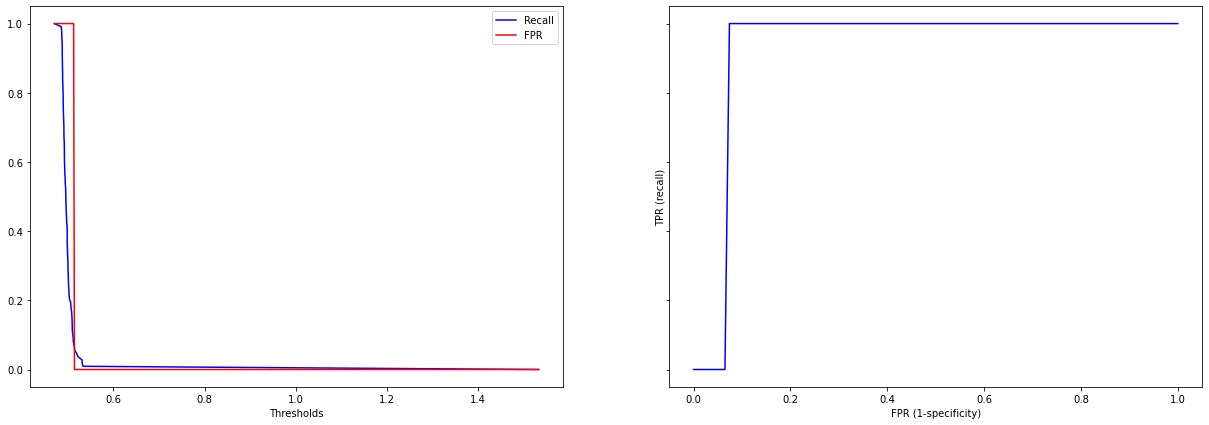

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689729  0.570471   0.749287     0.808925  0.647555  0.756887
Validation  0.678223  0.543194   0.744137     0.813761  0.625773  0.732011


Ada complete
╠■■■■■■■■■╣


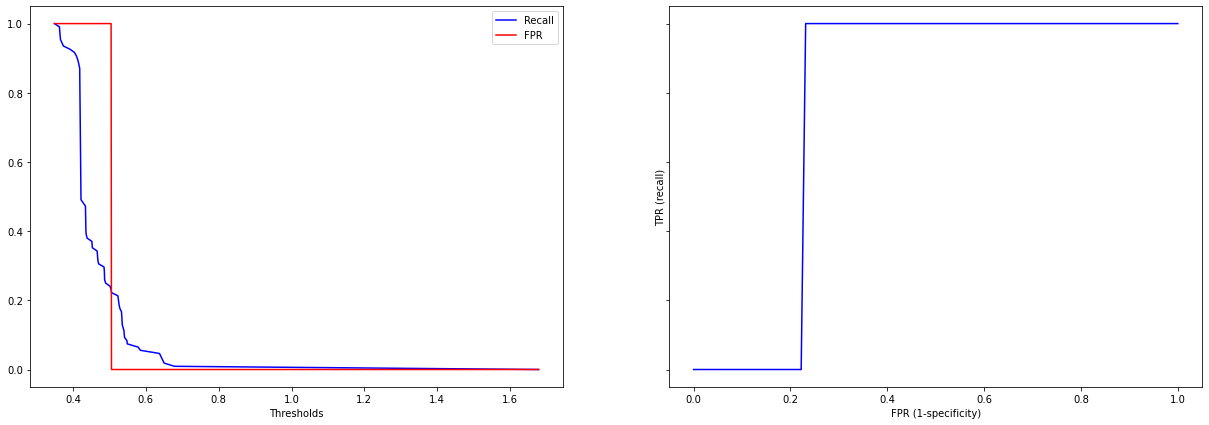

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675373  0.626684   0.694774     0.724037  0.658491  0.730682
Validation  0.657199  0.611768   0.674487     0.702752  0.638306  0.708222

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.661774  0.562460   0.702377     0.761468  0.622632   
Ada Logistic       0.668594  0.588941   0.703013     0.748624  0.639005   
Ada algo           0.664030  0.557907   0.710372     0.770642  0.620238   
Ada learning rate  0.678223  0.543194   0.744137     0.813761  0.625773   
Ada complete       0.657199  0.611768   0.674487     0.702752  0.638306   

                    ROC_AUC  
Ada Vanilla        0.713559  
Ada Logistic       0.713502  
Ada algo           0.710839  
Ada learning rate  0.732011  
Ada complete       0.708222

In [53]:
run_models(selected_dataset, y[selected_dataset.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


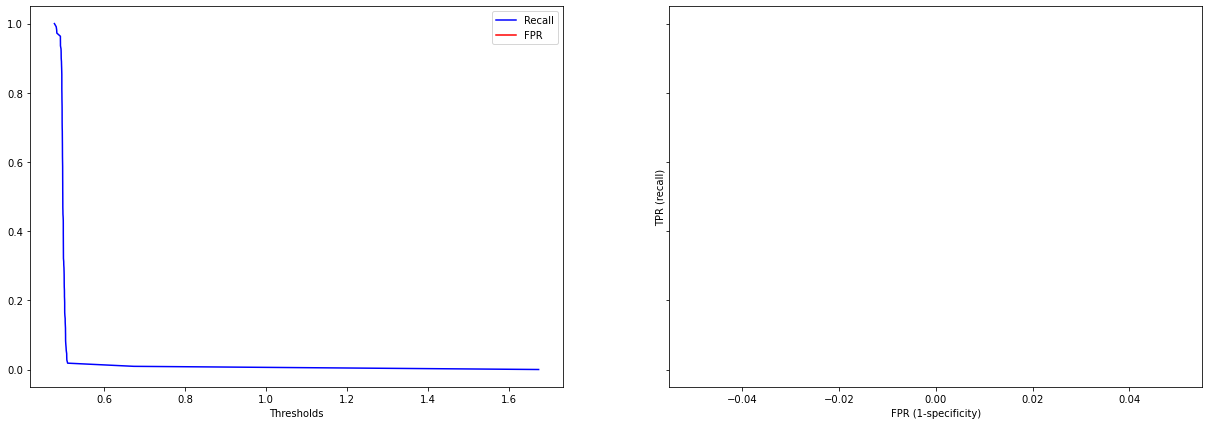

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.699112  0.590966   0.754379     0.807201  0.662535  0.769111
Validation  0.653050  0.543311   0.697897     0.763303  0.609046  0.699537


Ada Logistic
╠■■■■■■■■■╣


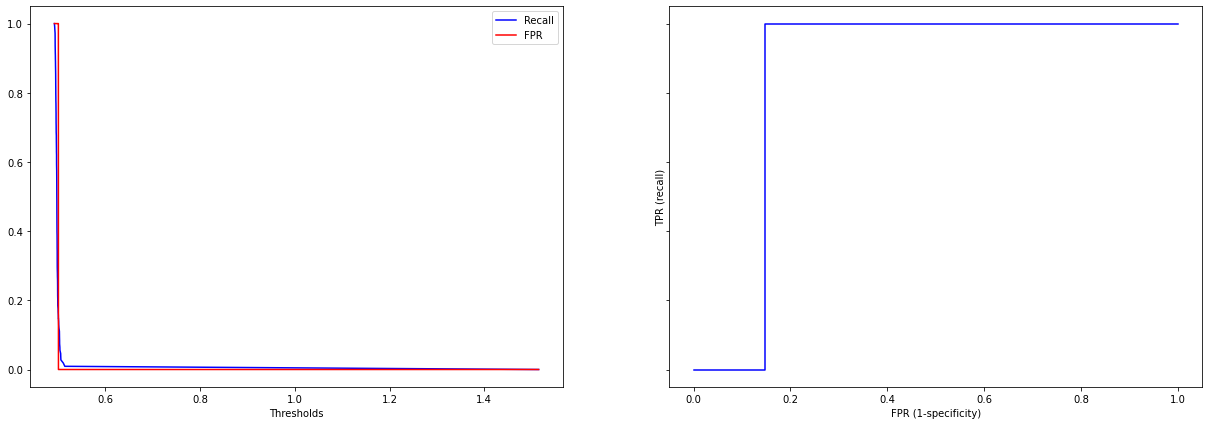

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681917  0.581834   0.727467     0.781947  0.646466  0.739039
Validation  0.671382  0.568916   0.715017     0.774312  0.631773  0.732998


Ada algo
╠■■■■■■■■■╣


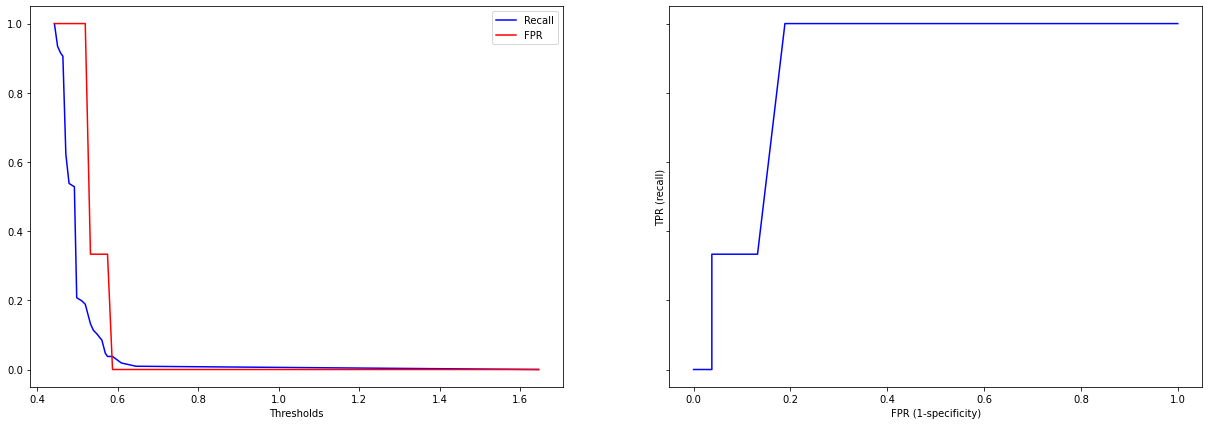

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.678264  0.587512   0.718595     0.768966  0.645716  0.741113
Validation  0.668179  0.585321   0.702153     0.751376  0.635474  0.722420


Ada learning rate
╠■■■■■■■■■╣


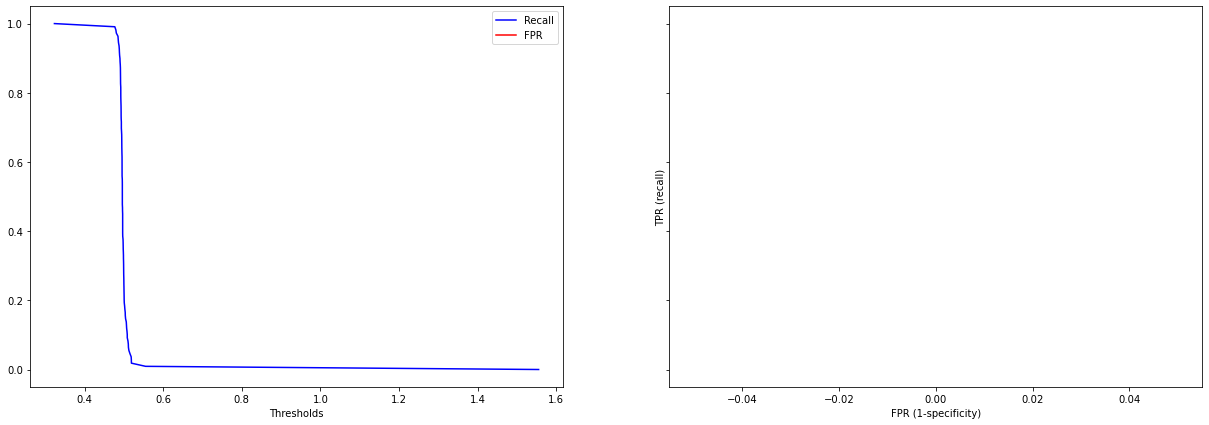

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.695815  0.585083   0.751480     0.806491  0.657804  0.763240
Validation  0.656745  0.557031   0.695269     0.756881  0.616635  0.710234


Ada complete
╠■■■■■■■■■╣


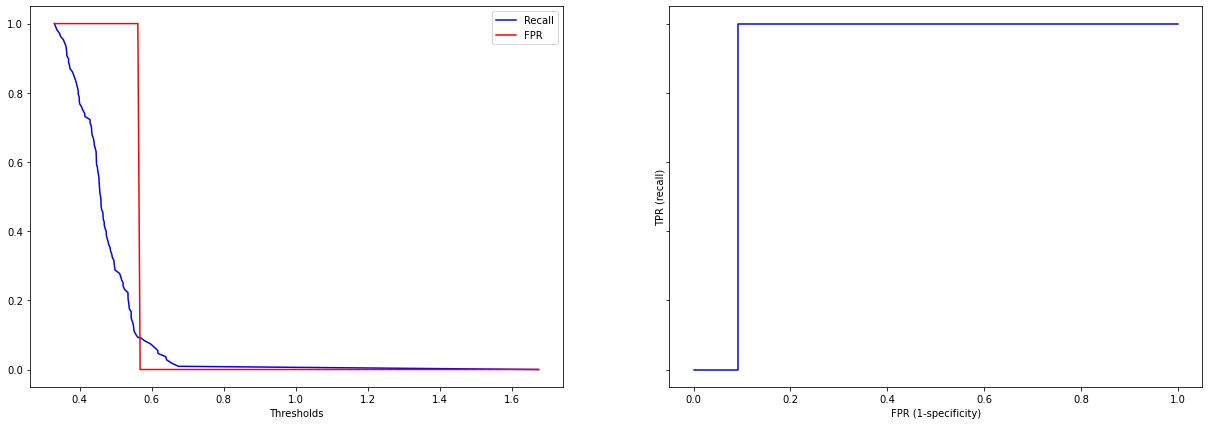

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666750  0.624860   0.682366     0.708621  0.652077  0.716779
Validation  0.655318  0.612694   0.670603     0.698165  0.638316  0.709585

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.653050  0.543311   0.697897     0.763303  0.609046   
Ada Logistic       0.671382  0.568916   0.715017     0.774312  0.631773   
Ada algo           0.668179  0.585321   0.702153     0.751376  0.635474   
Ada learning rate  0.656745  0.557031   0.695269     0.756881  0.616635   
Ada complete       0.655318  0.612694   0.670603     0.698165  0.638316   

                    ROC_AUC  
Ada Vanilla        0.699537  
Ada Logistic       0.732998  
Ada algo           0.722420  
Ada learning rate  0.710234  
Ada complete       0.709585

In [54]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.491
╠■■■■■■■■■╣
Threshold: 0.492
╠■■■■■■■■■╣
Threshold: 0.493
╠■■■■■■■■■╣
Threshold: 0.494
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.496
╠■■■■■■■■■╣
Threshold: 0.497
╠■■■■■■■■■╣
Threshold: 0.498
╠■■■■■■■■■╣
Threshold: 0.499
╠■■■■■■■■■╣
Threshold: 0.5


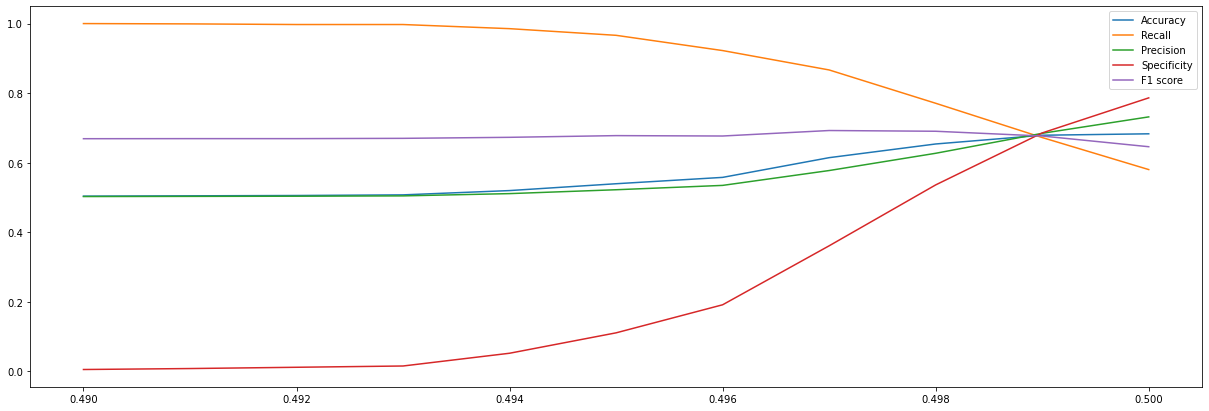

0.490     0.491     0.492     0.493     0.494     0.495  \
Accuracy     0.503429  0.504344  0.505268  0.507103  0.519459  0.539135   
Recall       1.000000  0.999091  0.997273  0.997264  0.985379  0.966205   
Precision    0.502296  0.502761  0.503232  0.504182  0.510708  0.521852   
Specificity  0.004587  0.007339  0.011009  0.014679  0.051376  0.110092   
F1           0.668702  0.668908  0.668916  0.669750  0.672695  0.677588   

                0.496     0.497     0.498     0.499     0.500  
Accuracy     0.557425  0.614162  0.653534  0.678702  0.682810  
Recall       0.922335  0.866547  0.770684  0.672068  0.579883  
Precision    0.534376  0.577121  0.626767  0.684252  0.731504  
Specificity  0.190826  0.360550  0.535780  0.685321  0.786239  
F1           0.676462  0.692271  0.690146  0.676432  0.645633

In [32]:
run_threshold(selected_dataset, y[selected_dataset.index], ada_configurations["Ada Logistic"], thresholds=np.linspace(0.49, 0.50, num=11), ratio_negatives_to_positives=1)

Accuracy    Recall  Precision  Specificity        F1
Metrics  0.724613  0.597786   0.760563     0.835484  0.669421

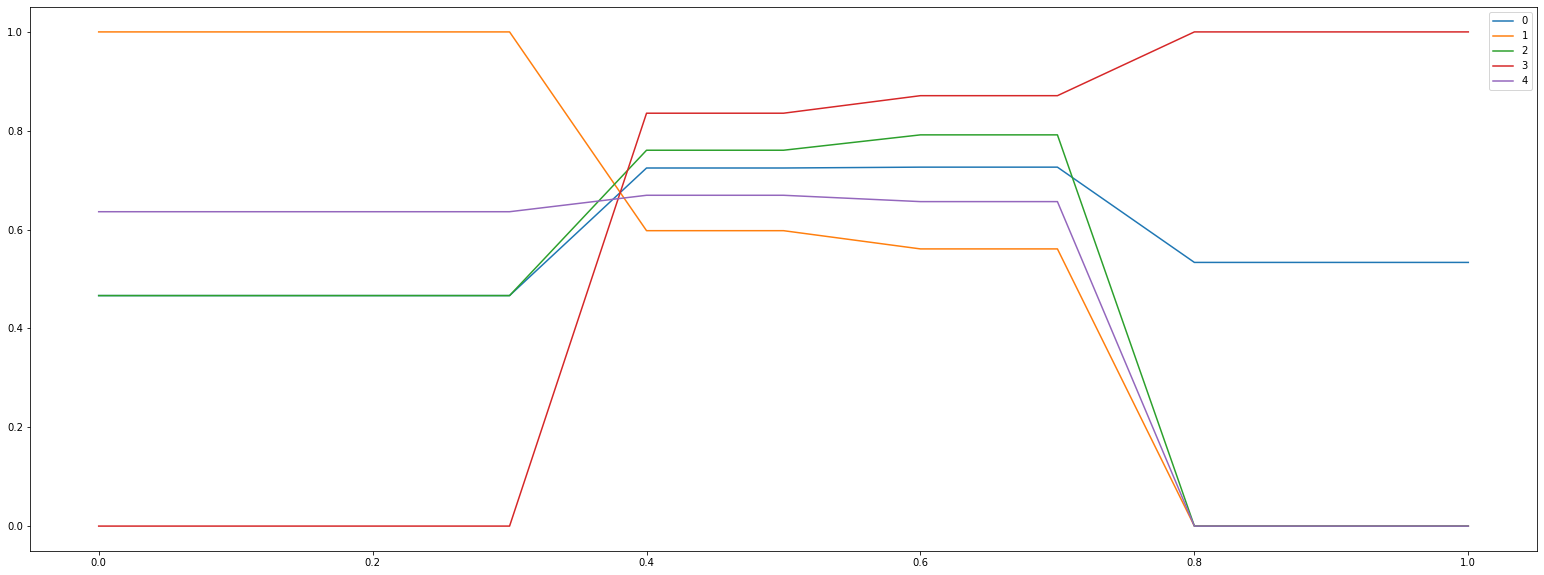

0.0       0.1       0.2       0.3       0.4       0.5  \
Accuracy     0.466437  0.466437  0.466437  0.466437  0.724613  0.724613   
Recall       1.000000  1.000000  1.000000  1.000000  0.597786  0.597786   
Precision    0.466437  0.466437  0.466437  0.466437  0.760563  0.760563   
Specificity  0.000000  0.000000  0.000000  0.000000  0.835484  0.835484   
F1           0.636150  0.636150  0.636150  0.636150  0.669421  0.669421   

                  0.6       0.7       0.8       0.9       1.0  
Accuracy     0.726334  0.726334  0.533563  0.533563  0.533563  
Recall       0.560886  0.560886  0.000000  0.000000  0.000000  
Precision    0.791667  0.791667  0.000000  0.000000  0.000000  
Specificity  0.870968  0.870968  1.000000  1.000000  1.000000  
F1           0.656587  0.656587  0.000000  0.000000  0.000000

In [28]:
from sklearn.model_selection import train_test_split

test_data = pd.concat([selected_dataset[y=="Positive"], selected_dataset[y=="Negative"].sample(np.sum(y=="Positive"))])

X_train, X_test, y_train, y_test = train_test_split(test_data, y[test_data.index])


stack_classifier = StackingCVClassifier([models["Logistic Regression"], ada_configurations["Ada Logistic"]], meta_classifier=RandomForestClassifier())

imp = Imputer()
imp.fit_transform(X_train, y_train)
imp.transform(X_test)

y_train[y_train == "Positive"] = 1
y_train[y_train == "Negative"] = 0
y_train = y_train.astype("float")

stack_classifier.fit(X_train, y_train)

y_preds = stack_classifier.predict(X_test)
y_preds = y_preds.astype("object")
y_preds[y_preds == 1] = "Positive"
y_preds[y_preds == 0] = "Negative"

display(pd.DataFrame(data=np.array(get_metrics(y_test, y_preds)).reshape((1,5)), index=["Metrics"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))

scores = np.ones((11, 5))
thresholds = np.linspace(0, 1, num=11)
i = 0
for threshold in thresholds:
    y_preds = stack_classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds[y_preds >= threshold] = 1
    y_preds[y_preds < 1] = 0
    
    
    
    y_preds = y_preds.astype("object")
    y_preds[y_preds == 1] = "Positive"
    y_preds[y_preds == 0] = "Negative"
    
    scores[i] = get_metrics(y_test, y_preds)
    i+=1

plt.figure(figsize=(27, 10))
for i in range(scores.shape[1]):
    plt.plot(thresholds, scores[:,i], label=i)

plt.legend()
plt.show()
pd.DataFrame(scores.transpose(), index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds)

Apparently stacking and ensemble models do not do much better than regular logistic regression

### SMOTE

In [29]:
models_smote ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    #"SVM" : SVC(kernel='linear', probability=True), #Removed due to getting the notebook stuck
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

In [72]:
ratio_negs_to_pos = (y == "Negative").sum() / (y == "Positive").sum()
weights = ((y == "Positive")* ratio_negs_to_pos * 100) + 1

X_copy = X.copy()
imp = Imputer()
imp.fit_transform(X_copy, y)
run_models(X_copy[selected_features], y, models_smote, ratio_negatives_to_positives=-1, sample_weights=weights)

MultinomialNB
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.793836  0.474490   0.054863     0.801566  0.098319  0.682549
Validation  0.793577  0.468885   0.054264     0.801421  0.097157  0.679041


Random Forest (100 estimators)
╠■■■■■■■■■╣


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.976363  0.00009        0.1          1.0  0.000181  0.685141
Validation  0.976361  0.00000        0.0          1.0  0.000000  0.669629


XGBoost Classifier
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.985255  0.465369   0.840030     0.997843  0.598730  0.908291
Validation  0.969262  0.064170   0.150436     0.991163  0.089693  0.648736


KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.975955  0.032019   0.390964     0.998809  0.058363  0.613891
Validation  0.975665  0.025364   0.291496     0.998673  0.045759  0.609656

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.793577  0.468885   0.054264     0.801421   
Random Forest (100 estimators)  0.976361  0.000000   0.000000     1.000000   
XGBoost Classifier              0.969262  0.064170   0.150436     0.991163   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.975665  0.025364   0.291496     0.998673   

                                      F1   ROC_AUC  
MultinomialNB                   0.097157  0.679041  
Random Forest (100 estimators)  0.000000  0.669629  
XGBoost Classifier              0.089693  0.648736  
KNN                             0.000000  0.000000  
Logistic Regression             0.045759  0.609656

Here I am using sample weights instead of SMOTE to compare the performance between the 2 approaches. Apparently the using sample weights do not yield good results at all.

In [35]:
from sklearn.preprocessing import LabelEncoder

X_copy = X.copy()

imp = Imputer()
imp.fit_transform(X_copy, y)

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y)
print(y_copy.value_counts())
run_models(X_copy[selected_features], y_copy, models_smote, ratio_negatives_to_positives=-1)

(51695, 34)
Positive    50473
Negative    50473
Name: covid19_test_results, dtype: int64
MultinomialNB
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.641184  0.538524   0.677678     0.743846  0.600133  0.69361
Validation  0.641095  0.538509   0.677537     0.743681  0.600059  0.69355


Random Forest (100 estimators)
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.924405  0.878683   0.967121     0.970127  0.920781  0.977795
Validation  0.923385  0.877138   0.966559     0.969651  0.919668  0.976913


XGBoost Classifier
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.981421  0.983363   0.979564     0.979478  0.981457  0.998161
Validation  0.975006  0.975312   0.974708     0.974710  0.975006  0.992319


KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660463  0.560770   0.700434     0.760155  0.622864  0.727269
Validation  0.660383  0.560398   0.700436     0.760375  0.622609  0.727066

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.641095  0.538509   0.677537     0.743681   
Random Forest (100 estimators)  0.923385  0.877138   0.966559     0.969651   
XGBoost Classifier              0.975006  0.975312   0.974708     0.974710   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.660383  0.560398   0.700436     0.760375   

                                      F1   ROC_AUC  
MultinomialNB                   0.600059  0.693550  
Random Forest (100 estimators)  0.919668  0.976913  
XGBoost Classifier              0.975006  0.992319  
KNN                             0.000000  0.000000  
Logistic Regression             0.622609  0.727066

In the initial run logistic regression didn't do better, but surprisingly the tree-based models did extremely well. Although this might be a legit improvement due to now having enough samples, I suspect the tree base models are overfitting since I am doing the cross validation <i>after doing the resampling</i>. The next iteration will be saving a test sample with evenly distributed samples of positive and negative taken away before the resampling and applying SMOTE to the rest.

In [53]:
from sklearn.metrics import confusion_matrix
X_test = pd.concat([X[y=="Positive"].sample(100), X[y=="Negative"].sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test)].copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test.drop(columns=["sys", "dia"]))
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test.drop(columns=["sys", "dia"]))[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])

(51583, 34)
Negative    50366
Positive    50366
Name: covid19_test_results, dtype: int64
MultinomialNB
[[73 27]
 [49 51]]
Random Forest (100 estimators)
[[99  1]
 [79 21]]
XGBoost Classifier
[[96  4]
 [43 57]]
KNN
[[97  3]
 [ 6 94]]
Logistic Regression
[[70 30]
 [44 56]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.620    0.51   0.653846         0.73   
Random Forest (100 estimators)     0.600    0.21   0.954545         0.99   
XGBoost Classifier                 0.765    0.57   0.934426         0.96   
KNN                                0.955    0.94   0.969072         0.97   
Logistic Regression                0.630    0.56   0.651163         0.70   

                                      F1  ROC_AUC  
MultinomialNB                   0.573034   0.7009  
Random Forest (100 estimators)  0.344262   0.7775  
XGBoost Classifier              0.708075   0.9497  
KNN                             0.954315   0.9976  
Logistic Regression             0.602151   0.6955

As expected, the tree methods were overfitting. Surprisingly enough, KNN performed really well with oversampling: so far it would be the best model we have. However, since the socres are too high, I believe there might be some kind of overfitting done as well (in order to test this, it might be good to use the data from the dataset from Mexico since, in theory, has no relationship to this one). Logistic Regression is doing a little bit worse than our best model. However it makes me curious to see if by moving the thresholds, the performance improves. If that is the case, doing SMOTE might be a very good thing to do for imbalanced datasets.

In [56]:
X_test = pd.concat([X.loc[y=="Positive", selected_features].dropna(how="all").sample(100), X.loc[y=="Negative", selected_features].dropna(how="all").sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test), selected_features].dropna(how="all").copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy, y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test)
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test)[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])

(51614, 16)
Negative    50397
Positive    50397
Name: covid19_test_results, dtype: int64
MultinomialNB
[[71 29]
 [34 66]]
Random Forest (100 estimators)
[[98  2]
 [69 31]]
XGBoost Classifier
[[87 13]
 [50 50]]
KNN
[[97  3]
 [21 79]]
Logistic Regression
[[79 21]
 [40 60]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.685    0.66   0.694737         0.71   
Random Forest (100 estimators)     0.645    0.31   0.939394         0.98   
XGBoost Classifier                 0.685    0.50   0.793651         0.87   
KNN                                0.880    0.79   0.963415         0.97   
Logistic Regression                0.695    0.60   0.740741         0.79   

                                      F1  ROC_AUC  
MultinomialNB                   0.676923  0.72895  
Random Forest (100 estimators)  0.466165  0.78325  
XGBoost Classifier              0.613497  0.86365  
KNN                             0.868132  0.97970  
Logistic Regression             0.662983  0.73585

By just using the selected features, performance on KNN decreases a little bit. Logistic regression on the other hand improved way more than how it was doing in the baseline. I trust these results more because with the complete dataset, apart from the comorbidities, half of the examples have null features.

## Sidequest: Understanding logistic regression

In [ ]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]